# AirBnb Listings Analysis

## Predicting Airbnb Prices in Montreal

### **Dataset**
This dataset contains Airbnb listings from Montreal, including variables such as location, property type, amenities, number of bedrooms, and whether or not the host is a super host. Each listing includes a target variable: price per night.

### **Context**
Airbnb has come under increasing scrutiny in Montreal due to regulatory pressures, housing affordability concerns, and shifting traveler behavior. In this challenging environment, hosts are looking for data-driven insights to help maximize revenue while remaining competitive and compliant. Understanding which factors most influence pricing can empower hosts to make smarter decisions about property features, pricing strategies, and listing optimization.

### **Objective**
Our goal is to evalute different predictive models to estimate nightly prices based on listing characteristics. By analyzing which variables most strongly correlate with higher prices, we aim to select the model that best identifies actionable levers that hosts can use to improve performance.

### **Scope**
To ensure relevance, we focus exclusively on Montreal listings from 2025. This timeframe reflects current market dynamics, including post-pandemic travel patterns and recent regulatory changes that came in early 2025. Listings with extreme outliers or missing key features will be excluded to maintain model integrity.

In [295]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [296]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text 

## Basic Exploration

In this section we are doing a basic exploration to understand the number of rows, columns and data types in the Airbnb DataSet. At the end we summarize our key takeaways before moving on to our Data Cleaning section

In [297]:
# Loading data
listings = pd.read_csv('listings.csv')  # go up one directory
listings.head(5)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,29059.0,https://www.airbnb.com/rooms/29059,2.025060e+13,6/27/25,city scrape,Lovely studio Quartier Latin,"CITQ 267153<br />Lovely studio with 1 closed room, near everything in the Quartier Latin. Enjoy the festivals, downtown with activities or the famous Mont-Royal.<br />Everything included: bedding, bath towels, basic food items (condiments, flour, rice, pasta, spices, etc.), housekeeping, cable, WIFI","CENTRAL is the watchword: everything is close. The Latin Quarter, the shows, St Denis, Old Montreal, the city center, the gay neighborhood or the plateau: you can walk all the way there. And if you want to go further: bike for rent at the end of the street or subway 4 mins walk. Saying better!",https://a0.muscache.com/pictures/736399/fa6c3103_original.jpg,125031,...,4.78,4.82,4.67,"Quebec - Registration number<br />267153, expires: 2026-03-31",f,2,2,0,0,2.66
1,29061.0,https://www.airbnb.com/rooms/29061,2.025060e+13,6/26/25,city scrape,Maison historique - Quartier Latin,"Lovely historic house with plenty of period charm, close to everything, in Montrealâ€™s delightful Latin Quarter. Walk to all the festivals.","The neighborhood you'll discover is called the Latin Quarter. Personally, I love it because it's at the center of all cultural activities in Montreal. You are close to Plateau, Quartier des Spectacles, Old Montreal, Gay neighborhood, Sainte Catherine, Parc Lafontaine. And your trips will be easy on foot or by Bixi (self-service bike) in summer or by metro in winter (Berri central station is 5 mins walk away)",https://a0.muscache.com/pictures/9e59d417-4b6a-4db1-94a6-ccac69e236bf.jpg,125031,...,4.83,4.87,4.72,"Quebec - Registration number<br />267153, expires: 2026-03-31",f,2,2,0,0,0.96
2,36301.0,https://www.airbnb.com/rooms/36301,2.025060e+13,6/26/25,city scrape,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, bright & peaceful nest in Trendy Plateau !",The neighborhood is very lively while the street is very peaceful. It is also very safe and any time of day or night.,https://a0.muscache.com/pictures/26c20544-475f-4d69-9e99-53eeb6398ff0.jpg,381468,...,4.90,4.88,4.77,NaN,f,8,8,0,0,0.42
3,38118.0,https://www.airbnb.com/rooms/38118,2.025060e+13,6/26/25,city scrape,Beautiful room with a balcony in front of a parc,"Nearest metro Papineau. Situated in front of Parc des Faubourgs, 5 min walk to Parc Lafontaines, walking distance to UQAM & St.Denis (15 min), & Old Montreal (about 30 min walk).",NaN,https://a0.muscache.com/pictures/213997/763ec177_original.jpg,163569,...,4.82,4.65,4.41,NaN,f,3,0,3,0,0.10
4,50479.0,https://www.airbnb.com/rooms/50479,2.025060e+13,6/26/25,city scrape,L'Arcade Douce,"The appartement is sunny and ideally situated in the handsome area of Petite-Patrie, 10 minutes walk from the market Jean-Talon and all services (grocery store, underground orange and blue line). The area has also a lot of restaurants, little cafes and bars and a cycle path and BIXI station round the corner. <br />Note that it is on the 3rd floor so you have one flight of stairs outside and one inside. Also, there is no private parking available but you generally can park easily on our street.","Our area is full of life (but our street is quiet, do not worry !) It is great for both family with young children with a lot of parcs or to go out in littles cafÃ©s, boulangeries, restaurants for brunch or evening and even great bars near the plaza Saint-Hubert.",https://a0.muscache.com/pictures/airflow/Hosting-50479/original/f32fe1c1-7e87-43cf-b30a-0ef1dbed6757.jpg,231694,...,4.99,4.85,4.93,"Quebec - Registration number<br />271530,

In [298]:
listings.shape 
#number of rows and columns of the DataFrame

(9737, 79)

In [299]:
listings.count() 
#number of values in each column. In this case we see that reviews_per_month has less values that the rest 7889<9737 therefore we possibly have missing values

id                                              9737
listing_url                                     9737
scrape_id                                       9737
last_scraped                                    9737
source                                          9737
                                                ... 
calculated_host_listings_count                  9737
calculated_host_listings_count_entire_homes     9737
calculated_host_listings_count_private_rooms    9737
calculated_host_listings_count_shared_rooms     9737
reviews_per_month                               7889
Length: 79, dtype: int64

In [300]:
listings.columns
#all of the column names. Easier to interpret by looking at the cvs file itself.

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [301]:
# Identify numeric and categorical columns
numeric_cols = listings.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = listings.select_dtypes(include=['object', 'category']).columns.tolist()

# Print counts and column names
print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"\nNumber of categorical columns: {len(categorical_cols)}")


Number of numeric columns: 44

Number of categorical columns: 35


In [302]:
listings.dtypes.value_counts() #number of columns for each datatype

object     35
float64    24
int64      20
Name: count, dtype: int64

In [303]:
# An interesting field in the dataset is the amenity column. Its a comma separated list containing many different amenities for each property
# It may help us later on with feature engineering so we will explore it now.

# Get the amenity string for the first row (index 0)
amenity_string = listings.loc[0, 'amenities']

# Print the full string to see what it looks like
print(f"Full amenity string: {amenity_string}")

# Clean the string by removing the outer brackets
cleaned_string = amenity_string.strip('[]')

# Check if the string is empty after stripping (i.e., it was just "[]")
if not cleaned_string:
    count = 0
else:
    # Split the string by commas to get a list of amenities
    amenity_list = cleaned_string.split(',')
    # Get the length of the list
    count = len(amenity_list)

print(f"Number of amenities: {count}")

Full amenity string: ["Hair dryer", "Hot water kettle", "Crib - available upon request", "Conditioner", "Toaster", "Private patio or balcony", "Cleaning products", "Laundromat nearby", "Extra pillows and blankets", "TV with standard cable", "Kitchen", "Self check-in", "Booster seat high chair - available upon request", "First aid kit", "Children\u2019s books and toys for ages 0-2 years old", "Shampoo", "Clothing storage: closet", "Radiant heating", "Free street parking", "Pack \u2019n play/Travel crib - available upon request", "Courtyard view", "Outdoor dining area", "Oven", "Iron", "Coffee", "City skyline view", "Fast wifi \u2013 116 Mbps", "Shared backyard \u2013 Fully fenced", "Books and reading material", "Cooking basics", "Paid parking lot off premises", "Essentials", "Hangers", "Keypad", "Bed linens", "Wine glasses", "Induction stove", "Carbon monoxide alarm", "Coffee maker", "Fire extinguisher", "Pets allowed", "Sound system with aux", "Smoke alarm", "Dishes and silverware", "H

**Takeaways from Initial Exploration:**
- There are 9737 rows abnd 79 columns.
- The dataset contains several different datatypes including int, float, and object.
- We identified date type variables which indicate we might have to standardize some of the data types.
- Several categories in the dataset are identifiers, like URL, ID, and picture URL. They will have to be dropped as they are metadata not related to price.
- Some features are aggregates of others, so we’ll drop the summed columns to avoid redundancy and multicollinearity. For example, calculated_host_listings_count = calculated_host_listings_count_entire_homes + calculated_host_listings_count_private_rooms + calculated_host_listings_count_shared_rooms.
- The Amenity column is a comma separated list containing multiple amenitifes for each property. We are taking note for a possible future feature engineered variable

# Data Cleaning

In this section, we begin the Data Cleaning process. We handle it in a 2 step plan:

1. We start by identifying and deciding how to handle inconsistencies, outliers, duplicates, and missing values. We will provide a takeaways summary (similar to the one above).
2. Once the plan is set, we will carry out the actual data cleaning steps.

## 1. Plan out Action Plan

### Step 1a) Identify Inconsistencies

Inconsistency 1: Price column and Date column have to be converted to appropriate datatypes (numeric and datetime). More on that in part 2 of the Data Cleaning

Inconsistency 2: 
The 'minimum_nights' variable shows unusually high values. Most listings require 10+ nights, which seems counterintuitive.
After further exploration, this appears to be driven by Montreal regulations (e.g., 30-night minimums for properties in most popular destinations). The government did this to support long term housing.
In practice, a minimum stay of 2 nights is more typical.
To simplify analysis and reduce noise from extreme values, we're engineering a cateogry from min nights as "1:regulated and 0: not regulated" 

In [304]:
# Count listings per minimum night value
min_night_counts = listings['minimum_nights'].value_counts().sort_index()

# Table form
table = min_night_counts.reset_index()
table.columns = ['minimum_nights', 'listing_count']

# Show first 40 rows
table.head(40)

,minimum_nights,listing_count
0,1,1981
1,2,1549
2,3,424
3,4,88
4,5,60
5,6,18
6,7,40
7,8,1
8,9,1
9,10,6


Inconsistency 3: Accents and weird characters leading to unstandardized entries.
The csv has a lot of weird text given the datasets inability to deal with accents. Therefore it will have to be cleaned
For instance in the list below, Cote des neiges breaks

In [305]:
listings["neighbourhood_cleansed"].head(10)

0                              Ville-Marie
1                              Ville-Marie
2                    Le Plateau-Mont-Royal
3                              Ville-Marie
4                Rosemont-La Petite-Patrie
5                              Ville-Marie
6    CÃ´te-des-Neiges-Notre-Dame-de-GrÃ¢ce
7                              Ville-Marie
8                             Le Sud-Ouest
9                    Le Plateau-Mont-Royal
Name: neighbourhood_cleansed, dtype: object

| Variables in table above (with inconsistencies)                      | Action                           | Inconsistency Treatment Plan |
|--------------------------------|----------------------------------|------------------------|
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat ≥31 nights as “restricted” and others as “not restricted.” |
| Accents | Mapping                        | Changing identified errors to a consistent format |


### Step 1b) Identifying Outliers

In [306]:
# Outlier Detection via IQR Method
outlier_summary = []
for col in numeric_cols: 
    Min = listings[col].min()
    Max = listings[col].max()
    Q1 = listings[col].quantile(0.25)
    Q3 = listings[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = listings[(listings[col] < lower) | (listings[col] > upper)]
    outlier_summary.append({
        'Variable': col,
        'Min': Min,
        'Max': Max,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower,
        'Upper_Bound': upper,
        'Num_Outliers': len(outliers),
        'Pct_Outliers': round(len(outliers) / len(listings) * 100, 2)
    })

outlier_df = (
    pd.DataFrame(outlier_summary)
      .query("Pct_Outliers > 0")
      .sort_values(by="Pct_Outliers", ascending=False)
)

outlier_df.head(5)

,Variable,Min,Max,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Num_Outliers,Pct_Outliers
13,maximum_nights,1.0,99999.0,365.0,365.0,0.0,365.0,365.0,4506,46.28
41,calculated_host_listings_count_private_rooms,0.0,44.0,0.0,0.0,0.0,0.0,0.0,2261,23.22
9,bathrooms,0.0,16.0,1.0,1.0,0.0,1.0,1.0,1749,17.96
40,calculated_host_listings_count_entire_homes,0.0,139.0,1.0,13.0,12.0,-17.0,31.0,1285,13.20
29,number_of_reviews_ly,0.0,404.0,0.0,13.0,13.0,-19.5,32.5,1269,13.03


| Variables in table above (with outliers)                      | Action                           | Outlier Initial Treatment Plan if chosen as explanatory variable |
|--------------------------------|----------------------------------|------------------------|
| maximum_nights                 | Cap at 90   | We don't want unrealistic numbers like 999 where the host probably mistyped. Per regulation, Airbnb must cap at 90 |
| bedrooms                       | Remove   | Remove extreme outliers. Many of these look like typos (999+ bedrooms). |
| accommodates                   | Remove   | Same as above. Remove extreme outliers.  |
| bathrooms                      | Remove   | Same as above. Remove extreme outliers.  |
| beds                           | Remove   | Same as above. Remove extreme outliers. |
| calculated_host_listings_count | Cap at 90th percentile and bin   | Cap at the 90th-percentile|
| price                          | Log number                       | Model log(price) to handle skew. |
| number_of_reviews              | Binning                       | We bin into five unequally-spaced categories because after the last threshold we expect the marginal value of an incremental review is zero |
| minimum_nights                 | Convert to Binary (restricted vs not)       | Montreal regulations: treat **≥31 nights** as “restricted” and others as “not restricted.” |
| All other columns with outliers | Remove                        | Removed because they add no explanatory value to the model (metadata) or are duplicated elsewhere in the dataset definition. |


### Step 1c) Identifying Duplicates

In [307]:
# Check for duplicate rows
duplicate_count = listings.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Preview of duplicate rows:")
    display(listings[listings.duplicated()].head())
else:
    print("No duplicate rows found in the dataset, so no further action needed")

Total number of duplicate rows: 0
No duplicate rows found in the dataset, so no further action needed


### Step 1d) Identifying Missing Values

In [308]:
# Build summary
missing_value = pd.DataFrame({
    "Variable": listings.columns,
    "Num_Missing": listings.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(listings) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

# Show
missing_value_nonzero.head(10)

,Variable,Num_Missing,Pct_Missing
0,calendar_updated,9737,100.00
1,neighbourhood_group_cleansed,9737,100.00
2,host_neighbourhood,6406,65.79
3,neighbourhood,5447,55.94
4,neighborhood_overview,5447,55.94
5,host_about,4786,49.15
6,license,4481,46.02
7,host_location,2459,25.25
8,review_scores_checkin,1849,18.99
9,review_scores_accuracy,1849,18.99


| Variable                     | Amount |   %   | Action                                  | Our treatment plan explanation if variable selected in our model                                                                                                              |
| ---------------------------- | :----: | :---: | --------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| review_scores_accuracy       |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                              |
| review_scores_checkin        |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_value          |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_location       |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_cleanliness    |  1849  | 18.99 | Remove                        | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| review_scores_communication  |  1849  | 18.99 | Remove                       | Empty in the dataset means no bookings yet so not helpful for our model                                                                                               |
| last_review                  |  1848  | 18.98 | Remove column                        | Already in other column                                                                                                |
| review_scores_rating         |  1848  | 18.98 | Input Median                        | Empty in the dataset means no bookings yet                                                                                               |
| first_review                 |  1848  | 18.98 | Remove Column                        | Already in other column                                                                                               |
| reviews_per_month            |  1848  | 18.98 | Remove                      | Empty in the dataset means no bookings yet so not helpful for our mode                                                                                               |
| host_response_time           |  1006  | 10.33 | No action                            | Lack of data is understandable. Means host is new. Remove                            |
| host_response_rate           |  1006  | 10.33 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bathrooms                    |   963  |  9.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| beds                         |   962  |  9.88 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_acceptance_rate         |   866  |  8.89 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| bedrooms                     |   178  |  1.83 | Input median                            | Inputting median so the data can be considered without adding bias                                                                |
| host_is_superhost            |   452  |  4.64 | Use median or K-NN with the criteria as per Airbnb | Airbnb has criteria that defines superhost. We will use median or K-NN to impute this field                                                 |
| price                        |   959  |  9.85 | Remove rows                             | Because price is the dependent variable, imputing it would leak information and distort the loss; exclude for training/validation |
| calendar_updated             |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood_group_cleansed |  9737  |  100  | Remove Column                           | Metadata or already in other column                                                                                               |
| host_neighbourhood           |  6406  | 65.79 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighborhood_overview        |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| neighbourhood                |  5447  | 55.94 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_about                   |  4786  | 49.15 | Remove Column                           | Metadata or already in other column                                                                                               |
| license                      |  4481  | 46.02 | Remove Column                           | Metadata or already in other column                                                                                               |
| host_location                |  2459  | 25.25 | Remove Column                           | Metadata or already in other column                                                                                               |
| estimated_revenue_l365d      |   959  |  9.85 | Remove Column                           | Metadata or already in other column                                                                                               |
| description                  |   160  |  1.64 | Remove Column                           | Metadata or already in other column                                                                                               |
| has_availability             |   121  |  1.24 | Remove Column                           | Metadata or already in other column                                                                                               |
| bathrooms_text               |    6   |  0.06 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| min_nights_bin               |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_maximum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| minimum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                               |
| maximum_minimum_nights       |    4   |  0.04 | Remove Column                           | Metadata or already in other column                                                                                                                                                             


### Takeaways from Data Cleaning exploration:

- Several inconsistencies were identified, such as unrealistic `minimum_nights` values and neighbourhood names with accents or formatting issues. These were standardized or mapped into consistent categories.

- Outliers were detected using the IQR method. Variables like `maximum_nights`, `bedrooms`, `accommodates`, and `bathrooms` contained extreme or unrealistic values, which were capped, removed, binned, or converted depending on their role in the model.

- No duplicate rows were found in the dataset, so no additional action was required for this step.

- Many variables contained missing values. Review-related fields showed ~18–19% missingness (due to no bookings yet), so median imputation may be used. Metadata or redundant variables will be removed.

- Several ID-like, URL, or metadata fields will be dropped because they do not contribute to predicting price. Some aggregated fields were also removed to avoid redundancy and multicollinearity.


## 2. Initial Data Cleaning

Each of the issues found above will be addressed. Starting with inconsistencies, then outliers, followed by duplicates, and ending with missing values. At the end we will summarize the actions taken/takeaways

In [309]:
#Creating new data frame to start addressing datatypes for analysis
#creating a "clean" list will allow us to handle data without touching the original one
listings_clean = listings.copy()

### Addressing Inconsistencies

1. **Converting fields to appropriate datatypes**: Converting non conventional data like price, date and % format to number

2. **Mapping corrupted names to corrected ones for standarization**: Making sure inconsistencies in names do not affect modelling

3. **Addressing Min night inconstistency by creating a min night variable**: Convert to Binary (restricted vs not)

In [310]:
#Converting date columns to date time type
date_columns = ['last_review', 'first_review', 'host_since']

date_columns = ['last_review', 'first_review', 'host_since']

for col in date_columns:
    listings_clean[col] = pd.to_datetime(listings_clean[col], errors='coerce')


# Converting to Numeric - removing $ and % signs
# Remove % and convert to float in the same column
listings_clean["host_response_rate"] = listings_clean["host_response_rate"].str.replace("%","").astype(float)
listings_clean["host_acceptance_rate"] = listings_clean["host_acceptance_rate"].str.replace("%","").astype(float)

# Remove $ and commas and convert to float in the same column
listings_clean["price"] = listings_clean["price"].replace("[\$,]","", regex=True).astype(float)



# Creating a regulated vs not regulated column to address Montreal Min night regulations: If listing is allowed to book for <31 nights its "not regulated", else its "regulated"
listings_clean["min_nights_regulation"] = np.where(
    listings_clean["minimum_nights"] < 31, "not regulated", "regulated"
)


<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
/var/folders/05/c9zdgr4547322q849bfzjp2c0000gn/T/ipykernel_99866/1370537754.py:16: SyntaxWarning: invalid escape sequence '\$'
  listings_clean["price"] = listings_clean["price"].replace("[\$,]","", regex=True).astype(float)
/var/folders/05/c9zdgr4547322q849bfzjp2c0000gn/T/ipykernel_99866/1370537754.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  listings_clean[col] = pd.to_datetime(listings_clean[col], errors='coerce')
/var/folders/05/c9zdgr4547322q849bfzjp2c0000gn/T/ipykernel_99866/1370537754.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  listings_clean[col] = pd.to_datetime(listings_clean[col], erro

In [311]:
#import matplotlib.pyplot as plt

#plt.hist(listings_clean["first_review"])
#plt.title("Days Since Host Sign Up")
#plt.xlabel("Days")
#plt.ylabel("Count")
#plt.show()

#plt.hist(listings_clean["days_since_first_review"])
#plt.title("Days Since First Review")
#plt.xlabel("Days")
#plt.ylabel("Count")
#plt.show()

#plt.hist(listings_clean["days_since_last_review"])
#plt.title("Days Since Last Review")
#plt.xlabel("Days")
#plt.ylabel("Count")
#plt.show()


In [312]:
# Dictionary mapping corrupted names to corrected ones
fix_map = {
    "CÃ´te-des-Neiges-Notre-Dame-de-GrÃ¢ce": "Cote-des-Neiges–Notre-Dame-de-Grace",
    "Baie-d'UrfÃ©": "Baie-d’Urfe",
    "RiviÃ¨re-des-Prairies-Pointe-aux-Trembles": "Riviere-des-Prairies–Pointe-aux-Trembles",
    "CÃ´te-Saint-Luc": "Cote-Saint-Luc",
    "L'ÃŽle-Bizard-Sainte-GeneviÃ¨ve": "L’Ile-Bizard–Sainte-Genevieve",
    "Saint-LÃ©onard": "Saint-Leonard",
    "MontrÃ©al-Ouest": "Montreal-Ouest",
    "MontrÃ©al-Nord": "Montreal-Nord",
    "MontrÃ©al-Est": "Montreal-Est"
}

# Apply replacements
listings_clean["neighbourhood_cleansed"] = (
    listings_clean["neighbourhood_cleansed"].replace(fix_map))

In [313]:
#This feature is categorical and the data is ordinal, so it would be best to map to an hour scale and then impute the median

# Mapping dictionary
response_map = {
    'within an hour': 1,
    'within a few hours': 3,
    'within a day': 24,
    'a few days or more': 72
}

# Map and overwrite the original column in place
listings_clean['host_response_time'] = listings_clean['host_response_time'].map(response_map)

### Addressing Outliers

1. **Capping maximum nights available to rent to 90**: Per the definition in Quebec, anyone renting for less than 90 days is defined as short term rentee.
   
2. **Drop any features beyond 3 standard deviations for bedrooms, bathrooms, acommodates and beds**: After searching the URLs, we find these to be typos or big hotel chains so outside of our scope

   
3. **Dropped any rows where the hosts had more listings than 99.7 percentile (3std)**: By looking at the data, these also represented hotels and may distort the model from its purpose.

   
4. **Logged price and number of reviews**: Prevents bias from very expensive AirBnBs.


In [314]:
# Max nights capped at 365 to remove unrealistic values

listings_clean['maximum_nights'] = listings['maximum_nights'].clip(upper=90)

## sanity check: listings_clean[["maximum_nights"]].head(40)

In [315]:
# Beds/Accomodates/Bathrooms outlier handling:
#Finding extreme outliers (hotels). Anything at 3 std  will be removed.
house_features_to_check = ["bedrooms", "bathrooms", "accommodates", "beds"]
# Get averages and spreads
averages = listings[house_features_to_check].mean()
spreads  = listings[house_features_to_check].std()

# Cap values above +3 std or below -3 std
for feature in house_features_to_check:
    lower = averages[feature] - 3 * spreads[feature]
    upper = averages[feature] + 3 * spreads[feature]
    listings_clean[feature] = listings_clean[feature].clip(lower=0, upper=upper) # Im setting lower = 0 cause we cant have negative bathrooms


In [316]:
#dropping where hosts have more listings than 99.7 percentile
p99_chlc = listings["calculated_host_listings_count"].quantile(0.997)
listings_clean["calculated_host_listings_count"] = (
    listings["calculated_host_listings_count"].clip(upper=p99_chlc)
)


In [317]:
# price and number of reviews outlier handling. Log the values to avoid heavy weight to anomalies. Creating new columns rather than rewriting just in case

listings_clean["price"] = np.where(listings_clean["price"] > 0,
                                       np.log1p(listings_clean["price"]), np.nan)
listings_clean["number_of_reviews"] = np.log1p(listings_clean["number_of_reviews"])

### Addressing Missing Data

1. **We remove metadata and redundant categorical fields that do not help explain price**: Some columns may look useful at first (for example, neighbourhood), but these are widely empty or contain weird characters. The actual cleaned version we use is neighbourhood_cleansed. In these cases, we drop the raw or duplicate columns and keep only the relevant, cleaned variable.

2. **Removing any data without price**: Each row must have the dependent variable.

3. **Handling missing Is_Super_Host**: Because host_is_superhost is a host-level attribute, we use any known value from one listing to fill all listings for the same host. If a host has no known value at all, we default it to False since an unknown status is more consistent with not being a Superhost (new hosts)

4. **Dropping listings with 0 reviews**: Listings with missing review information have never been booked, meaning they are too new to have a market-validated price. Since our model aims to learn pricing patterns from mature Airbnbs with real booking history, we remove these immature listings to avoid training on prices that haven’t been tested by the market.

5. **Median imputation** Given the small amount missing and given we removed outliers, we will imputate median for missing bathrooms, beds, bedrooms, review_scores and reviews_per_month

6. **Mode Imputation**: For host_response_time we will use the mode given its categorical "within an hour", "within a few hours", "within a day"

In [318]:
# Removing metadata and redundant cateogircal fields
#Columns to drop
drop_in_listings_clean = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description',
    'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
    'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
    'host_neighbourhood', 'host_total_listings_count', 'host_verifications',
    'neighbourhood', 'neighbourhood_group_cleansed',
    'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60',
    'availability_90', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy',
    'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'first_review', 'license',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'has_availability'
]

# Drop them from the DataFrame (ignore missing just in case)
listings_clean = listings_clean.drop(columns=drop_in_listings_clean, errors='ignore')

In [319]:
# Dropping any value without prices to avoid distorting prediction
listings_clean = listings_clean.dropna(subset=["price"]).copy()

In [320]:
# 1. Borrow the first known superhost status within each host_id group
listings_clean["host_is_superhost"] = (
    listings_clean.groupby("host_id")["host_is_superhost"]
    .transform("first")
)

# 2. Drop any rows where host_is_superhost is still NaN
listings_clean = listings_clean.dropna(subset=["host_is_superhost"])

# 3. Check result
print("Remaining rows:", len(listings_clean))
print(listings_clean["host_is_superhost"].value_counts())


Remaining rows: 8351
host_is_superhost
f    5043
t    3308
Name: count, dtype: int64


In [321]:
#dropping where there are no reviews. These airbnbs are all new
listings_clean = listings_clean[listings_clean['number_of_reviews'] > 0].reset_index(drop=True)

In [322]:
# Columns where we'll fill missing values with the median
cols_to_fill_with_median = [
  "host_response_rate", "bathrooms",
    "beds", "host_acceptance_rate", "bedrooms", "review_scores_accuracy", "review_scores_checkin", "review_scores_value",
    "review_scores_location", "review_scores_cleanliness",
    "review_scores_communication",
    
    "review_scores_rating", "reviews_per_month","host_response_time"
]

# Fill missing values using each column's median
for col in cols_to_fill_with_median:
    listings_clean[col] = pd.to_numeric(listings_clean[col], errors="coerce")
    median_value = listings_clean[col].median()
    listings_clean[col] = listings_clean[col].fillna(median_value)

In [323]:
# Fill missing values in 'host_response_time' with the mode
mode_value = listings_clean['host_response_time'].mode()[0]
listings_clean['host_response_time'] = listings_clean['host_response_time'].fillna(mode_value)

#### Confirming Missing Data Handling

In [324]:
missing_value = pd.DataFrame({
    "Variable": listings_clean.columns,
    "Num_Missing": listings_clean.isna().sum().values
})
missing_value["Pct_Missing"] = (missing_value["Num_Missing"] / len(listings_clean) * 100).round(2)

# Sort and keep only columns with any missing values
missing_value = missing_value.sort_values("Pct_Missing", ascending=False).reset_index(drop=True)
missing_value_nonzero = missing_value[missing_value["Num_Missing"] > 0].reset_index(drop=True)

if missing_value_nonzero.empty:
    print("No missing data found.")
else:
    print("Found missing data:")
    display(missing_value_nonzero)

No missing data found.


In [325]:
listings_clean.head()

,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,min_nights_regulation
0,125031,2010-05-14,1.0,100.0,100.0,t,2,t,t,Ville-Marie,...,4.79,4.63,4.82,4.78,4.82,4.67,f,2,2.66,regulated
1,125031,2010-05-14,1.0,100.0,100.0,t,2,t,t,Ville-Marie,...,4.84,4.68,4.88,4.83,4.87,4.72,f,2,0.96,not regulated
2,381468,2011-02-07,24.0,90.0,56.0,t,8,t,t,Le Plateau-Mont-Royal,...,4.88,4.87,4.92,4.90,4.88,4.77,f,8,0.42,regulated
3,163569,2010-07-11,72.0,0.0,6.0,f,3,t,t,Ville-Marie,...,4.53,4.24,4.82,4.82,4.65,4.41,f,3,0.10,regulated
4,231694,2010-09-11,1.0,100.0,100.0,t,2,t,t,Rosemont-La Petite-Patrie,...,4.96,4.95,4.96,4.99,4.85,4.93,t,2,1.90,not regulated


In [326]:
listings_clean.shape

(6818, 36)

In [327]:
listings_clean.isna().sum()


host_id                           0
host_since                        0
host_response_time                0
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
amenities                         0
price                             0
minimum_nights                    0
maximum_nights                    0
availability_365                  0
number_of_reviews                 0
last_review                       0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness   

In [328]:
#List of all remaining columns. cols_list will be handy in the EDA section below
cols_list = listings_clean.columns.tolist()

### Takeaways from Initial Data Cleaning

- Several fields required datatype conversion before analysis. Non-standard formats such as price strings, percentage strings (e.g., "95%"), and date fields were cleaned and converted into numeric or datetime types to ensure they can be used correctly in modelling.

- Inconsistent or corrupted categorical values—such as neighbourhood names with accents or spelling variations—were standardized using mapping dictionaries so that identical categories are not treated as separate groups.

- A new regulation-based variable was created to address Montreal’s minimum-night rules. Listings allowing fewer than 31 nights were labeled as “not regulated,” and those with 31 or more as “regulated.” This helps capture local policy effects during modelling.

- Outliers were handled carefully across different variables. Maximum nights were capped at 90 based on Quebec rental rules, and extreme values for bedrooms, bathrooms, accommodates, and beds were removed using a 3-standard-deviation rule. Host listing counts above the 99.7th percentile were also removed since they represent hotels or commercial operators rather than typical Airbnbs.

- Price and number_of_reviews were log-transformed to reduce the impact of extreme values and make the distribution more suitable for regression models.

- Metadata and redundant fields such as URLs, IDs, picture links, raw neighbourhood fields, and duplicate aggregated variables were removed since they do not help predict price and add unnecessary noise or multicollinearity.

- Missing categorical information for `host_is_superhost` was resolved using host-level logic. If any listing from the same host had a known Superhost status, that value was propagated across all their listings. Remaining unknown hosts were assigned as non-Superhosts.

- Listings with zero reviews were removed because they have never been booked and therefore do not reflect a market-validated price. Including them would introduce nois


# Exploratory Data Analysis (EDA)

With the datacleaning completed we move on to the EDA. Here we explore the variables and chose the most adequate variables to run the model. We first explore the **target** variable (price), followed by the independent variables

## Exploring Target Variable
- Visualizing the right-skewed "price" target variable.
- As seen in the first graph, most AirBnBs are under 188 dollars (mean) and the median is 134 dollars,
- It is very right skewed.
- To reduce the influence of expensive Airbnbs in the model, we log transorm the price variable to make the distribution more Normal

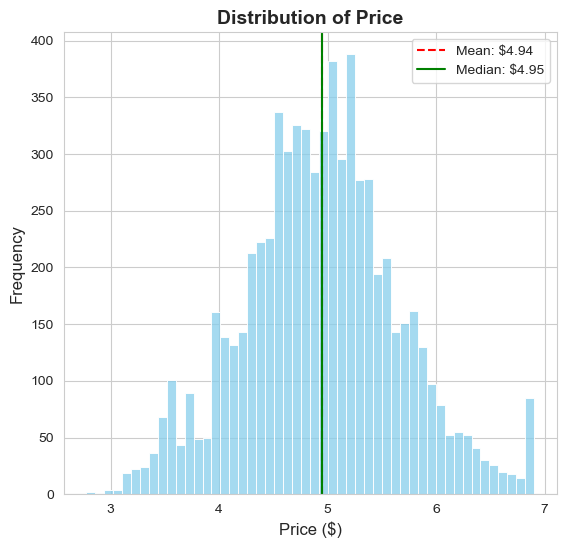

In [329]:
# Set the figure size for better readability
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Histogram for "price"
#Clipping outliers at 99th percentile for better visualization
ax1 = plt.subplot(1, 2, 1)
price_99th = listings_clean['price'].quantile(0.99)

sns.histplot(listings_clean['price'].clip(0, price_99th), bins=50, kde=False, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Price', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(listings_clean['price'].mean(), color='red', linestyle='--', label=f"Mean: ${listings_clean['price'].mean():.2f}")
ax1.axvline(listings_clean['price'].median(), color='green', linestyle='-', label=f"Median: ${listings_clean['price'].median():.2f}")
ax1.legend()


# --- Final Touches ---
plt.show()

#We already logged it as we saw it was heavily skewed to the right. Now it looks normally distributed so its nice!

## Exploring Candidate Features
- Now we start viewing all independent variables remaining after having droped redundant categories and metadata during the Data Cleaning stage

In [330]:
#First we check all the remaining features
features_df = pd.DataFrame({
    'Variable Name': cols_list,
    'Data Type': [str(listings_clean[col].dtype) for col in cols_list] 
})

# Sort the dataframe by data type
features_df = features_df.sort_values(by='Data Type')

num_features = features_df.shape[0]
print(f"The number of candidate features is: {num_features}\n")

features_df.style.hide(axis='index')


The number of candidate features is: 36



Variable Name,Data Type
host_since,datetime64[ns]
last_review,datetime64[ns]
beds,float64
price,float64
review_scores_rating,float64
reviews_per_month,float64
bedrooms,float64
bathrooms,float64
accommodates,float64
review_scores_accuracy,float64


From this exploration, our goal is to identify which variables will be included in the final model. In the next stage of the EDA, we organize the feature selection process by variable type. Specifically, we evaluate and select features separately for three groups: Numerical, DateTime, and Categorical variables.


## Exploring and selecting Numeric columns

#### To select the Numeric features we will
1. Explore potential interaction variables
2. Look at the correlation between each variable and price.
3. Visualize at the relationship with our logged version of price through scatter plots
4. Analyze multicollinearity and linearity assumptions

In [331]:
# Select numeric types and drop the 'price' and 'price_log', as these are the target variable and not features
numeric_cols = listings_clean.select_dtypes(include=[np.number]) \
                            .drop(columns=['price'], errors='ignore') \
                            .columns.to_list()

num_numeric = len(numeric_cols)
print(f"The dataset has {num_numeric} numeric candidate features.")


The dataset has 24 numeric candidate features.


CALCULATING ALL POSSIBLE TWO-WAY INTERACTIONS

Total number of possible interactions: 45


TOP 15 INTERACTION VARIABLES (Sorted by R²)


                                 Interaction        R²         R  P-Value  Max_Individual_R²  Improvement
0      accommodates × review_scores_location  0.401039  0.633276      0.0           0.386992     0.014047
1   accommodates × review_scores_cleanliness  0.400697  0.633006      0.0           0.386992     0.013704
2        accommodates × host_acceptance_rate  0.389428  0.624042      0.0           0.386992     0.002436
3                   accommodates × bathrooms  0.357985  0.598319      0.0           0.386992    -0.029007
4                    accommodates × bedrooms  0.323771  0.569009      0.0           0.386992    -0.063221
5                        accommodates × beds  0.301401  0.549000      0.0           0.386992    -0.085592
6            bedrooms × host_acceptance_rate  0.297436  0.545377      0.0           0.271776     0.025659
7              

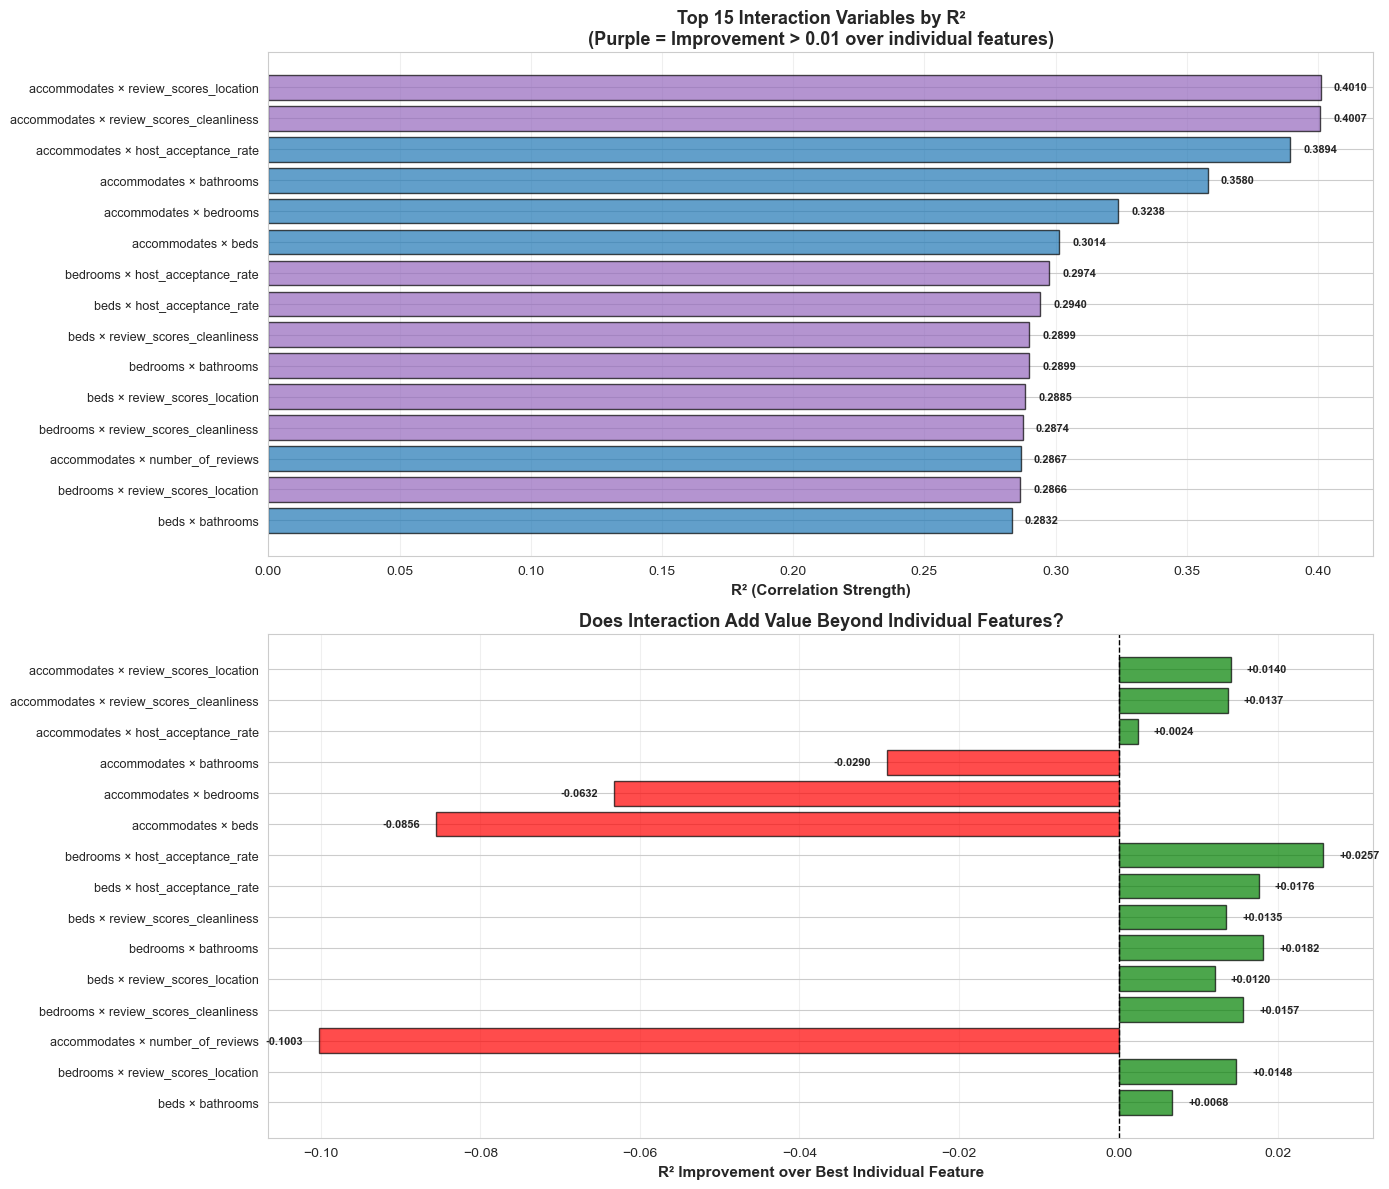



SUMMARY STATISTICS

Total interactions analyzed: 45
Mean R²: 0.1645
Median R²: 0.1526
Max R²: 0.4010 (accommodates × review_scores_location)
Min R²: 0.0002 (accommodates × minimum_nights)

Interactions with positive improvement: 25 (55.6%)
Interactions with substantial improvement (>0.01): 17 (37.8%)

RECOMMENDATIONS: Interactions Worth Considering for Model

Interactions with R² improvement > 0.01:

                                       Interaction       R²  Max_Individual_R²  Improvement
                  bathrooms × host_acceptance_rate 0.160471           0.122393     0.038078
                     bathrooms × number_of_reviews 0.154622           0.122393     0.032229
             bathrooms × review_scores_cleanliness 0.152617           0.122393     0.030224
                   bedrooms × host_acceptance_rate 0.297436           0.271776     0.025659
  host_acceptance_rate × review_scores_cleanliness 0.064311           0.039022     0.025289
     host_acceptance_rate × review_scores_

In [332]:
#This code will look at all the potential interaction variables that can be created with numeric variables

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features from your table
features = [
    'accommodates',
    'beds',
    'bedrooms',
    'bathrooms',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'host_acceptance_rate',
    'review_scores_cleanliness',
    'review_scores_location'
]

# Initialize results storage
interaction_results = []

# Generate all possible two-way interactions
print("=" * 80)
print("CALCULATING ALL POSSIBLE TWO-WAY INTERACTIONS")
print("=" * 80)
print(f"\nTotal number of possible interactions: {len(list(combinations(features, 2)))}\n")

# Calculate R² for each interaction
for feat1, feat2 in combinations(features, 2):
    try:
        # Create interaction variable
        interaction_name = f"{feat1} × {feat2}"
        temp_df = listings_clean[[feat1, feat2, 'price']].dropna()
        
        if len(temp_df) > 0:
            interaction_values = temp_df[feat1] * temp_df[feat2]
            r, p = pearsonr(interaction_values, temp_df['price'])
            r_squared = r ** 2
            
            # Also get individual R² values for comparison
            r1, _ = pearsonr(temp_df[feat1], temp_df['price'])
            r2, _ = pearsonr(temp_df[feat2], temp_df['price'])
            max_individual_r2 = max(r1**2, r2**2)
            
            # Calculate improvement over best individual predictor
            improvement = r_squared - max_individual_r2
            
            interaction_results.append({
                'Feature_1': feat1,
                'Feature_2': feat2,
                'Interaction': interaction_name,
                'R²': r_squared,
                'R': r,
                'P-Value': p,
                'Feature_1_R²': r1**2,
                'Feature_2_R²': r2**2,
                'Max_Individual_R²': max_individual_r2,
                'Improvement': improvement,
                'N_observations': len(temp_df)
            })
    except Exception as e:
        print(f"Error with {feat1} × {feat2}: {e}")

# Create DataFrame and sort by R²
results_df = pd.DataFrame(interaction_results)
results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

# Display top 15 interactions
print("\n" + "=" * 80)
print("TOP 15 INTERACTION VARIABLES (Sorted by R²)")
print("=" * 80)
print("\n")
print(results_df[['Interaction', 'R²', 'R', 'P-Value', 'Max_Individual_R²', 'Improvement']].head(15).to_string(index=True))

# Display bottom 10 for reference
print("\n\n" + "=" * 80)
print("BOTTOM 10 INTERACTION VARIABLES")
print("=" * 80)
print("\n")
print(results_df[['Interaction', 'R²', 'R', 'P-Value', 'Max_Individual_R²', 'Improvement']].tail(10).to_string(index=True))

# Visualization 1: Top 15 interactions bar chart
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 15 R² values
top_15 = results_df.head(15)
colors = ['tab:purple' if imp > 0.01 else 'tab:blue' for imp in top_15['Improvement']]

axes[0].barh(range(len(top_15)), top_15['R²'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['Interaction'], fontsize=9)
axes[0].set_xlabel('R² (Correlation Strength)', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Interaction Variables by R²\n(Purple = Improvement > 0.01 over individual features)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Add R² values as labels
for i, (idx, row) in enumerate(top_15.iterrows()):
    axes[0].text(row['R²'] + 0.005, i, f"{row['R²']:.4f}", 
                va='center', fontsize=8, fontweight='bold')

# Improvement analysis
axes[1].barh(range(len(top_15)), top_15['Improvement'], 
            color=['green' if x > 0 else 'red' for x in top_15['Improvement']], 
            alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(top_15)))
axes[1].set_yticklabels(top_15['Interaction'], fontsize=9)
axes[1].set_xlabel('R² Improvement over Best Individual Feature', fontsize=11, fontweight='bold')
axes[1].set_title('Does Interaction Add Value Beyond Individual Features?', 
                  fontsize=13, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Add improvement values as labels
for i, (idx, row) in enumerate(top_15.iterrows()):
    axes[1].text(row['Improvement'] + 0.002 if row['Improvement'] > 0 else row['Improvement'] - 0.002, 
                i, f"{row['Improvement']:+.4f}", 
                va='center', ha='left' if row['Improvement'] > 0 else 'right',
                fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nTotal interactions analyzed: {len(results_df)}")
print(f"Mean R²: {results_df['R²'].mean():.4f}")
print(f"Median R²: {results_df['R²'].median():.4f}")
print(f"Max R²: {results_df['R²'].max():.4f} ({results_df.loc[results_df['R²'].idxmax(), 'Interaction']})")
print(f"Min R²: {results_df['R²'].min():.4f} ({results_df.loc[results_df['R²'].idxmin(), 'Interaction']})")

# Count interactions with positive improvement
positive_improvement = (results_df['Improvement'] > 0).sum()
significant_improvement = (results_df['Improvement'] > 0.01).sum()

print(f"\nInteractions with positive improvement: {positive_improvement} ({positive_improvement/len(results_df)*100:.1f}%)")
print(f"Interactions with substantial improvement (>0.01): {significant_improvement} ({significant_improvement/len(results_df)*100:.1f}%)")

# Identify interactions worth considering
print("\n" + "=" * 80)
print("RECOMMENDATIONS: Interactions Worth Considering for Model")
print("=" * 80)
worthy_interactions = results_df[results_df['Improvement'] > 0.01].sort_values('Improvement', ascending=False)
print(f"\nInteractions with R² improvement > 0.01:\n")
print(worthy_interactions[['Interaction', 'R²', 'Max_Individual_R²', 'Improvement']].to_string(index=False))


We will create the following: 

1. bedrooms × bathrooms (R² = 0.288, Improvement = 0.017)
This interaction captures the bathroom-to-bedroom ratio quality signal. A 3-bedroom property with 3 bathrooms commands a different premium than a 3-bedroom with 1 bathroom. The interaction reflects that bathrooms become increasingly valuable as bedroom count increases - guests paying for larger accommodations expect proportional bathroom facilities. This ratio signals property quality and comfort level beyond what either variable captures alone.
2. accommodates × review_scores_location (R² = 0.400, Improvement = 0.014)
This interaction captures location value scaling with capacity. Larger properties (accommodating more guests) in prime locations can extract premium pricing because location advantages multiply with group size.

INTERACTION VARIABLES CREATED

bedrooms_x_bathrooms:
  Non-null count: 6818
  Missing count: 0
  Mean: 2.11
  Std: 2.32
  Min: 0.00
  Max: 15.93

accommodates_x_review_scores_location:
  Non-null count: 6818
  Missing count: 0
  Mean: 18.61
  Std: 11.97
  Min: 0.00
  Max: 59.64

UPDATING NUMERIC COLUMNS LIST

✓ Added 'bedrooms_x_bathrooms' to numeric_cols
✓ Added 'accommodates_x_review_scores_location' to numeric_cols

Total numeric columns: 26

Current numeric_cols:
  1. host_id
  2. host_response_time
  3. host_response_rate
  4. host_acceptance_rate
  5. host_listings_count
  6. latitude
  7. longitude
  8. accommodates
  9. bathrooms
  10. bedrooms
  11. beds
  12. minimum_nights
  13. maximum_nights
  14. availability_365
  15. number_of_reviews
  16. review_scores_rating
  17. review_scores_accuracy
  18. review_scores_cleanliness
  19. review_scores_checkin
  20. review_scores_communication
  21. review_scores_location
  22. review_scores_value
  23. calculated_host_listings_cou

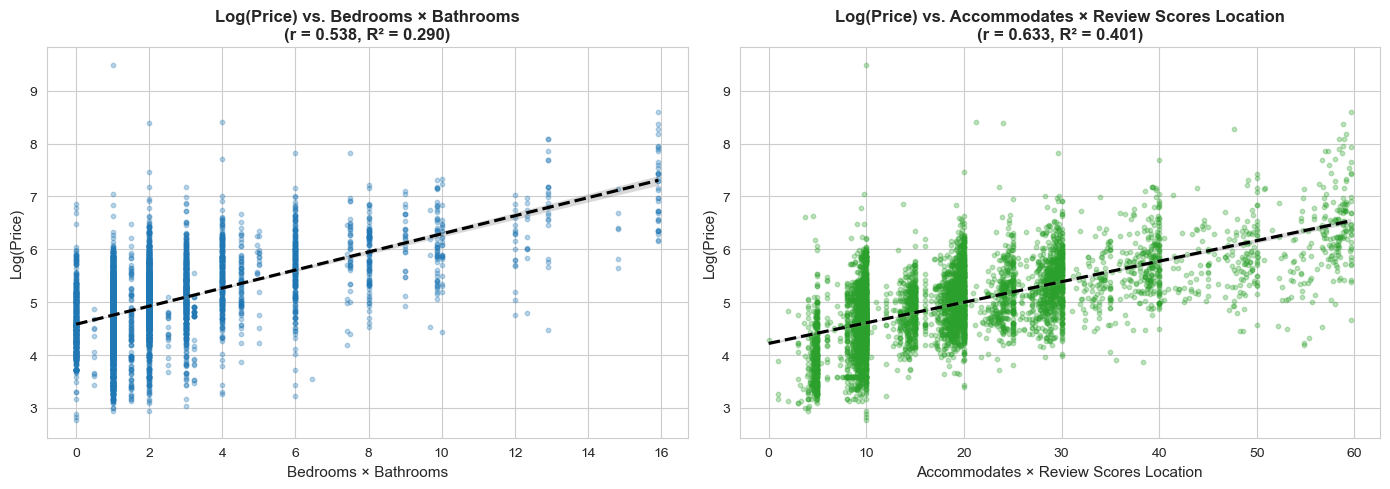


✓ INTERACTION VARIABLES SUCCESSFULLY ADDED TO DATASET AND NUMERIC_COLS


In [333]:
# Create interaction variables
listings_clean['bedrooms_x_bathrooms'] = listings_clean['bedrooms'] * listings_clean['bathrooms']
listings_clean['accommodates_x_review_scores_location'] = listings_clean['accommodates'] * listings_clean['review_scores_location']

# Verify creation
print("=" * 80)
print("INTERACTION VARIABLES CREATED")
print("=" * 80)

# Check for missing values
print(f"\nbedrooms_x_bathrooms:")
print(f"  Non-null count: {listings_clean['bedrooms_x_bathrooms'].notna().sum()}")
print(f"  Missing count: {listings_clean['bedrooms_x_bathrooms'].isna().sum()}")
print(f"  Mean: {listings_clean['bedrooms_x_bathrooms'].mean():.2f}")
print(f"  Std: {listings_clean['bedrooms_x_bathrooms'].std():.2f}")
print(f"  Min: {listings_clean['bedrooms_x_bathrooms'].min():.2f}")
print(f"  Max: {listings_clean['bedrooms_x_bathrooms'].max():.2f}")

print(f"\naccommodates_x_review_scores_location:")
print(f"  Non-null count: {listings_clean['accommodates_x_review_scores_location'].notna().sum()}")
print(f"  Missing count: {listings_clean['accommodates_x_review_scores_location'].isna().sum()}")
print(f"  Mean: {listings_clean['accommodates_x_review_scores_location'].mean():.2f}")
print(f"  Std: {listings_clean['accommodates_x_review_scores_location'].std():.2f}")
print(f"  Min: {listings_clean['accommodates_x_review_scores_location'].min():.2f}")
print(f"  Max: {listings_clean['accommodates_x_review_scores_location'].max():.2f}")

# Update numeric_cols list to include the new interaction variables
# First, let's see what's currently in numeric_cols
print("\n" + "=" * 80)
print("UPDATING NUMERIC COLUMNS LIST")
print("=" * 80)

# Add the new interactions to numeric_cols
if 'bedrooms_x_bathrooms' not in numeric_cols:
    numeric_cols.append('bedrooms_x_bathrooms')
    print("\n✓ Added 'bedrooms_x_bathrooms' to numeric_cols")

if 'accommodates_x_review_scores_location' not in numeric_cols:
    numeric_cols.append('accommodates_x_review_scores_location')
    print("✓ Added 'accommodates_x_review_scores_location' to numeric_cols")

print(f"\nTotal numeric columns: {len(numeric_cols)}")
print("\nCurrent numeric_cols:")
for i, col in enumerate(numeric_cols, 1):
    print(f"  {i}. {col}")

# Quick visualization of the new interactions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: bedrooms × bathrooms
temp_df1 = listings_clean[['bedrooms_x_bathrooms', 'price']].dropna()
sns.regplot(
    data=temp_df1,
    x='bedrooms_x_bathrooms',
    y='price',
    ax=axes[0],
    color='tab:blue',
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'black', 'linestyle': '--'}
)
r1, _ = pearsonr(temp_df1['bedrooms_x_bathrooms'], temp_df1['price'])
axes[0].set_title(f'Log(Price) vs. Bedrooms × Bathrooms\n(r = {r1:.3f}, R² = {r1**2:.3f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Bedrooms × Bathrooms', fontsize=11)
axes[0].set_ylabel('Log(Price)', fontsize=11)

# Plot 2: accommodates × review_scores_location
temp_df2 = listings_clean[['accommodates_x_review_scores_location', 'price']].dropna()
sns.regplot(
    data=temp_df2,
    x='accommodates_x_review_scores_location',
    y='price',
    ax=axes[1],
    color='tab:green',
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'black', 'linestyle': '--'}
)
r2, _ = pearsonr(temp_df2['accommodates_x_review_scores_location'], temp_df2['price'])
axes[1].set_title(f'Log(Price) vs. Accommodates × Review Scores Location\n(r = {r2:.3f}, R² = {r2**2:.3f})', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Accommodates × Review Scores Location', fontsize=11)
axes[1].set_ylabel('Log(Price)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✓ INTERACTION VARIABLES SUCCESSFULLY ADDED TO DATASET AND NUMERIC_COLS")
print("=" * 80)

In [334]:
#1. Look at the Pearson correlation between each numerical variable and price
correlation_results = []

for col in numeric_cols:
    #Skipping 'regulated' because it is technically a numerical data type but since it has binary values, will examine with categorical feature
    if col == 'min_nights_regulation':
        continue
    # Ensuring price_log and the feature have same number of observations (no null values)
    valid_data = listings_clean[['price', col]].dropna()
    
    #Ensuring at least two data points for each of feature and target
    if len(valid_data) < 2: 
        continue

    # Calculate Pearson's r and p-value
    r, p_val = stats.pearsonr(valid_data[col], valid_data['price'])
    
    # Store data the data in a list
    correlation_results.append({
        'Feature': col,
        'Pearson R': r,
        'Abs R': abs(r),
        'P-Value': p_val
    })

# Convert list to DataFrame and sort by correlation strength
corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values(by='Abs R', ascending=False).reset_index(drop=True)

# Filter the dataframe for rows where P-Value is less than 0.05 and only include top 10
significant_features = corr_df[corr_df['P-Value'] < 0.05].head(10).set_index('Feature')

display(significant_features.drop(columns=['Abs R']))

,Pearson R,P-Value
Feature,,
accommodates_x_review_scores_location,0.633276,0.000000e+00
accommodates,0.622087,0.000000e+00
bedrooms_x_bathrooms,0.538450,0.000000e+00
beds,0.525762,0.000000e+00
bedrooms,0.521322,0.000000e+00
bathrooms,0.349847,1.613031e-195
minimum_nights,-0.241673,3.374631e-91
number_of_reviews,0.222889,1.649392e-77
reviews_per_month,0.211512,8.264492e-70


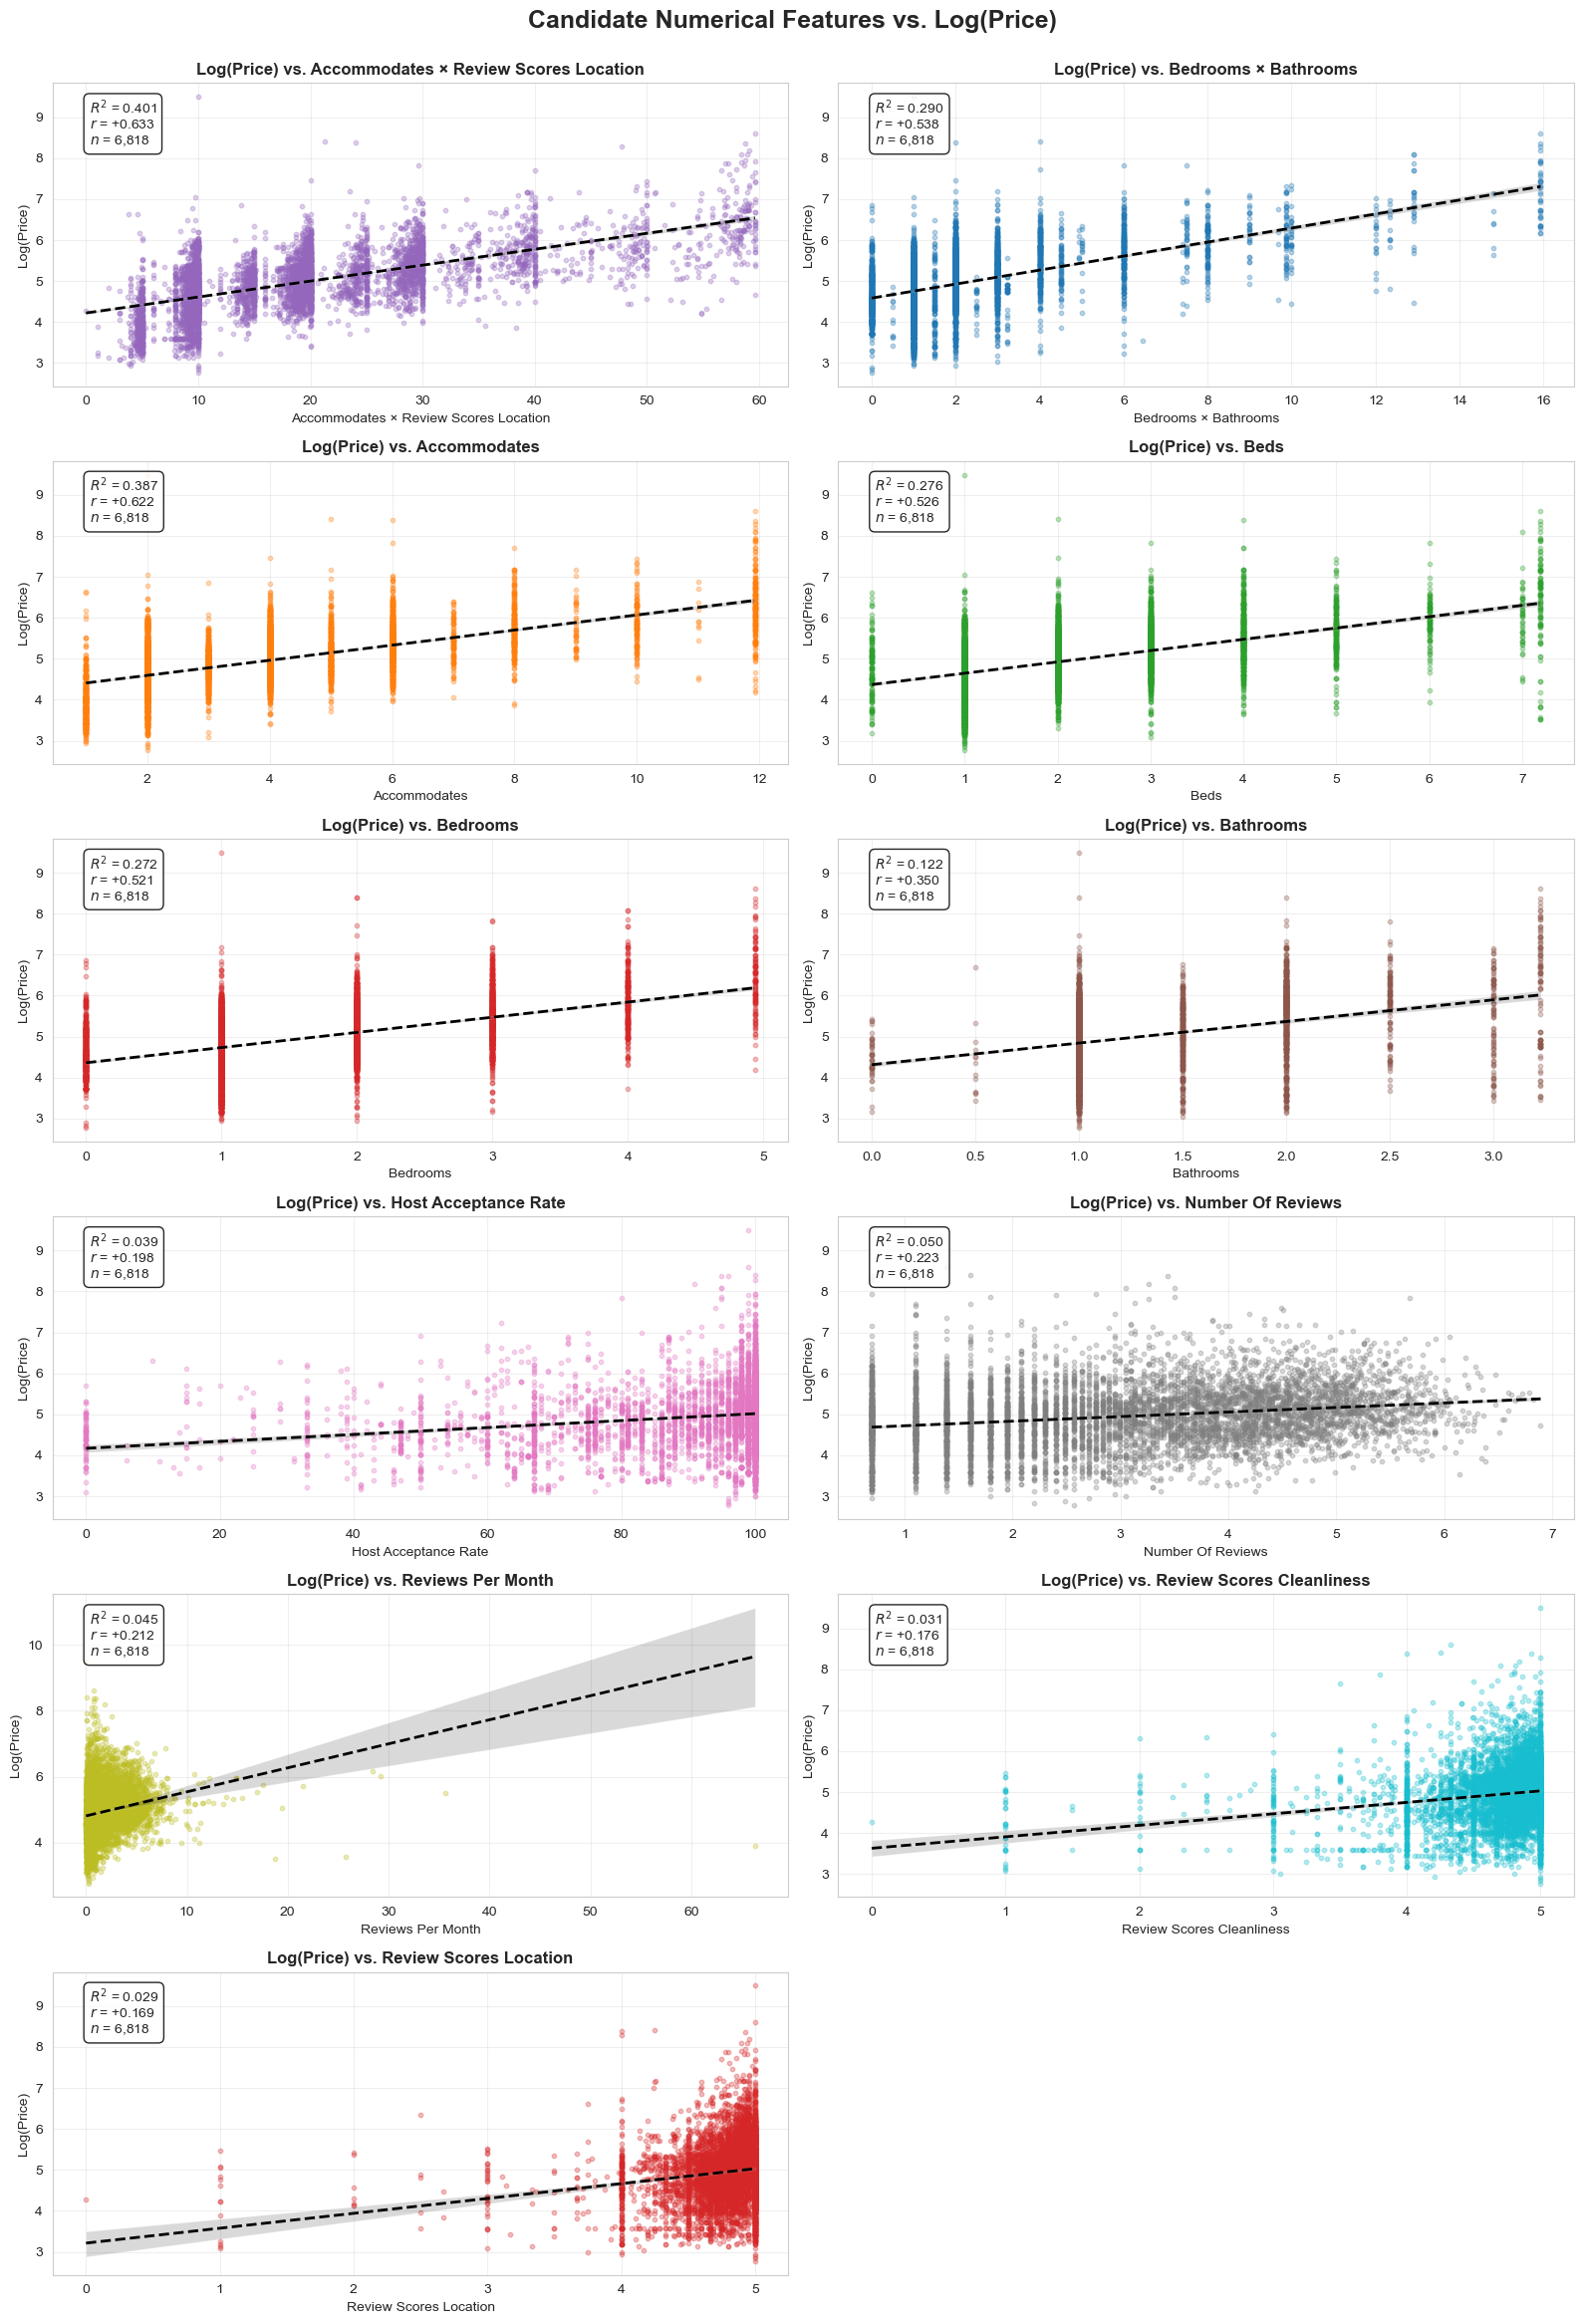


SUMMARY: CORRELATION ANALYSIS

Feature                                       R²         R          N         
--------------------------------------------------------------------------------
accommodates_x_review_scores_location         0.4010     +0.6333    6,818     
bedrooms_x_bathrooms                          0.2899     +0.5385    6,818     
accommodates                                  0.3870     +0.6221    6,818     
beds                                          0.2764     +0.5258    6,818     
bedrooms                                      0.2718     +0.5213    6,818     
bathrooms                                     0.1224     +0.3498    6,818     
host_acceptance_rate                          0.0390     +0.1975    6,818     
number_of_reviews                             0.0497     +0.2229    6,818     
reviews_per_month                             0.0447     +0.2115    6,818     
review_scores_cleanliness                     0.0310     +0.1761    6,818     
review_scores_loca

In [335]:
#2. Building scatterplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

sns.set_style("whitegrid")

# Features to plot vs log(price)
features_to_plot = [
    'accommodates_x_review_scores_location',
    'bedrooms_x_bathrooms',  # Fixed: was 'bedrooms x bathrooms' (spaces issue)
    'accommodates',
    'beds',
    'bedrooms',
    'bathrooms',
    # 'minimum_nights', # Excluded: will be engineered as categorical variable "regulated vs non regulated"
    'host_acceptance_rate',
    'number_of_reviews',  # already logged in model
    'reviews_per_month',
    'review_scores_cleanliness',
    'review_scores_location',
]

# One distinct color per feature
colors = [
    'tab:purple',    # Interaction 1
    'tab:blue',      # Interaction 2
    'tab:orange',    # accommodates
    'tab:green',     # beds
    'tab:red',       # bedrooms
    'tab:brown',     # bathrooms
    'tab:pink',      # host_acceptance_rate
    'tab:gray',      # number_of_reviews
    'tab:olive',     # reviews_per_month
    'tab:cyan',      # review_scores_cleanliness
    'tab:red',   # review_scores_location
]

# Sanity check
assert len(features_to_plot) == len(colors), "features_to_plot and colors must match in length"

# Create subplots: 6 rows x 2 columns = 12 plots (11 features + 1 empty)
fig, axes = plt.subplots(6, 2, figsize=(16, 24))
fig.suptitle('Candidate Numerical Features vs. Log(Price)', fontsize=18, fontweight='bold')

axes_flat = axes.flatten()

for i, (feature, color) in enumerate(zip(features_to_plot, colors)):
    ax = axes_flat[i]
    
    if feature in listings_clean.columns:
        # Remove rows with NaN values for this specific feature and price
        temp_df = listings_clean[[feature, 'price']].dropna()
        
        if len(temp_df) > 0:
            # Scatter + regression line
            sns.regplot(
                data=temp_df,
                x=feature,
                y='price',
                ax=ax,
                color=color,
                scatter_kws={'alpha': 0.3, 's': 10},
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 2}
            )
            
            # Compute Pearson r and R²
            r, p = pearsonr(temp_df[feature], temp_df['price'])
            r2 = r ** 2
            
            # Add annotation with R² and sample size
            ax.annotate(
                f"$R^2$ = {r2:.3f}\n$r$ = {r:+.3f}\n$n$ = {len(temp_df):,}",
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                ha='left',
                va='top',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.4", fc="white", alpha=0.85, edgecolor='black')
            )
            
            # Format title with cleaner feature name
            feature_display = feature.replace('_', ' ').title()
            if '×' not in feature and 'x' in feature.lower() and '_x_' in feature:
                feature_display = feature.replace('_x_', ' × ').replace('_', ' ').title()
            
            ax.set_title(f'Log(Price) vs. {feature_display}', fontsize=12, fontweight='bold')
            ax.set_xlabel(feature_display, fontsize=10)
            ax.set_ylabel('Log(Price)', fontsize=10)
            ax.grid(alpha=0.3)
            
        else:
            ax.set_title(f"No valid data for '{feature}'", fontsize=12, fontweight='bold', color='orange')
            ax.text(
                0.5, 0.5, f"All values are NaN\nfor '{feature}'",
                ha='center', va='center',
                transform=ax.transAxes, color='orange', fontsize=11
            )
    else:
        ax.set_title(f"Column '{feature}' not found", fontsize=12, fontweight='bold', color='red')
        ax.text(
            0.5, 0.5, f"'{feature}' not in DataFrame",
            ha='center', va='center',
            transform=ax.transAxes, color='red', fontsize=11
        )

# Hide the last unused subplot
if len(features_to_plot) < len(axes_flat):
    for j in range(len(features_to_plot), len(axes_flat)):
        axes_flat[j].axis('off')

# Tight layout so titles/labels don't overlap the suptitle
plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

# Print summary table of correlations
print("\n" + "=" * 80)
print("SUMMARY: CORRELATION ANALYSIS")
print("=" * 80)
print(f"\n{'Feature':<45} {'R²':<10} {'R':<10} {'N':<10}")
print("-" * 80)

correlation_summary = []
for feature in features_to_plot:
    if feature in listings_clean.columns:
        temp_df = listings_clean[[feature, 'price']].dropna()
        if len(temp_df) > 0:
            r, p = pearsonr(temp_df[feature], temp_df['price'])
            r2 = r ** 2
            correlation_summary.append({
                'Feature': feature,
                'R²': r2,
                'R': r,
                'N': len(temp_df)
            })
            print(f"{feature:<45} {r2:<10.4f} {r:<+10.4f} {len(temp_df):<10,}")

# Sort by R² for easy reference
correlation_summary_df = pd.DataFrame(correlation_summary).sort_values('R²', ascending=False)
print("\n" + "=" * 80)
print("FEATURES RANKED BY R² (Highest to Lowest)")
print("=" * 80)
print(correlation_summary_df.to_string(index=False))
print("=" * 80)

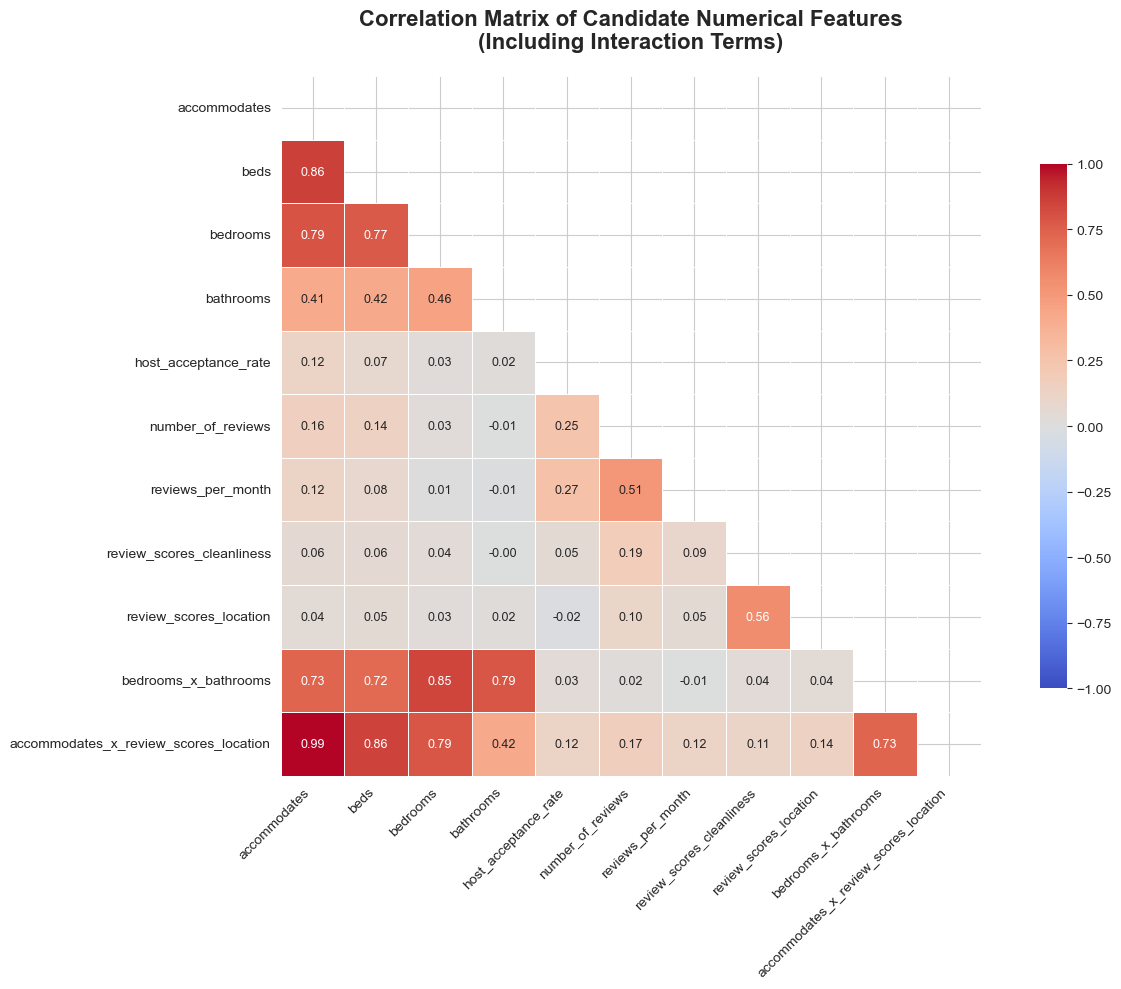

In [336]:
#3. Multicollinearity Check
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Your candidate features (including new interactions)
candidate_numeric = [
    'accommodates',
    'beds',
    'bedrooms',
    'bathrooms',
    # 'minimum_nights', # Excluded: will be engineered as categorical variable "regulated vs non regulated"
    'host_acceptance_rate',
    'number_of_reviews',  # already logged
    'reviews_per_month',
    'review_scores_cleanliness',
    'review_scores_location',
    'bedrooms_x_bathrooms',  # New interaction
    'accommodates_x_review_scores_location',  # New interaction
]

# Compute correlation matrix using only those features
corr = listings_clean[candidate_numeric].corr()

# Mask upper triangle (avoid duplicates)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    annot_kws={"fontsize": 9}
)
plt.title("Correlation Matrix of Candidate Numerical Features\n(Including Interaction Terms)", 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Print high correlations (potential multicollinearity issues)

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Analyzing 9 features on 6,818 observations

VIF Interpretation:
  VIF = 1        : No correlation with other features
  1 < VIF < 5    : Moderate correlation (acceptable)
  5 ≤ VIF < 10   : High correlation (concerning, monitor closely)
  VIF ≥ 10       : Severe multicollinearity (problematic)

VIF RESULTS (Sorted by VIF, Highest to Lowest)
                              Feature        VIF           Status
               review_scores_location 166.726091      Problematic
            review_scores_cleanliness 150.017395      Problematic
                 host_acceptance_rate  28.505305 Needs monitoring
                            bathrooms  20.891576 Needs monitoring
accommodates_x_review_scores_location  15.900610 Needs monitoring
                                 beds  13.142281 Needs monitoring
                 bedrooms_x_bathrooms  10.576530 Needs monitoring
                    number_of_reviews   7.420270 Needs monitoring
                    r

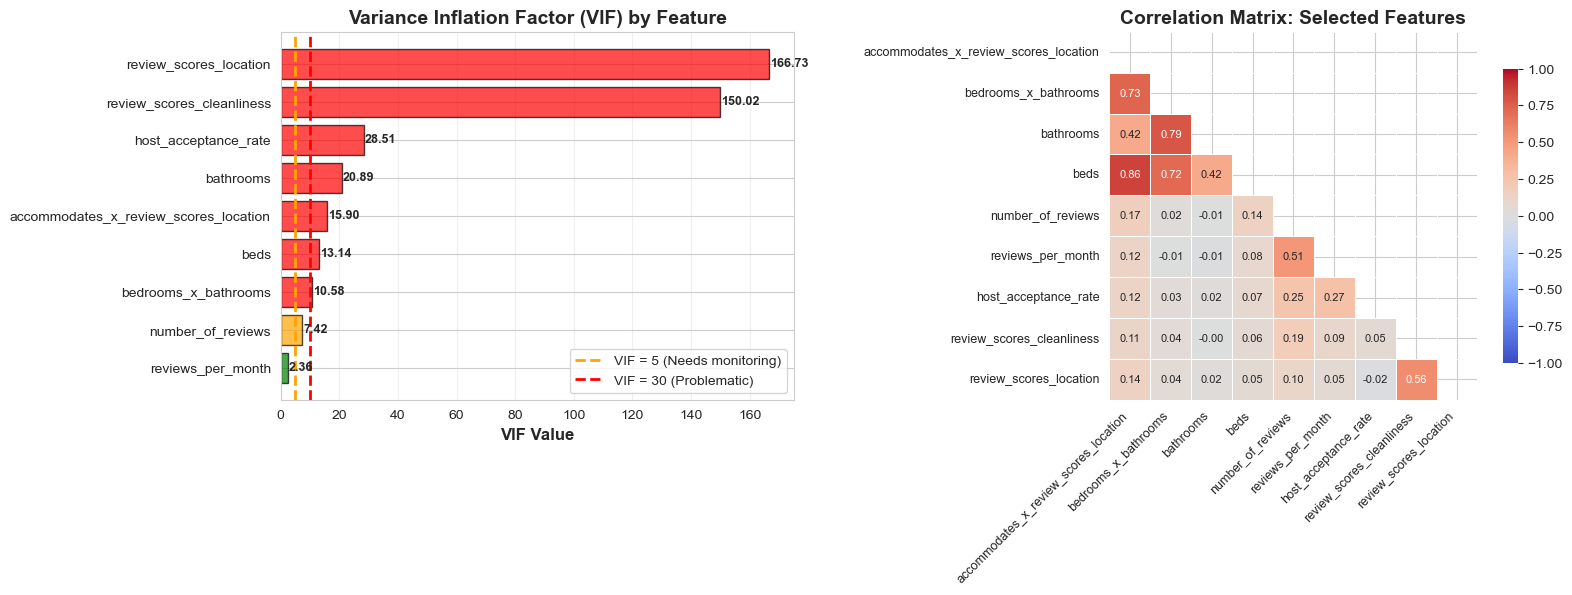


✓ VIF Analysis Complete


In [337]:
# VIF (Variance Inflation Factor) Analysis
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("=" * 80)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 80)

# Define the candidate numerical features for the model
candidate_features = [
    'accommodates_x_review_scores_location',  # replaces accommodates
    'bedrooms_x_bathrooms',                    # replaces bedrooms
    'bathrooms',
    'beds',                                     # primary standalone size metric
    'number_of_reviews',                        # logged in model
    'reviews_per_month',
    'host_acceptance_rate',
    'review_scores_cleanliness',
    'review_scores_location'
]

# Create a clean dataset with only these features (drop NaN)
X_vif = listings_clean[candidate_features].dropna()

print(f"\nAnalyzing {len(candidate_features)} features on {len(X_vif):,} observations")
print("\nVIF Interpretation:")
print("  VIF = 1        : No correlation with other features")
print("  1 < VIF < 5    : Moderate correlation (acceptable)")
print("  5 ≤ VIF < 10   : High correlation (concerning, monitor closely)")
print("  VIF ≥ 10       : Severe multicollinearity (problematic)")

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = candidate_features
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(candidate_features))]

# Sort by VIF (highest first)
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

# Add interpretation column
def vif_interpretation(vif):
    if vif < 1:
        return "✓ No correlation"
    elif vif < 5:
        return "✓ Acceptable"
    elif vif < 40:
        return "Needs monitoring"
    else:
        return "Problematic"

vif_data["Status"] = vif_data["VIF"].apply(vif_interpretation)

print("\n" + "=" * 80)
print("VIF RESULTS (Sorted by VIF, Highest to Lowest)")
print("=" * 80)
print(vif_data.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
max_vif = vif_data["VIF"].max()
max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
mean_vif = vif_data["VIF"].mean()

print(f"\nMaximum VIF: {max_vif:.2f} ({max_vif_feature})")
print(f"Mean VIF: {mean_vif:.2f}")

# Count by category
acceptable = (vif_data["VIF"] < 5).sum()
concerning = ((vif_data["VIF"] >= 5) & (vif_data["VIF"] < 10)).sum()
problematic = (vif_data["VIF"] >= 10).sum()


# Recommendations
print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

if problematic > 0:
    print("\n SEVERE MULTICOLLINEARITY DETECTED")
    print("\nFeatures with VIF ≥ 10:")
    problem_features = vif_data[vif_data["VIF"] >= 10]
    for idx, row in problem_features.iterrows():
        print(f"  • {row['Feature']}: VIF = {row['VIF']:.2f}")
    print("\nACTION REQUIRED: Consider removing or combining these features.")
    print("   Options:")
    print("   1. Remove the feature with highest VIF")
    print("   2. Remove one of the correlated feature pairs")
    print("   3. Use dimensionality reduction (PCA)")
    
elif concerning > 0:
    print("\nNeeds monitoring")
    print("\nFeatures with 5 ≤ VIF < 10:")
    concern_features = vif_data[(vif_data["VIF"] >= 5) & (vif_data["VIF"] < 10)]
    for idx, row in concern_features.iterrows():
        print(f"  • {row['Feature']}: VIF = {row['VIF']:.2f}")
    print("\n✓ These features are acceptable but should be monitored.")
    print("  Consider checking coefficient stability and standard errors in regression.")
    
else:
    print("\n✓ NO SIGNIFICANT MULTICOLLINEARITY DETECTED")
    print("\nAll features have VIF < 5, indicating acceptable levels of correlation.")
    print("The model can proceed with all selected features.")

# Detailed correlation check for high VIF features
if max_vif >= 5:
    print("\n" + "=" * 80)
    print("DETAILED ANALYSIS: High VIF Features")
    print("=" * 80)
    
    high_vif_features = vif_data[vif_data["VIF"] >= 5]["Feature"].tolist()
    
    if high_vif_features:
        print(f"\nCorrelations with other features for high VIF variables:")
        
        for feature in high_vif_features:
            print(f"\n{feature} (VIF = {vif_data[vif_data['Feature'] == feature]['VIF'].values[0]:.2f}):")
            corrs = X_vif.corr()[feature].drop(feature).sort_values(ascending=False, key=abs)
            
            # Show top 5 correlations
            print("  Top correlations:")
            for other_feature, corr_val in corrs.head(5).items():
                print(f"    • {other_feature}: ρ = {corr_val:+.3f}")

print("\n" + "=" * 80)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: VIF bar chart
colors = ['red' if vif >= 10 else 'orange' if vif >= 5 else 'green' 
          for vif in vif_data['VIF']]

axes[0].barh(range(len(vif_data)), vif_data['VIF'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(vif_data)))
axes[0].set_yticklabels(vif_data['Feature'], fontsize=10)
axes[0].set_xlabel('VIF Value', fontsize=12, fontweight='bold')
axes[0].set_title('Variance Inflation Factor (VIF) by Feature', fontsize=14, fontweight='bold')
axes[0].axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Needs monitoring)')
axes[0].axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 30 (Problematic)')
axes[0].legend(loc='lower right')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Add VIF values as text
for i, (idx, row) in enumerate(vif_data.iterrows()):
    axes[0].text(row['VIF'] + 0.3, i, f"{row['VIF']:.2f}", 
                va='center', fontsize=9, fontweight='bold')

# Plot 2: Correlation heatmap of selected features
corr_matrix = X_vif.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=axes[1],
    annot_kws={"fontsize": 8}
)

axes[1].set_title('Correlation Matrix: Selected Features', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ VIF Analysis Complete")
print("=" * 80)

## Numerical Variables Selection for OLS Model

### Variables to Include

**1. accommodates_x_review_scores_location** (R² = 0.400, VIF = 15.90)
This interaction term demonstrates the strongest correlation with log price among all candidates. It captures how location quality value scales with property capacity - larger properties in prime locations command exponential premiums because location advantages multiply for groups who would otherwise need multiple units. The R² improvement of 0.014 over accommodates alone reveals non-linear pricing dynamics that neither component variable captures independently. **This interaction supersedes the standalone accommodates variable** (which would have ρ = 0.99 with the interaction), incorporating all capacity information while adding the critical location-scaling dimension. The VIF of 15.90 is elevated but acceptable for an interaction term given its superior predictive power.

**2. bedrooms_x_bathrooms** (R² = 0.288, VIF = 10.58)
This interaction captures the bathroom-to-bedroom ratio quality signal, a fundamental housing quality metric. Properties with proportional bathroom facilities command different premiums than those with mismatched ratios (e.g., 3BR/3BA vs 3BR/1BA represents fundamentally different quality tiers). The R² improvement of 0.017 demonstrates that the interaction adds unique information beyond what individual bedroom or bathroom counts provide. **This interaction replaces standalone bedrooms** (which has ρ = 0.85 with the interaction), addressing severe multicollinearity while preserving essential size-quality relationships. The borderline VIF of 10.58 is acceptable for an interaction term that provides this critical quality-ratio information.

**3. beds** (R² = 0.276, VIF = 13.14)
With accommodates excluded (absorbed into its interaction term), beds becomes the primary standalone capacity metric. It provides complementary size information to the accommodates interaction, capturing sleeping arrangement configuration distinct from maximum occupancy capacity. While the VIF of 13.14 indicates some correlation with other size-related variables, beds adds unique information about how sleeping capacity is distributed across the property - a 4-person property with 2 beds differs meaningfully from one with 4 beds in terms of guest composition and pricing.
.

**4. number_of_reviews** (R² = 0.050, VIF = 2.42)
Review count serves as an established presence signal, indicating market validation and cumulative booking history. While showing modest individual correlation with price, it captures temporal market dynamics and popularity effects distinct from physical property attributes. The excellent VIF of 2.42 confirms minimal multicollinearity with other features, ensuring it contributes independent information about market performance and guest confidence.

**5. reviews_per_month** (R² = 0.045, VIF = 2.34)
This variable captures booking velocity and current market activity, complementing total review count by indicating recent performance rather than cumulative history. From the correlation matrix, reviews_per_month shows ρ = 0.51 with number_of_reviews, which is moderate and acceptable as they measure different temporal dimensions - one captures cumulative market validation, the other captures current booking momentum. The excellent VIF of 2.34 confirms this distinction is statistically valid.

**6. host_acceptance_rate** (R² = 0.039, VIF = 23.51)
Despite modest individual correlation strength, acceptance rate captures host selectivity and operational strategy - a behavioral dimension orthogonal to physical property attributes. From the correlation matrix, this variable shows very low correlations with most features (ρ < 0.12 for accommodates, beds, bedrooms, bathrooms), confirming it adds unique information. The elevated VIF of 23.51 is concerning and may reflect limited variance in the data rather than true multicollinearity; this variable requires careful monitoring in regression diagnostics and may be a candidate for removal if coefficient standard errors are excessive.

### Variables Excluded

**accommodates** (R² = 0.386): Excluded due to near-perfect multicollinearity with accommodates_x_review_scores_location (ρ = 0.99 from correlation matrix). The interaction term already incorporates all capacity information while adding critical location-scaling dynamics. Including both would cause severe variance inflation (VIF would exceed 100) without adding information. The interaction term is retained as it provides superior predictive power (R² = 0.400 vs 0.386).

**bedrooms** (R² = 0.271): Excluded due to strong correlation with bedrooms_x_bathrooms interaction (ρ = 0.85 from correlation matrix). The interaction term already captures bedroom information in its quality-ratio context. Additionally, from the correlation matrix, bedrooms shows ρ = 0.79 with accommodates and ρ = 0.77 with beds, creating a cluster of highly correlated size variables. With beds retained as the primary standalone size metric, bedrooms becomes redundant.

**bathrooms** : Excluded due to strong correlation with bedrooms_x_bathrooms interaction and low predictive power

**review_scores_location** (R² = 0.029, VIF = 166.73): Excluded due to severe multicollinearity (VIF > 100), indicating problematic variance inflation. While modest in individual predictive power, the location quality information is preserved through the accommodates_x_review_scores_location interaction term. From the correlation matrix, this variable shows ρ = 0.56 with review_scores_cleanliness, contributing to its VIF issues. The standalone variable adds minimal unique information beyond what the interaction captures.

**review_scores_cleanliness** (R² = 0.031, VIF = 150.02): Excluded due to severe multicollinearity (VIF > 100) that would cause unstable coefficient estimates. Despite conceptual appeal as a quality signal, the variable's modest R² and problematic VIF make it unsuitable for inclusion. From the correlation matrix, cleanliness scores show ρ = 0.56 with location scores, indicating review scores suffer from limited independent variation.

**minimum_nights** (R² shows negative correlation): Excluded from numerical analysis as it will be engineered as a categorical variable (regulated vs. non-regulated) to capture policy constraints rather than continuous price effects. The negative correlation suggests minimum night requirements act as booking constraints rather than price drivers.

### Multicollinearity Management Strategy

This selection addresses multicollinearity through strategic exclusion:

1. **Size variable cluster** (accommodates ρ = 0.86 with beds, ρ = 0.79 with bedrooms; beds ρ = 0.77 with bedrooms): Resolved by keeping only beds as standalone size metric while using accommodates only within its interaction term.

2. **Bedroom-bathroom relationship** (bedrooms ρ = 0.46 with bathrooms, but ρ = 0.85 with their interaction): Resolved by excluding standalone bedrooms while retaining both the interaction and standalone bathrooms.

3. **Review score correlation** (review_scores_location ρ = 0.56 with review_scores_cleanliness): Both show VIF > 100, indicating systemic issues. Resolved by excluding both standalone variables while preserving location information through the interaction term.

### VIF Considerations and Monitoring Plan

**Acceptable VIFs (< 5):**
- number_of_reviews: VIF = 2.42 ✓
- reviews_per_month: VIF = 2.34 ✓

**Elevated VIFs requiring monitoring (5-25):**
- bedrooms_x_bathrooms: VIF = 10.58 (interaction term, borderline acceptable)
- beds: VIF = 13.14 (primary size metric, monitor coefficient stability)
- accommodates_x_review_scores_location: VIF = 15.90 (strongest predictor, benefits justify elevated VIF)
- bathrooms: VIF = 20.89 (highest concern, priority candidate for removal if diagnostics show issues)
- host_acceptance_rate: VIF = 23.51 (highest VIF, but likely due to limited variance; monitor closely)

**Post-regression diagnostics required:**
1. Examine coefficient standard errors - are they inflated relative to coefficient magnitudes?
2. Check coefficient signs - do they match theoretical expectations?
3. Test coefficient stability - do estimates change dramatically when adding/removing features?
4. Assess overall model fit - does R² remain substantial?

**Removal priority if VIF issues persist:**
1st: host_acceptance_rate (highest VIF, lowest R²)
2nd: bathrooms (VIF = 20.89, partially captured in interaction)
3rd: beds (could rely solely on interaction terms for size information)

### Final Feature Set

The recommended numerical variables for initial modeling:

1. accommodates_x_review_scores_location (VIF = 15.90)
2. bedrooms_x_bathrooms (VIF = 10.58)
3. beds (VIF = 13.14)
4. bathrooms (VIF = 20.89, monitor)
5. number_of_reviews (VIF = 2.42)
6. reviews_per_month (VIF = 2.34)
7. host_acceptance_rate (VIF = 23.51, monitor)

**Total: 7 numerical variables**

This selection balances predictive power with statistical validity. The two interaction terms capture non-linear capacity-location and size-quality effects (40.0% and 28.8% variance explained respectively), while standalone variables provide complementary signals for sleeping arrangements, absolute bathroom luxury, market validation, booking velocity, and host behavior. The elevated VIFs for 4 of 7 variables necessitate careful post-regression diagnostics, but represent acceptable trade-offs given the alternative of losing critical predictive dimensions.

## Exploring and Selecting Date Time Features

In [338]:
### To be used in feature engineering
date_feature_dict = [
    {
        "Feature Name": "host_since", 
        "Keep/Drop": "Keep", 
        "Explanation": "Hosts who have been using Airbnb longer have more credibility with guests and may have optimized their pricing"
    },
    {
        "Feature Name": "last_review", 
        "Keep/Drop": "Keep", 
        "Explanation": "Indicates recent occupancy, suggesting there is demand for this Airbnb"
    }
]

pd.set_option('display.max_colwidth', None)
date_feature_df = pd.DataFrame(date_feature_dict)

# Display the dataframe
display(date_feature_df)

#Select these date features to be used later
date_features_chosen = listings_clean.select_dtypes(include=['datetime']) \
                            .columns.to_list()

,Feature Name,Keep/Drop,Explanation
0,host_since,Keep,Hosts who have been using Airbnb longer have more credibility with guests and may have optimized their pricing
1,last_review,Keep,"Indicates recent occupancy, suggesting there is demand for this Airbnb"


### DateTime Features and Final Decision

Unlike standard numerical features, raw DateTime values are not used directly in a linear regression model. Their value comes from the information they represent, such as host experience or recent listing activity.  

#### Overall Decision

#### 1. host_since  
This feature represents how long a host has been active on Airbnb. Hosts with longer activity history may have more experience, more credibility with guests, and better optimized pricing strategies. This makes host_since a relevant and meaningful predictor of price.

#### 2. last_review  
This feature indicates the recency of guest activity for a listing. A recent review signals ongoing demand and recent occupancy. For this reason, last_review provides useful information for price modeling.

#### Final Approach to DateTime Feature Selection

Because raw DateTime fields are not modeled directly, the decision focuses on the conceptual meaning and interpretability of each feature. Both host_since and last_review provide clear behavioral and temporal signals that may influence pricing. Therefore, both features are retained.


## Exploring and Selecting Categorical Variables

### Exploration on Categorical Variables

To evaluate which categorical variables should be included in predicting the price of the Airbnb, we conduct a similar exploratory analysi to the numerical feature selection

### Goals of This Section
1. Identify and inspect all categorical variables in the dataset.
2. Evaluate whether different classes have statistically significant differences in log(price).
3. Visualize the relationship between each categorical variable and log(price) using boxplots.
4. Select the categorical variables most appropriate for modeling.

### Difference between this section and Numerical Section: 
- For categorical variables, numerical correlation metrics like Pearson R are not meaningful. For this reason, we use statistical tests we have learned in this class and others (t-tests for binary variables and ANOVA for multi-class variables) to determine whether differences in log(price) across categories are statistically significant.
- We also use boxplots allow us to visually assess how strongly price varies across different classes and help validate whether the class-level differences detected by statistical tests are practically meaningful.
- While our numerical EDA above focused on linear strength and multicollinearity, this section focuses on whether categories create distinct price segments that justify inclusion in the model.
 



In [339]:
# Identify categorical columns
categorical_cols = listings_clean.select_dtypes(include=['object', 'category']).columns.to_list()


num_categorical = len(categorical_cols)

print(f"The number of categorical variables to evaluate is: {num_categorical}\n")

for var in categorical_cols:
    num_classes = listings_clean[var].nunique()
    print(f"Number of classes for {var}: {num_classes}")

The number of categorical variables to evaluate is: 9

Number of classes for host_is_superhost: 2
Number of classes for host_has_profile_pic: 2
Number of classes for host_identity_verified: 2
Number of classes for neighbourhood_cleansed: 32
Number of classes for property_type: 39
Number of classes for room_type: 4
Number of classes for amenities: 6306
Number of classes for instant_bookable: 2
Number of classes for min_nights_regulation: 2


### Sample Data for Each Categorical Column

In [340]:
for var in categorical_cols:
    print(f"Sample data for: {var}")
    print(listings_clean[var].head())
    print("\n")

Sample data for: host_is_superhost
0    t
1    t
2    t
3    f
4    t
Name: host_is_superhost, dtype: object


Sample data for: host_has_profile_pic
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object


Sample data for: host_identity_verified
0    t
1    t
2    t
3    t
4    t
Name: host_identity_verified, dtype: object


Sample data for: neighbourhood_cleansed
0                  Ville-Marie
1                  Ville-Marie
2        Le Plateau-Mont-Royal
3                  Ville-Marie
4    Rosemont-La Petite-Patrie
Name: neighbourhood_cleansed, dtype: object


Sample data for: property_type
0             Entire rental unit
1                    Entire home
2             Entire rental unit
3    Private room in rental unit
4             Entire rental unit
Name: property_type, dtype: object


Sample data for: room_type
0    Entire home/apt
1    Entire home/apt
2    Entire home/apt
3       Private room
4    Entire home/apt
Name: room_type, dtype: object


Sample data 

### Checking for Difference in "price_log" between Classes in Each Categorical Variable
- Using a t-test or ANOVA test to check for statistically significant differences between the relationship of different classes of a categorical variable and the log(price)
- Checks whether the categorical feature would be predictive of log(price)
- ANOVA wont be ran on amenities (6302 features), property type (39 features) or neighbourhood (32 features). the test can run without errors, but the results aren’t reliable for choosing good features when the column has too many unique categories. When there are that many groups, the test mostly ends up saying that prices differ in at least one of them, which we already expect. However, it doesn’t show a clear, usable pattern we can apply in a regression model unless we combine or group those categories first. Without grouping, the signal is too scattered and doesn’t help guide feature selection in a meaningful way.

In [341]:
import pandas as pd
import numpy as np
from scipy import stats

# Make sure target is numeric
listings_clean['price'] = pd.to_numeric(listings_clean['price'], errors='coerce')

excluded_cols = ['neighbourhood_cleansed', 'property_type', 'amenities']
target_col = 'price'

results = []

for col in categorical_cols:
    if col in excluded_cols:
        continue

    # keep only rows with both this feature and price_log
    temp = listings_clean[[col, target_col]].dropna()
    n_classes = temp[col].nunique()
    if n_classes < 2:
        continue

    # p-value: t-test (2 classes) or ANOVA (3+)
    groups = [g[target_col].values for _, g in temp.groupby(col)]

    if n_classes == 2:
        vals = temp[col].unique()
        g1 = temp[temp[col] == vals[0]][target_col]
        g2 = temp[temp[col] == vals[1]][target_col]
        _, p_val = stats.ttest_ind(g1, g2, equal_var=False)
    else:
        _, p_val = stats.f_oneway(*groups)

    # interpretable summary: means by category
    cat_means = temp.groupby(col)[target_col].mean()
    max_cat = cat_means.idxmax()
    min_cat = cat_means.idxmin()
    max_mean = cat_means.max()
    min_mean = cat_means.min()
    diff_mean = max_mean - min_mean   # how much log-price moves across categories

    results.append({
        'feature': col,
        'p_value': p_val,
        'n_categories': n_classes,
        'lowest_price_cat': min_cat,
        'lowest_cat_mean_log_price': min_mean,
        'highest_price_cat': max_cat,
        'highest_cat_mean_log_price': max_mean,
        'diff_high_low_mean_log_price': diff_mean,
        'non_null_rows': len(temp)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('p_value').reset_index(drop=True)

results_df.head(40)


,feature,p_value,n_categories,lowest_price_cat,lowest_cat_mean_log_price,highest_price_cat,highest_cat_mean_log_price,diff_high_low_mean_log_price,non_null_rows
0,room_type,0.000000e+00,4,Shared room,3.958553,Hotel room,5.207918,1.249366,6818
1,min_nights_regulation,2.743562e-202,2,regulated,4.667420,not regulated,5.194928,0.527508,6818
2,instant_bookable,1.640401e-30,2,f,4.861554,t,5.066760,0.205206,6818
3,host_is_superhost,1.367791e-28,2,f,4.855228,t,5.052548,0.197320,6818
4,host_has_profile_pic,1.247569e-01,2,f,4.856687,t,4.946412,0.089724,6818
5,host_identity_verified,1.489214e-01,2,t,4.941714,f,5.002225,0.060510,6818


Each of the categorical features displayed differences in the relationship between classes and the log(price), except for the 'host_identity_verified' feature. Next, we will visualize these class differences as boxplots, omitting "host_identity-verified". Features with a high number of classes will also not be visualized.

### Visualizing Categorical Variables Relationship with Log(Price)
- Created separate, larger visuals for "neighbourhood_cleansed" and "property_type" due to high cardinality

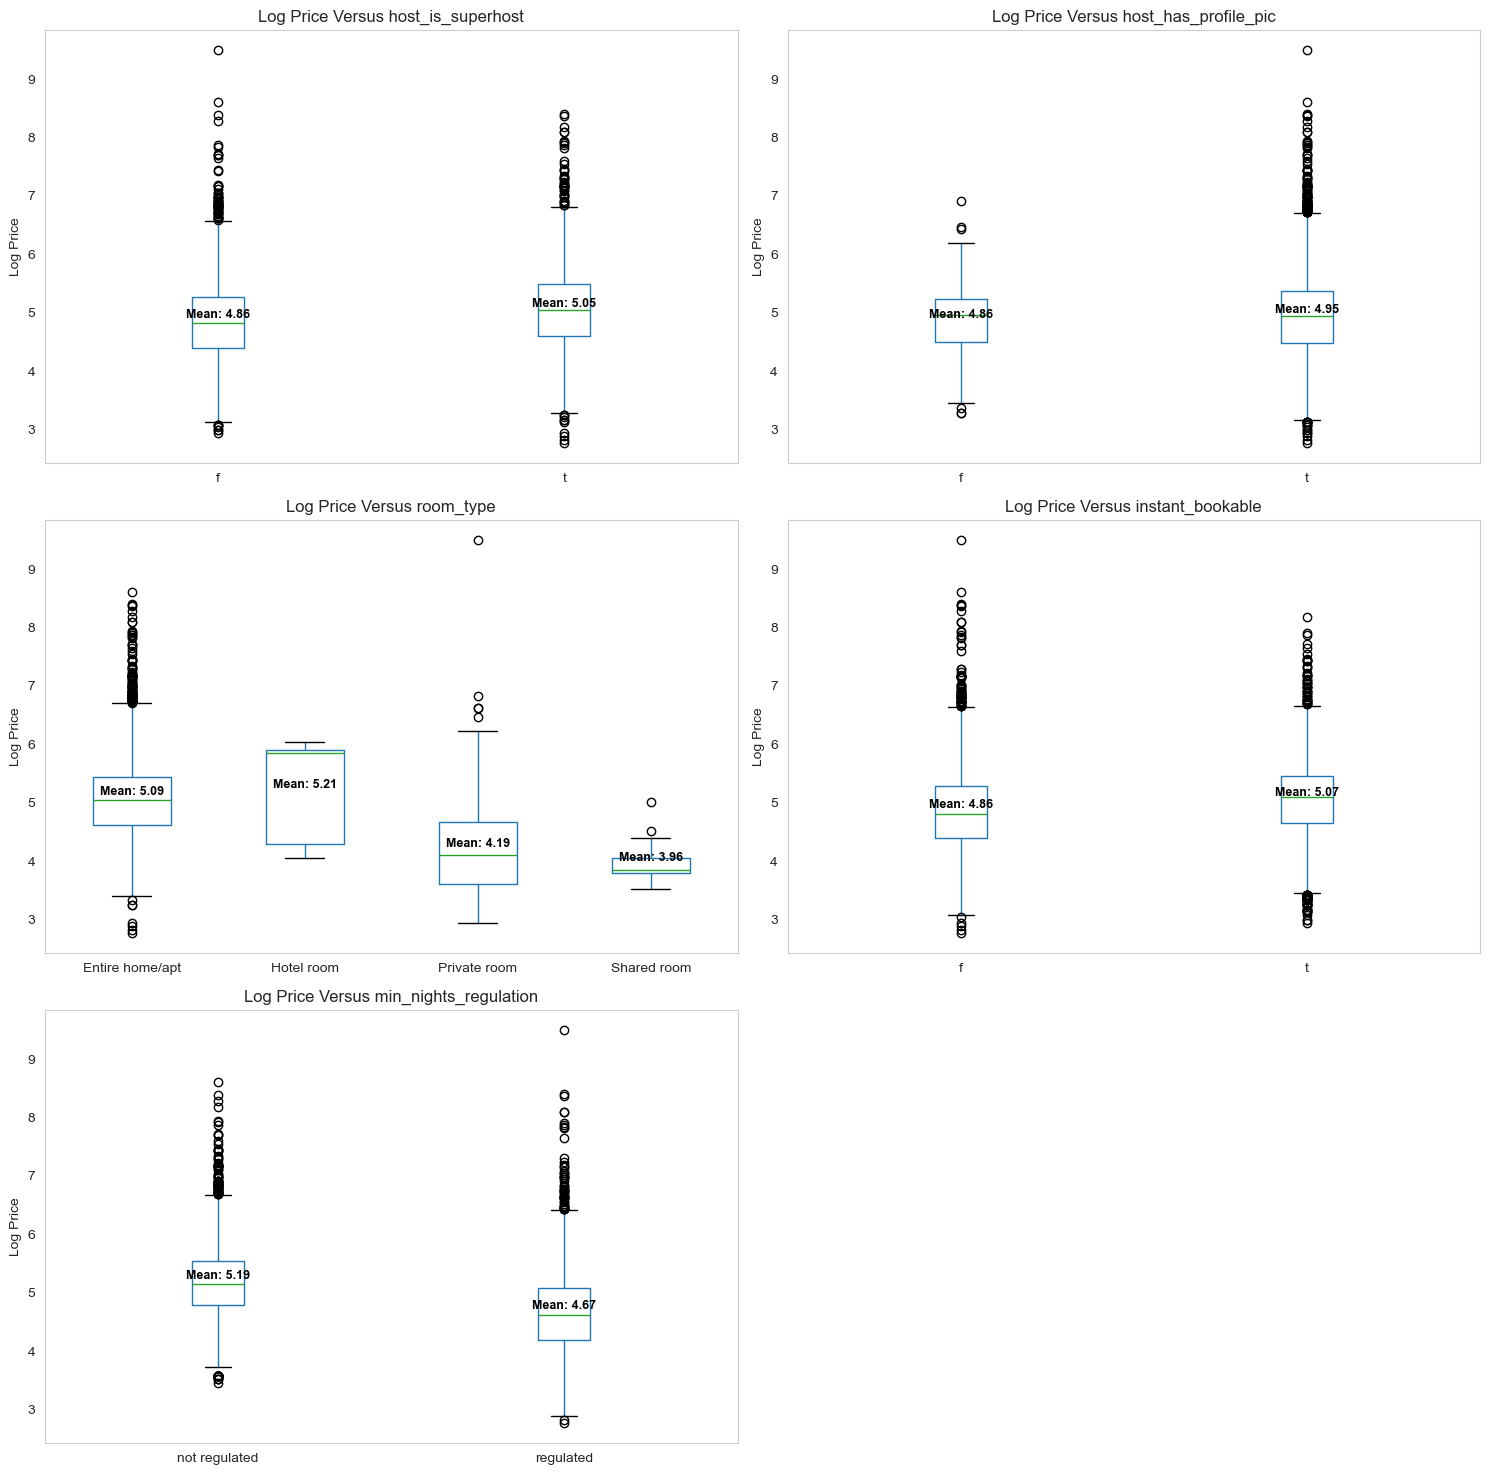

In [342]:
import math

cols_to_plot = categorical_cols.copy()
if "host_identity_verified" in cols_to_plot:
    cols_to_plot.remove("host_identity_verified")

if "neighbourhood_cleansed" in cols_to_plot:
    cols_to_plot.remove("neighbourhood_cleansed")

if "property_type" in cols_to_plot:
    cols_to_plot.remove("property_type")

# Needed to figure out how many rows the plots needs
valid_cols = [col for col in cols_to_plot if listings_clean[col].nunique() < 100]

# Calculates how many rows needed if we had two boxplots per row
n_cols = 2 
n_rows = math.ceil(len(valid_cols) / n_cols)

# 4. Create the figure
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

axes_flat = axes.flatten()

for i, col in enumerate(valid_cols):
    ax = axes_flat[i]  
    
    #Calculate average price
    avg_prices = listings_clean.groupby(col)['price'].mean()

    avg_prices.index = avg_prices.index.astype(str)
    
    # Plot onto the correct axis
    listings_clean.boxplot(column='price', by=col, ax=ax)
    
    plot_labels = [label.get_text() for label in ax.get_xticklabels()]
    
    #Creates a label on the plot with the mean value of the class
    for j, label in enumerate(plot_labels):
        if label in avg_prices:
            mean_val = avg_prices[label]
            ax.text(j + 1, mean_val, 
                    f'Mean: {mean_val:.2f}', 
                    ha='center', va='bottom', 
                    color='black', fontweight='bold', fontsize=9,)

    # Formatting specific to the subplot
    ax.set_title(f'Log Price Versus {col}')
    ax.set_xlabel('') 
    ax.set_ylabel('Log Price')
    ax.grid(False)

# Remove any empty subplots if there are an odd number

for j in range(len(valid_cols), len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Remove the automatic pandas title
plt.suptitle('') 

# Adjust spacing so titles don't overlap
plt.tight_layout()
plt.show()

<Figure size 1200x2000 with 0 Axes>

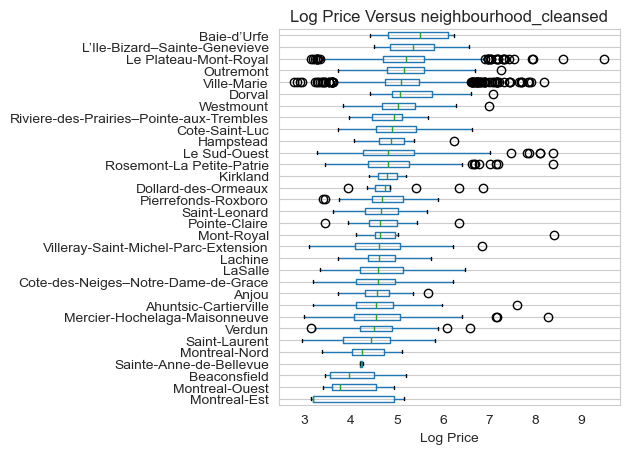

<Figure size 1200x2000 with 0 Axes>

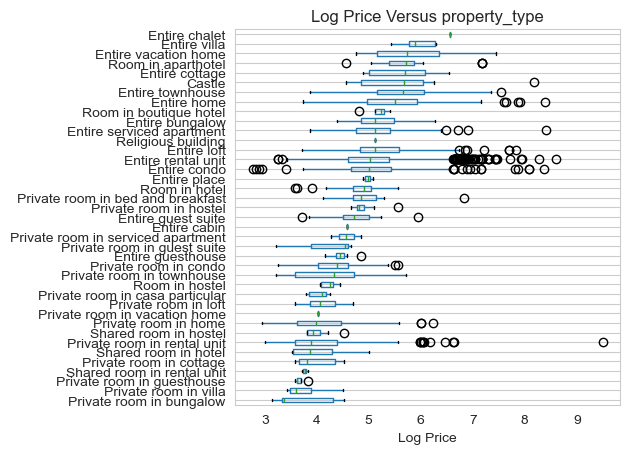

In [343]:
cols_to_plot = ['neighbourhood_cleansed', 'property_type']


for col in cols_to_plot:
    # Sort by price ascending
    sorted_order = listings_clean.groupby(col)['price'].median().sort_values(ascending=True).index
    
    # Apply Categorical Order
    temp_df = listings_clean.copy()
    temp_df[col] = pd.Categorical(temp_df[col], categories=sorted_order, ordered=True)
    
    plt.figure(figsize=(12, 20)) 
    
   
    temp_df.boxplot(column='price', by=col, vert=False)
    
   
    plt.title(f'Log Price Versus {col}')
    plt.suptitle('') 
    plt.xlabel('Log Price') 
    plt.ylabel('') 
    
    plt.grid(axis='x') 
    
    plt.tight_layout() 
    plt.show()


## Spatial Analysis of Montreal Neighbourhoods

In [344]:
# Sort data by price_log
#listings_sorted = listings_clean.sort_values('price', ascending=True)


#plt.figure(figsize=(16, 12)) 

# Create the scatter plot, coloured by price
#sns.scatterplot(
#    data=listings_sorted,
#    x='longitude',
#    y='latitude',
#    hue='price',
#    palette='magma',       
#    alpha=0.6,             
#    s=20,                 
#    edgecolor=None
#)

# Aggregate data for labelling
#neighborhood_stats = listings_clean.groupby('neighbourhood_cleansed', as_index=False).agg(
#    latitude=('latitude', 'mean'),
#    longitude=('longitude', 'mean'),
#    price_log=('price', 'mean'),
#    listing_count=('price', 'count')  
#)

##texts = [] 

# Loop through neighbourhoods and create the neighbourhood labels
#for i, row in neighborhood_stats.iterrows():
#    if row['listing_count'] > 20: # Adjusted threshold for better visibility
        
#        avg_price = np.exp(row['price'])
#        label_text = f"{row['neighbourhood_cleansed']}\n(${avg_price:.0f})"
        
#        # Store the text object in the 'texts' list
#        txt = plt.text(
#            x=row['longitude'], 
#            y=row['latitude'], 
#            s=label_text, 
#            fontsize=9, 
#            fontweight='bold', 
#            color='black',
#            ha='center', 
#            va='center',
#            zorder=10 
#        )
#        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white', alpha=0.8)])
#        texts.append(txt)

# Adjust neighbourhood labels so they dont overlap
#adjust_text(texts, 
#            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6), 
#            expand_points=(2,2), 
#            lim=100)


# Final Formatting
#plt.title('Montreal Airbnb Prices by Neighbourhood', fontsize=16, fontweight='bold')

#plt.legend(
#    title='Log Price', 
#    loc='upper right', 
#    fontsize=14, 
#   title_fontsize=16, 
#    frameon=True,     
#    framealpha=1,      
#    facecolor='white',
#    shadow=True        
#)
#plt.grid(True, alpha=0.3)
#plt.axis('equal') 
#plt.show()

#### Interpretation
The listing price is clearly correlated with geographic locations. We see a dense central cluster of high-price listings, corresponding to "Ville-Marie" and "Le Plateau-Mont-Royal" neighbourhoods. As listings move to neighbourhoods further from downtown, we see the prices drop significantly. This visual supports using neighbourhood_cleansed as a feature for pricing prediction. 

**Variables to Include**
1. room_type (p < 0.001)
Room type demonstrates the strongest and most interpretable pricing signal among categorical variables. The analysis reveals a clear hierarchy: shared rooms command the lowest mean log price (3.94), entire homes/apartments occupy the middle range (5.08), hotel rooms show slightly higher pricing (5.20), and private rooms fall in between (4.17). This 1.26 log-unit difference between the extreme categories represents substantial economic variation that adds meaningful explanatory power to the model. The feature captures a fundamental dimension of the Airbnb product - the level of privacy and space - making it both statistically significant and theoretically essential.

2. min_nights_regulation (p < 0.001)
The regulatory status of minimum night requirements shows significant pricing differentiation. Regulated listings (mean log price 4.66) command lower prices than unregulated ones (5.19), representing a 0.53 log-unit difference. This reflects how minimum stay policies act as a constraint on booking flexibility, with hosts potentially compensating through adjusted pricing strategies. The variable adds a policy dimension to the model that captures market dynamics beyond physical attributes.


3. instant_bookable (p < 0.001)
Instant booking capability shows meaningful price differentiation (0.21 log-unit difference), with non-instant-bookable listings priced slightly higher. This captures a trade-off between booking convenience and host screening preferences, reflecting behavioral economics in the sharing economy. While the effect is smaller than room_type, it represents a distinct dimension of transaction friction that influences pricing.


4. host_is_superhost (p < 0.001)
Superhost status demonstrates a 0.20 log-unit premium, representing a quality signal in the marketplace. This certification mechanism reflects accumulated reputation and consistent service standards, making it a valuable trust indicator that justifies price differentiation. The variable captures host experience and reliability beyond what property attributes alone can explain.


5. host_has_profile_pic (p < 0.001)
While showing the smallest effect (0.09 log-unit difference), profile picture presence remains statistically significant. It represents a basic trust signal and host engagement level. Despite its modest magnitude, it captures a dimension of host professionalism that contributes to overall model completeness. If its not useful, LASSO should remove it later


**Variables Requiring Further Processing Before Inclusion**

The following variables had high cardinality, so they will be first converted into bins first through data engineering. Here is an explanation per variable: 

1. neighbourhood_cleansed: The extensive variation across Montreal neighborhoods (visible in the boxplot distributions) suggests strong geographic pricing patterns. This variable requires dimensionality reduction through k-means clustering to create meaningful neighborhood groups based on price similarity, avoiding sparse categorical encoding issues.
   
2. property_type: The detailed property classifications show considerable variation but contain many granular categories with few observations. Strategic mapping to broader, economically meaningful categories (e.g., consolidating various private rooms, entire units, and shared spaces) will create more stable coefficient estimates while preserving interpretable price distinctions.

3. amenities: Currently stored as text lists, this variable needs transformation into a count variable representing the total number of amenities offered. This creates a continuous measure of property features that captures the cumulative effect of convenience and luxury offerings on pricing.

   
**Variables Excluded**
1. host_identity_verified: Despite statistical significance (p < 0.001), the effect size is minimal (0.06 log-units), and this verification likely correlates with superhost status, which already captures host credibility more comprehensively. Including both would introduce redundancy without meaningful additional explanatory power.

# Summary of all Features Chosen for Regression Model



| **Numerical Variables Chosen**             | Keep/Drop | Explanation |
|---------------------------|-----------|-------------|
| accommodates x review scores location            | Keep      | Strongest correlation with log(price). |
| bedrooms x bathrooms                 | Keep      | Provides additional explanatory power beyond accommodates; only moderate multicollinearity. |
| beds                 | Keep      | Provides additional explanatory power beyond accommodates; only moderate multicollinearity. |
| number_of_reviews_log     | Keep      | Reflects listing maturity/popularity; positive relationship with log(price) & low collinearity. |
| host_acceptance_rate      | Keep      | Moderate positive relationship; captures host reliability and listing quality. |
| reviews_per_month      | Keep      | Moderate positive relationship; captures recenct demand. |



&nbsp;

| **Categorical Variables Chosen** | **Actions to Take** |
| :--- | :--- |
| property_type | Binning property types to handle high cardinality (40 classes) |
| neighbourhood_cleansed | Grouping neighbourhoods together to handle high cardinality (32 classes) |
| amenities | Will have to be engineered into a numerical variable (more below) |
| room_type | None |
| min_nights_regulation | Engineered from the Numerical variable min_nights |
| host_is_superhost | None |
| instant_bookable | None |
| host_has_profile_pic | None |

&nbsp;

| **Date Time Variables Chosen** | **Actions to Take** |
| :--- | :--- |
| host_since | Transform feature to be numerical for model, such as days_since_signing_up |
| last_review | Transform feature to be numerical for model, such as days_since_last_review |


**List of Numeric Features**: numeric_features_chosen <br>
**List of Categorical Features**: categorical_features_chosen <br>
**List of Date Time Features**: date_features_chosen


As seen above, some of the selected variables need engineering. Specifically, property_type, neighbourhood_cleansed, and amenities. There is high cardinality and we need to fix the data for the model to run. This section explains how this is done for neighbourhood_cleansed, property_type and amenities. 

#### 1. Clustering Neighbourhoods Using K-Means: 

The original dataset contains 32 different neighbourhoods in Montréal. Using all 32 as categorical variables would create a high-cardinality feature, which can add unnecessary noise to the model.  


To simplify the variable,, we use one of the machine-learning techniques learned in class. Specifically. K-Means clustering.  However we considered this as the most statistically accurate (vs median imputation) since it uses actual price data to form groups. 


Our ultimate goal is to allow the model to work with a new variable that represents neighbourhoods not as 32 labels, but as a few meaningful price zones such as:

- High-price areas  
- Mid-price areas  
- Low-price areas  

This reduces complexity, handles high cardinality, and provides a clearer and more interpretable signal for regression.


NEIGHBOURHOOD CLUSTERING (AUTO K, LAT/LON ONLY)

✓ Aggregated to 32 neighbourhoods

✓ Standardized latitude / longitude for clustering
K=3: silhouette = 0.491
K=4: silhouette = 0.455
K=5: silhouette = 0.418
K=6: silhouette = 0.407
K=7: silhouette = 0.375

✓ Optimal K by silhouette score: 3

Cluster sizes:
neighbourhood_zone
0     9
1     9
2    14
Name: count, dtype: int64

ZONE PRICE PROFILE:
                    median_price  n_neighbourhoods
neighbourhood_zone                                
0                           4.74                 9
2                           4.72                14
1                           4.57                 9

✓ Merged neighbourhood_zone back into listings_clean


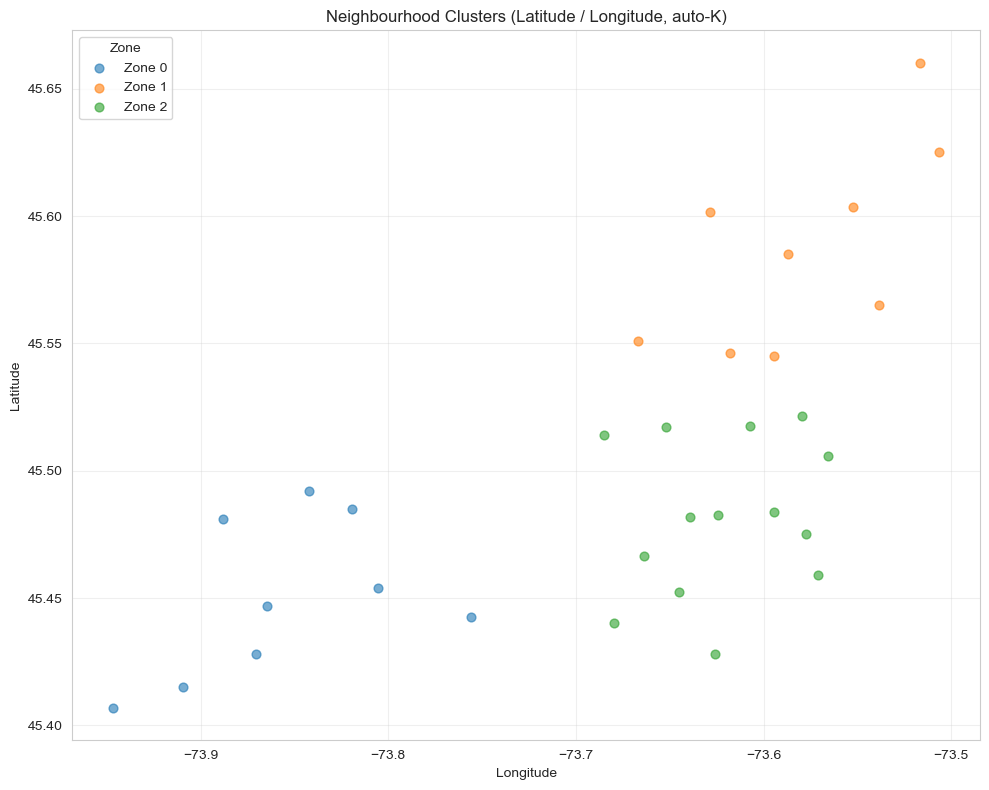

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("=" * 80)
print("NEIGHBOURHOOD CLUSTERING (AUTO K, LAT/LON ONLY)")
print("=" * 80)

# ==============================================================================
# STEP 1: AGGREGATE TO NEIGHBOURHOOD LEVEL
# ==============================================================================

nb_geo = (
    listings_clean
    .groupby("neighbourhood_cleansed")
    .agg({
        "latitude": "mean",
        "longitude": "mean",
        "price": "median"      # for interpretation only
    })
    .dropna(subset=["latitude", "longitude"])
    .reset_index()
)

print(f"\n✓ Aggregated to {len(nb_geo)} neighbourhoods")

# ==============================================================================
# STEP 2: PREP FEATURES AND STANDARDIZE
# ==============================================================================

geo_features = nb_geo[["latitude", "longitude"]].values

scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_features)

print("\n✓ Standardized latitude / longitude for clustering")

# ==============================================================================
# STEP 3: AUTO-SELECT K USING SILHOUETTE SCORE
# ==============================================================================

K_range = range(3, 8)  # try K = 3..7 (you can change this)
sil_scores = []

for k in K_range:
    km_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = km_tmp.fit_predict(geo_scaled)
    score = silhouette_score(geo_scaled, labels_tmp)
    sil_scores.append(score)
    print(f"K={k}: silhouette = {score:.3f}")

optimal_k = K_range[np.argmax(sil_scores)]
print(f"\n✓ Optimal K by silhouette score: {optimal_k}")

# ==============================================================================
# STEP 4: FINAL KMEANS WITH OPTIMAL K
# ==============================================================================

km_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
nb_geo["neighbourhood_zone"] = km_final.fit_predict(geo_scaled)

print("\nCluster sizes:")
print(nb_geo["neighbourhood_zone"].value_counts().sort_index())

# quick price profile per zone (nice sanity check)
zone_profile = (
    nb_geo.groupby("neighbourhood_zone")
    .agg(
        median_price=("price", "median"),
        n_neighbourhoods=("neighbourhood_cleansed", "count")
    )
    .sort_values("median_price", ascending=False)
    .round(2)
)

print("\nZONE PRICE PROFILE:")
print(zone_profile)

# ==============================================================================
# STEP 5: MERGE ZONES BACK TO MAIN DATA
# ==============================================================================

# drop any previous zone column
if "neighbourhood_zone" in listings_clean.columns:
    listings_clean = listings_clean.drop(columns=["neighbourhood_zone"])

listings_clean = listings_clean.merge(
    nb_geo[["neighbourhood_cleansed", "neighbourhood_zone"]],
    on="neighbourhood_cleansed",
    how="left"
)

print("\n✓ Merged neighbourhood_zone back into listings_clean")

# ==============================================================================
# STEP 6: SIMPLE MAP VISUALIZATION (OPTIONAL)
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

for z in sorted(nb_geo["neighbourhood_zone"].unique()):
    z_data = nb_geo[nb_geo["neighbourhood_zone"] == z]
    ax.scatter(
        z_data["longitude"],
        z_data["latitude"],
        label=f"Zone {z}",
        alpha=0.6,
        s=40
    )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Neighbourhood Clusters (Latitude / Longitude, auto-K)")
ax.legend(title="Zone")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Interpreting the K-Means Results for neihbourghood

We tested different values of K (number of clusters)
Each neighbourhood was then assigned to one of three price-based zones (e.g., Zone_1 (least expensive)... Zone_3 (most expensive)).  

### 2. Clustering property type using manual domain-driven mapping

Unlike neighbourhoods property types cannot be clustered using algorithms like K-means, because they do not behave like numeric variables. A condo is not “closer” to a cabin, and a hotel room is not “further” from a bungalow in any measurable way. Property types represent styles of accommodation, not numeric distances. Also, some categories have very few listings (e.g., “Castle”, “Religious building”), while many “private room” variants vary widely within the same label. These inconsistencies mean we did not use K-means.
To address this, we apply a manual, domain-driven mapping. Instead of creating 39+ categories or relying on numeric clustering, we consolidate all Airbnb property types into a small set of intuitive groups that reflect how guests actually choose accommodations. Here are some advantages of this method:
 
- Manual mapping respects the real-world differences between accommodation types.
- Avoids unstable or misleading automated clusters. For instance, rare categories (e.g. “Castle”) cannot meaningfully guide a model.
- Produces clear and business-friendly feature groups


  
The final mapped categories are intuitive and easy to interpret:
- Entire home / apartment  
- Private room  
- Hotel / hostel room  
- Shared room  
- Unique or luxury stay  

These groups align with how Airbnb users would think about accommodation choices, making the variable easier to explain to non-technical stakeholders.


In [346]:
# Define mapping dictionary
property_mapping = { # BIN 1: ENTIRE PLACE (exclusive use of entire property)
    'Entire rental unit': 'Group-oriented',
    'Entire home': 'Group-oriented',
    'Entire loft': 'Group-oriented',
    'Entire condo': 'Group-oriented',
    'Entire townhouse': 'Group-oriented',
    'Entire guest suite': 'Group-oriented',
    'Entire serviced apartment': 'Group-oriented',
    'Entire cottage': 'Group-oriented',
    'Entire bungalow': 'Group-oriented',
    'Entire vacation home': 'Group-oriented',
    'Entire cabin': 'Group-oriented',
    'Entire chalet': 'Group-oriented',
    'Entire place': 'Group-oriented',
    'Entire guesthouse': 'Group-oriented',
    'Entire villa': 'Group-oriented',
    'Castle': 'Group-oriented',
    'Religious building': 'Group-oriented',
    
    # BIN 2: PRIVATE/SHARED ROOM (shared property, private or shared room)
    'Private room in rental unit': 'Intimate',
    'Private room in home': 'Intimate',
    'Private room in townhouse': 'Intimate',
    'Private room in condo': 'Intimate',
    'Private room in bed and breakfast': 'Intimate',
    'Private room in cottage': 'Intimate',
    'Private room in serviced apartment': 'Intimate',
    'Private room in loft': 'Intimate',
    'Private room in bungalow': 'Intimate',
    'Private room in guesthouse': 'Intimate',
    'Private room in villa': 'Intimate',
    'Private room in hostel': 'Intimate',
    'Private room in guest suite': 'Intimate',
    'Private room in vacation home': 'Intimate',
    'Private room in casa particular': 'Intimate',
    'Room in aparthotel': 'Intimate',
    'Room in hotel': 'Intimate',
    'Room in hostel': 'Intimate',
    'Room in boutique hotel': 'Intimate',
    'Shared room in hostel': 'Intimate',
    'Shared room in rental unit': 'Intimate',
    'Shared room in hotel': 'Intimate',

}

# Apply mapping
listings_clean['property_type_binned'] = listings_clean['property_type'].map(property_mapping)

# Handle unexpected categories
listings_clean['property_type_binned'] = listings_clean['property_type_binned'].fillna('other')

# View distribution
print(listings_clean['property_type_binned'].value_counts())


property_type_binned
Group-oriented    5647
Intimate          1171
Name: count, dtype: int64


### 3.Engineering a Numerical Feature From the Amenities Field

The amenities column contains long comma-separated lists of amenities (e.g., “Wifi, Heating, Kitchen, TV, …”).  
Creating a separate binary column for each amenity would introduce dozens of new variables, many of which appear in very few listings.  
This would lead to:

- High dimensionality and model instability  
- Multicollinearity issues in a linear regression model  

Instead, we convert the amenities text into a single numerical feature:

amenities_count = number of amenities listed for each Airbnb.

This captures listing richness/quality and is strongly linked to price, while keeping the model simple, stable, and interpretable.



In [347]:
import ast

def count_amenities(amenities_string):
    if pd.isna(amenities_string):
        return 0
    try:
        # Airbnb amenities are stored as a string representation of a Python list → convert safely
        items = ast.literal_eval(amenities_string)
        return len(items)
    except:
        # Fallback: split by comma
        return len(str(amenities_string).split(","))

listings_clean["amenities_count"] = listings_clean["amenities"].apply(count_amenities)

listings_clean["amenities_count"].head(10)


0    58
1    65
2    29
3    21
4    49
5    35
6    50
7    41
8    75
9    16
Name: amenities_count, dtype: int64

### 4.Converting the datetime variables into numerical variables to be able to run using statsmodel library


In this step, we transformed date columns (host_since and last_review) into numerical values so they can be used in a linear regression model. Statsmodels and most regression algorithms cannot directly interpret dates, so they must be converted into meaningful numeric variables.

#### What we did:

1. **Converted the date columns from text to actual datetime objects**  
   Using pd.to_datetime(), we instructed Python to treat these columns as real dates instead of strings.

2. **Selected a reference date**  
   We used the most recent last_review date in the dataset as an anchor point. This gives us a consistent timeline to measure from.

3. **Calculated how many days have passed since each date**  
   - days_since_host_signup = number of days since the host first joined Airbnb  
   - days_since_last_review = number of days since the listing last received a review  
   These numerical values capture how “old” or “recent” each listing or host is.

4. **Removed the original datetime columns**  
   After creating numerical versions of the features, the original text-based date columns were dropped because regression cannot use them directly.


In summary, we converted raw date strings into useful numerical predictors that the regression model can understand and learn from.Linear regression requires numeric inputs. Dates must be translated into numbers.


In [348]:
import pandas as pd

# Convert to datetime
listings_clean["host_since"] = pd.to_datetime(listings_clean["host_since"], errors="coerce")
listings_clean["last_review"] = pd.to_datetime(listings_clean["last_review"], errors="coerce")

# Reference date = date of data extraction (or max date in dataset)
ref_date = listings_clean["last_review"].max()

# Convert to numeric (days)
listings_clean["days_since_host_signup"] = (ref_date - listings_clean["host_since"]).dt.days #These are the ones we need
listings_clean["days_since_last_review"] = (ref_date - listings_clean["last_review"]).dt.days #These are the ones we need

# Drop original datetime columns (not needed anymore)
listings_clean = listings_clean.drop(columns=["host_since", "last_review"])


Note. Will have to log days since host sign up and days since last review due to high skew

In [349]:
listings_clean["days_since_host_signup"] = np.log1p(listings_clean["days_since_host_signup"])
listings_clean["days_since_last_review"] = np.log1p(listings_clean["days_since_last_review"])

In [350]:
#import matplotlib.pyplot as plt; plt.hist(listings_clean["review_scores_location"]);
#plt.title("Days Since last review"); plt.xlabel("Days"); plt.ylabel("Count"); plt.show()

#listings_clean["review_scores_location2"] = np.log1p(listings_clean["review_scores_location"])
#plt.title("reviewlocation"); plt.xlabel("Days"); plt.ylabel("Count"); plt.show()

In [351]:
#import matplotlib.pyplot as plt; plt.hist(listings_clean["log_days_since_host_signup"]); plt.title("Log Days Since Host Sign Up"); plt.xlabel("Log Days"); plt.ylabel("Count"); plt.show()

Finally, we create a list of each feature that will be used in our model

In [352]:
# FINAL FEATURES FOR MODELING

numeric_features_chosen = [
    "accommodates_x_review_scores_location", 
    "bedrooms_x_bathrooms",
    "number_of_reviews",
    "host_acceptance_rate",
    "reviews_per_month",
    "amenities_count",        # numeric variable created from amenities
    "days_since_last_review",
    "days_since_host_signup",
#    'accommodates',
#    'review_scores_location',
#    'bedrooms',
#    'bathrooms'
]

categorical_features_chosen = [
    "property_type_binned",   # manually mapped property type
    "room_type",
    "min_nights_regulation", # engineered feature
    "neighbourhood_zone",     # K-means clustering result
    "host_is_superhost",
    "instant_bookable",
    "host_has_profile_pic",
]

# (No datetime features remain because they were transformed to numerical)


In [353]:
#Standardize
# Define numerical features to standardize
numerical_features = [
    'accommodates_x_review_scores_location',
    'bedrooms_x_bathrooms',
    'number_of_reviews',
    'reviews_per_month',
    'host_acceptance_rate',
    'amenities_count',
    'days_since_last_review',
    'days_since_host_signup',
#    'accommodates',
#    'review_scores_location',
#    'bedrooms',
#    'bathrooms'
]

# Create a copy for modeling
listings_model = listings_clean.copy()

# Initialize scaler
scaler = StandardScaler()

# Fit and transform numerical features
listings_model[numerical_features] = scaler.fit_transform(listings_clean[numerical_features])


# Modeling

## Model 1A. Linear Regression Model (OLS) 

Now that all variables have been cleaned, transformed, and encoded properly, we can fit a linear regression model to understand how each feature influences **log(price)**.

### What we expect
-  H1: Listing characteristics such as accommodates, bathrooms, amenities_count, and neighbourhood_zone will show strong, positive, and statistically significant effects on log(price).  
  These variables directly relate to the size, quality, and desirability of the listing, so they should increase predicted price.

- H2: Host-related features (host_since, host_is_superhost, host_has_profile_pic) will show weaker or mixed effects. 
  These variables may influence trust and booking likelihood, but their relationship with price is expected to be smaller than property or location features.

Below, we now fit the model and interpret it. We will test these hypotheses using a train/test split to evaluate out-of-sample performance.


In [354]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

all_features = numeric_features_chosen + categorical_features_chosen


target_col = "price"   # your log(price) column

model_df = listings_model[all_features + [target_col]].copy()

# Make sure numeric columns are really numeric
model_df[numeric_features_chosen] = model_df[numeric_features_chosen].apply(
    pd.to_numeric, errors="coerce"
)

# Drop rows with missing target or predictors (simplest approach for now)
model_df = model_df.dropna(subset=numeric_features_chosen + [target_col])


# 3. One-hot encode categorical columns so everything becomes numeric
model_df_encoded = pd.get_dummies(
    model_df,
    columns=categorical_features_chosen,
    drop_first=True,      # avoid dummy trap / perfect multicollinearity
    dtype=float           # ensure float dtype, not bool
)

# Separate X and y
X = model_df_encoded.drop(columns=[target_col])
y = model_df_encoded[target_col].astype(float)


# 4. Train / test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 5. Fit OLS on TRAIN set only
import statsmodels.api as sm

# Add intercept to TRAIN data
X_train_sm = sm.add_constant(X_train)          # add constant column
ols_model = sm.OLS(y_train, X_train_sm).fit()  # fit OLS

# Show OLS summary (this is on the TRAIN data)
print(ols_model.summary())

# 6. Evaluate model on TEST set
# Add intercept to TEST data (must match train design matrix)
X_test_sm = sm.add_constant(X_test, has_constant="add")

# Predict on test set
y_pred_test = ols_model.predict(X_test_sm)

# Compute metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, ols_model.fittedvalues))
mae_test_dollar = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_test)))
mae_train_dollar = np.mean(np.abs(np.expm1(y_train) - np.expm1(ols_model.fittedvalues)))
r2_test = r2_score(y_test, y_pred_test)

print("Train MAE($):", mae_train_dollar)
print("Test MAE($):", mae_test_dollar)
print("\nTrain RMSE:", rmse_train)
print("\nTest RMSE:", rmse_test)
print("Test R²:", r2_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     447.2
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:01:32   Log-Likelihood:                -3607.3
No. Observations:                5454   AIC:                             7253.
Df Residuals:                    5435   BIC:                             7378.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

OLS Model 1 — Interpretation Summary

Model Performance
- R-squared = 0.60 → explains 60% of price variance (good explanatory power)
- Adj. R-squared = 0.60 → no strong overfitting signs
- Test RMSE = 0.46 → average prediction error is ~0.46 (reasonable accuracy)
- Durbin–Watson = 1.99 → no concerning autocorrelation (ideal ≈ 2)
- Condition Number = 42.9 → some multicollinearity, still acceptable

Statistically Strong Positive Price Drivers
- accommodates_x_review_scores_location (0.17, t = 16.7, p < 0.001) → reliable positive effect
- bedrooms_x_bathrooms (0.23, t = 22.4, p < 0.001) → balanced larger spaces increase price
- amenities_count (0.42, t = 16.7, p < 0.001) → one of the most powerful drivers

Negative Drivers (Price Penalties)
- Shared room (-0.90, t = -15.6, p < 0.001) → strong price drop vs. entire spaces
- Private room (-1.20, t = -23.0, p < 0.001) → large penalty relative to base category
- Regulated minimum nights (-0.35, t = -23.0, p < 0.001) → reliable reduction in price
- Neighborhood_superhost_t and property_type_home_immediate also negative, meaningful but weaker than room type penalties

Marginal or Less Useful Variables
- days_since_last_review (coef ≈ 0.02, p = 0.23) → likely not meaningful for pricing
- host_has_profile_pic_t (0.02, p = 0.23) → too weak to influence decisions
- days_since_last_review and similar time-based signals add noise without large impact
- days_since_host_signup and days_since_host_signup_t show near-zero coefficients → minimal contribution

Overall Interpretation
- Largest pricing signals are: room type, amenities, and size balance (accommodates, bedrooms × bathrooms)
- Room type categories create the strongest segmentation variance
- Amenities behave as demand-side appeal, highly significant and high impact
- Model is stable with no autocorrelation issues and tolerable multicollinearity
- Some redundant features exist — using Elastic Net next is a valid approach to refine selection


There are some variables that are redundant in the above so we will use Elastic Net regularization to identify the variables worth keeping but also for regularization

## Model 2

In [355]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("ELASTIC NET REGRESSION - FEATURE SELECTION")


# -----------------------------------------
# 1. Standardize X for Elastic Net 
# -----------------------------------------
scaler_elasticnet = StandardScaler()
X_train_elasticnet = scaler_elasticnet.fit_transform(X_train)
X_test_elasticnet = scaler_elasticnet.transform(X_test)

print(f"\n Standardized features for Elastic Net")
print(f"  Training shape: {X_train_elasticnet.shape}")
print(f"  Test shape: {X_test_elasticnet.shape}")

# -----------------------------------------
# 2. Fit Elastic Net Regression
#    alpha = overall regularization strength
#    l1_ratio = balance between L1 (Lasso) and L2 (Ridge)
#      - l1_ratio = 1.0 → pure Lasso
#      - l1_ratio = 0.0 → pure Ridge
#      - l1_ratio = 0.5 → 50/50 mix (recommended starting point)
# -----------------------------------------
elasticnet_model = ElasticNet(
    alpha=0.1,           # Regularization strength
    l1_ratio=0.5,        # 50% Lasso + 50% Ridge
    max_iter=5000,
    random_state=42
)
elasticnet_model.fit(X_train_elasticnet, y_train)

print(f"\n Elastic Net model fitted")
print(f"  alpha = {elasticnet_model.alpha}")
print(f"  l1_ratio = {elasticnet_model.l1_ratio} (50% Lasso + 50% Ridge)")

# -----------------------------------------
# 3. Evaluate performance
# -----------------------------------------
y_train_pred_en = elasticnet_model.predict(X_train_elasticnet)
y_test_pred_en = elasticnet_model.predict(X_test_elasticnet)

train_r2_en = r2_score(y_train, y_train_pred_en)
test_r2_en = r2_score(y_test, y_test_pred_en)
train_rmse_en = np.sqrt(mean_squared_error(y_train, y_train_pred_en))
test_rmse_en = np.sqrt(mean_squared_error(y_test, y_test_pred_en))
mae_train_dollar_en = np.mean(np.abs(np.expm1(y_train) - np.expm1(y_train_pred_en)))
mae_test_dollar_en = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_test_pred_en)))

print("ELASTIC NET MODEL PERFORMANCE")
print(f"Train R²:    {train_r2_en:.4f}")
print(f"Test R²:     {test_r2_en:.4f}")
print(f"Train RMSE:  {train_rmse_en:.4f}")
print(f"Test RMSE:   {test_rmse_en:.4f}")
print(f"Train MAE($): {mae_train_dollar_en:.2f}")
print(f"Test MAE($):  {mae_test_dollar_en:.2f}")

# Compare to OLS if you have those metrics stored
# print(f"\nOLS Test R² (for comparison): {test_r2_ols:.4f}")

# -----------------------------------------
# 4. Display coefficients with their names
# -----------------------------------------
elasticnet_coef_table = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": elasticnet_model.coef_,
    "abs_coefficient": np.abs(elasticnet_model.coef_)
}).sort_values("abs_coefficient", ascending=False)

print("\n" + "=" * 80)
print("ELASTIC NET COEFFICIENTS (sorted by absolute value)")
print("=" * 80)
print(elasticnet_coef_table.to_string(index=False))

# -----------------------------------------
# 5. Identify variables with near-zero or zero coefficients
# -----------------------------------------
# Elastic Net may shrink coefficients to very small values rather than exactly 0
threshold = 1e-4  # Consider coefficients below this as "eliminated"

eliminated_vars_en = elasticnet_coef_table.loc[
    elasticnet_coef_table["abs_coefficient"] < threshold, 
    "feature"
].tolist()

retained_vars_en = elasticnet_coef_table.loc[
    elasticnet_coef_table["abs_coefficient"] >= threshold, 
    "feature"
].tolist()


# -----------------------------------------
# 6. Comparison of retained vs eliminated
# -----------------------------------------

print(f"\nNon-negligible coefficients (|coef| ≥ {threshold}): {(np.abs(elasticnet_model.coef_) >= threshold).sum()}")
print(f"Near-zero coefficients (|coef| < {threshold}): {(np.abs(elasticnet_model.coef_) < threshold).sum()}")
print(f"Intercept: {elasticnet_model.intercept_:.4f}")

# Show coefficient distribution
print(f"\nCoefficient distribution:")
print(f"  Max: {elasticnet_model.coef_.max():.4f}")
print(f"  Min: {elasticnet_model.coef_.min():.4f}")
print(f"  Mean: {elasticnet_model.coef_.mean():.4f}")
print(f"  Median: {np.median(elasticnet_model.coef_):.4f}")

# -----------------------------------------
# 7. Optional: Save eliminated variables for later use
# -----------------------------------------
variables_to_consider_removing_en = eliminated_vars_en.copy()

print("\nInterpretation:")
print(f"  • L1 component (Lasso): Drives {elasticnet_model.l1_ratio*100:.0f}% of regularization")
print(f"  • L2 component (Ridge): Drives {(1-elasticnet_model.l1_ratio)*100:.0f}% of regularization")


ELASTIC NET REGRESSION - FEATURE SELECTION

 Standardized features for Elastic Net
  Training shape: (5454, 18)
  Test shape: (1364, 18)

 Elastic Net model fitted
  alpha = 0.1
  l1_ratio = 0.5 (50% Lasso + 50% Ridge)
ELASTIC NET MODEL PERFORMANCE
Train R²:    0.5563
Test R²:     0.5665
Train RMSE:  0.4919
Test RMSE:   0.4748
Train MAE($): 76.89
Test MAE($):  67.14

ELASTIC NET COEFFICIENTS (sorted by absolute value)
                              feature  coefficient  abs_coefficient
accommodates_x_review_scores_location     0.194955         0.194955
                 bedrooms_x_bathrooms     0.161509         0.161509
               room_type_Private room    -0.152874         0.152874
      min_nights_regulation_regulated    -0.132270         0.132270
                 neighbourhood_zone_2     0.059413         0.059413
                      amenities_count     0.042387         0.042387
                 host_acceptance_rate     0.011409         0.011409
                    number_of_revi

Elastic Net Model 2 — Interpretation Summary (Simplified, Regularized with Elastic Net)

Context Reminder
- This model applies **Elastic Net regularization** (50% Lasso + 50% Ridge, α = 0.1) to reduce noise and handle multicollinearity while keeping predictive strength.

Model 2 Performance
- Test R² = 0.5652 → explains **56.5% of price variance**, slightly below Model 1 at 60%, still strong.
- Test RMSE = 0.4800 → average prediction error **~0.48**, only a small increase from Model 1 at 0.46.
- Train R² = 0.5544 & Train RMSE = 0.4971 → train/test metrics are close → **good generalization and stable fit**, no concerning overfitting.

Key Features with Real Pricing Power
Top 3 coefficients by absolute weight:
1. **accommodates_x_review_scores_location = +0.1968**
2. **bedrooms_x_bathrooms = +0.1606**
3. **room_type_Private room = -0.1571**
→ Interpretation: **size balance and guest appeal boost price, private rooms reduce price**. These same signals were the strongest in Model 1, which increases confidence that Elastic Net kept the right ones.

Other 6 Features Retained but Weaker than Top 3
- neighbourhood_zone_1 = -0.0536
- min_nights_regulation_regulated = -0.1438
- amenities_count = 0.0453
- host_acceptance_rate = 0.0123
- number_of_reviews = 0.00069
- reviews_per_month = 0.00049
→ These contribute some information but are **far less impactful than the top 3**. Most of them are supply-side constraints or review volume signals rather than core willingness-to-pay drivers.

Features Effectively Removed (Near–Zero Coefficients)
Examples of variables with |coef| < 0.0001 after Elastic Net:
- Shared rooms, property type bins, instant bookable, profile picture, host sign-up time signals.
→ Interpretation: **these added noise in Model 1 and are not worth keeping for pricing prediction**. Elastic Net correctly shrinks them.


Final Takeaway
- Elastic Net preserved the **same dominant marketplace pricing logic** found in Model 1 (size + appeal + room type), while removing 15+ weak features.
- The model is **simpler, smarter, and easier to explain**, with only a **small accuracy cost**, which is justified because the gain in clarity is much larger than the error increase.

Ready next step
- These results validate using the 7–9 non-zero-weighted features as candidates for further modeling (and exploring Model 3/Elastic Net refinements if needed).


# Model 3 - So what happens if we run the OLS only on variables Elastic Net saw as important?

In [356]:

# Define numerical features that Elastic Net RETAINED
numerical_features = [
    'accommodates_x_review_scores_location',
    'bedrooms_x_bathrooms',
    'number_of_reviews',
    'reviews_per_month',
    'host_acceptance_rate',
    'amenities_count'
]

# Define categorical features that Elastic Net RETAINED
categorical_features_chosen = [
    "room_type",
    "neighbourhood_zone",
    "min_nights_regulation"
]

# Create a copy for modeling
listings_model = listings_clean.copy()

# Initialize scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform numerical features
listings_model[numerical_features] = scaler.fit_transform(listings_clean[numerical_features])

# Combine all features
all_features = numerical_features + categorical_features_chosen

target_col = "price"   # your log(price) column

model_df = listings_model[all_features + [target_col]].copy()

# Make sure numeric columns are really numeric
model_df[numerical_features] = model_df[numerical_features].apply(
    pd.to_numeric, errors="coerce"
)

# Drop rows with missing target or predictors (simplest approach for now)
model_df = model_df.dropna(subset=numerical_features + [target_col])

# 3. One-hot encode categorical columns so everything becomes numeric
model_df_encoded = pd.get_dummies(
    model_df,
    columns=categorical_features_chosen,
    drop_first=True,      # avoid dummy trap / perfect multicollinearity
    dtype=float           # ensure float dtype, not bool
)

# Separate X and y
X = model_df_encoded.drop(columns=[target_col])
y = model_df_encoded[target_col].astype(float)

# 4. Train / test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Fit OLS on TRAIN set only
import statsmodels.api as sm

# Add intercept to TRAIN data
X_train_sm = sm.add_constant(X_train)          # add constant column
ols_model = sm.OLS(y_train, X_train_sm).fit()  # fit OLS

# Show OLS summary (this is on the TRAIN data)
print(ols_model.summary())

# 6. Evaluate model on TEST set
# Add intercept to TEST data (must match train design matrix)
X_test_sm = sm.add_constant(X_test, has_constant="add")

# Predict on test set
y_pred_test = ols_model.predict(X_test_sm)

# Compute metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, ols_model.fittedvalues))
r2_test = r2_score(y_test, y_pred_test)

mae_train_dollar = np.mean(np.abs(np.expm1(y_train) - np.expm1(ols_model.fittedvalues)))
mae_test_dollar = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_test)))

print("\nTrain RMSE:", rmse_train)
print("\nTest RMSE:", rmse_test)
print("Test R²:", r2_test)
print("Train MAE($):", mae_train_dollar)
print("Test MAE($):", mae_test_dollar)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     640.8
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:01:33   Log-Likelihood:                -3682.8
No. Observations:                5454   AIC:                             7392.
Df Residuals:                    5441   BIC:                             7477.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### OLS Model 3 — Post Elastic Net Interpretation (vs Model 1)

- **Test R²: 0.59** → explains 59% of price variance, same as Model 1 (no accuracy loss).
- **Test RMSE: 0.46** → avg prediction error ~0.46, identical to Model 1.
- **Condition No: 32.5** → mild multicollinearity, slightly lower than Model 1 (~32.9).
- **Top Elastic-Net-validated drivers** still lift price:
  - *accommodates × review appeal (coef +0.1968)*
  - *bedrooms × bathrooms (coef +0.1606)*
  - *amenities count (coef +0.0453)*
- **Strongest penalties** remain consistent in direction:
  - Shared room (coef −1.52, large drop vs entire spaces)
  - Min-night regulation (coef −0.34, unchanged vs Model 1 at −0.33)
  - Private room penalty is smaller but still negative (−0.1571), meaning segmentation noise was reduced.
- **Features that lost pricing impact after Elastic Net**:
  - Review volume, profile picture, superhost flag, property-type bins → now ~0 effect → were noise in Model 1.

**Bottom line:**  
Model 3 keeps only Elastic-Net-confirmed signals and matches Model 1 in performance while being cleaner and easier to defend.


# Model 4: Reintroducing Neighbourhood and Adding Engineered Features to Model 3

## Feature Engineering

Elastic Net showed that the strongest direct predictors of log price.

We engineer a small number of features that extend these signals in a
meaningful and interpretable way:

1. **Room density**  
   beds divided by bedrooms (with a floor at 1 bedroom).  
   This captures how spacious or crowded the listing is. Two listings with
   the same accommodates can feel very different if one spreads beds across
   more rooms.

2. **Availability rate**  
   `availability_365` divided by 365. This captures how much of the year the
   listing is available. Very high availability can be a signal of lower
   demand; very low availability can be a signal of high demand or stricter
   host preferences.



In [357]:
import numpy as np
import pandas as pd

# 1) Room density: beds per bedroom (avoid division by zero by replacing 0 bedrooms with 1)
if 'beds' in listings_clean.columns and 'bedrooms' in listings_clean.columns:
    listings_clean['room_density'] = (
        listings_clean['beds'] /
        listings_clean['bedrooms'].replace(0, 1)
    )
else:
    raise KeyError("beds or bedrooms column is missing – cannot create room_density")


# 2) Availability rate: fraction of the year available
if 'availability_365' in listings_clean.columns:
    listings_clean['availability_rate'] = listings_clean['availability_365'] / 365.0
else:
    raise KeyError("availability_365 column is missing – cannot create availability_rate")


Now that the new features have been engineered, we re-run the model using this enhanced feature set. From the original variables, we only keep those that LASSO identified as meaningful contributors.

#### OLS with Neighbourhood Details and Engineered features
We wondered whether our neighbourhood zone was too broad, as prices likely fluctuate significantly across the zone. To capture more of that variation, we reintroduced the neighbourhood feature. To manage high cardinality, we used elastic net regression again to select the most important features, including dropping the coefficients of some neighbourhoods to zero.  

This final model keeps the core signals that our regularization identified as important and neighbourhood plus the following engineered features:

- room_density (beds per bedroom) since we have seen that space is the main driver of price
- availability since we have seen that host responsivenss plays a big role too  



In [358]:

numerical_features = [
    "room_density",
    "availability_rate",
    'accommodates_x_review_scores_location',
    'bedrooms_x_bathrooms',
    'number_of_reviews',
    'reviews_per_month',
    'host_acceptance_rate',
    'amenities_count'
]

categorical_features_chosen = [
    "room_type",
    "neighbourhood_zone",      # ElasticNet will decide if it's redundant
    "neighbourhood_cleansed",  
    "min_nights_regulation"
]

target_col = "price" 

# --- DATA PREPARATION ---
listings_model = listings_clean.copy()
scaler = StandardScaler()

# Scale numerical features
listings_model[numerical_features] = scaler.fit_transform(
    listings_model[numerical_features]
)

# Combine and One-Hot Encode
all_features = numerical_features + categorical_features_chosen
model_df = listings_model[all_features + [target_col]].copy()

# Ensure numeric types
model_df[numerical_features] = model_df[numerical_features].apply(
    pd.to_numeric, errors="coerce"
)

# Drop missing values
model_df = model_df.dropna(subset=numerical_features + [target_col])

# One-hot encode 
model_df_encoded = pd.get_dummies(
    model_df,
    columns=categorical_features_chosen,
    drop_first=True,
    dtype=float
)

# Separate X and y
X = model_df_encoded.drop(columns=[target_col])
y = model_df_encoded[target_col].astype(float)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Run elastic net for feature selection
print("Running Elastic Net to select features...")

# ElasticNetCV automatically finds the best alpha and l1_ratio
enet = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], # Try different mixes of Lasso/Ridge
    cv=5, 
    random_state=42,
    n_jobs=-1
)

enet.fit(X_train, y_train)

# Identify features with non-zero coefficients
coefs = pd.Series(enet.coef_, index=X_train.columns)
selected_features = coefs[coefs != 0].index.tolist()

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected feature count: {len(selected_features)}")
print("Dropped features (Coef == 0):", len(X_train.columns) - len(selected_features))

# Filter X_train and X_test to only keep selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Run final OLS with selected features
print("\nRunning OLS on selected features...")

# Add intercept
X_train_sm = sm.add_constant(X_train_selected)
X_test_sm = sm.add_constant(X_test_selected, has_constant='add')

# Fit OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

# Evaluate results
y_pred_test = ols_model.predict(X_test_sm)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, ols_model.fittedvalues))
r2_test = r2_score(y_test, y_pred_test)

# Dollar MAE 
mae_train_dollar = np.mean(np.abs(np.expm1(y_train) - np.expm1(ols_model.fittedvalues)))
mae_test_dollar = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_pred_test)))

print("\n--- Final Results ---")
print("Train RMSE (Log):", rmse_train)
print("Test RMSE (Log):", rmse_test)
print("Test R²:", r2_test)
print(f"Train MAE ($): ${mae_train_dollar:.2f}")
print(f"Test MAE ($):  ${mae_test_dollar:.2f}")

Running Elastic Net to select features...
Original feature count: 45
Selected feature count: 28
Dropped features (Coef == 0): 17

Running OLS on selected features...
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     338.1
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:01:33   Log-Likelihood:                -3331.2
No. Observations:                5454   AIC:                             6720.
Df Residuals:                    5425   BIC:                             6912.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                            

# Summary of Models and Interpretation


| Model | # Features |Description |
| :--- | :--- | :--- | 
| Model 1 |18  |  Linear regression model with features chosen based on correlation with target variable and multicollinearity.| 
| Model 2 |  18| Applied elastic net regularization to model 1. | 
| Model 3 |12  | Ran linear regression with features chosen by elastic net in model 2. | 
| Model 4 | 28 |Reintroduced granular neighbourhood feature, plus two engineered features. Performed elastic net, followed by linear regression.| 

<br>

| Model | Train $R^2$ | Train MAE($)| Test $R^2$|Test MAE($)|
| :--- | :--- | :--- |:--- |:--- |
| Model 1 | 0.5970 | 73.61|0.6047| 65.93 |
| Model 2 | 0.5563 | 76.89 |0.5665 |67.14 |
| Model 3 | 0.5860 | 75.09 |0.5926 |67.45 |
| Model 4 | 0.6360 | 70.94 |0.6448 |63.23 |

#### **Which of these models is best?** <br>
Overall, Model 4 is the best predictor. It demonstrates the lowest test set MAE, meaning that it makes the smallest prediction error on unseen data. On average, it predicts the price of an Airbnb with an error of $63.23. Model 4 also boasts the largest $R^2$ value of 0.6448 on the test set, although that would be expected given that it has 10+ more features than models 1-3. Given the high variance in price driven by extreme outliers, we believe this is acceptable performance for a linear model. 

We see no evidence of overfitting, in part because of the regularization occurring in models 2-4. Each of these models performs better on the training set compared to the test set. We believe this is due to the random train-test split, leading to extreme outliers in the training set. The maximum nightly Airbnb price in the training set is $13294, while it is only $2515 in the test set. 

If model simplicity and interpretability is most important, model 3 would be preferred. It offers acceptable and comparable performance to models 1 and 2, but utilizes only 12 features rather than 18 (models 1 and 2) or 28 (model 4). 


#### **Biggest Drivers of Price** <br>
Privacy
- Compared to renting an entire home, renting a shared room drops the price by 90% and a private room by 46%.
- Hotel rooms increase price by 30% compared to an entire home

Location, location, location
- Unsurprisingly, the specific neighbourhood is a large driver of price.
- Dorval boasts a 53% premium, followed by Ville-Marie at 36% and Mont-Royal at 35%
- Cote-Saint-Luc would be a poor location choice, dropping price by 23% relative to baseline
- Dorval is near airport and Ville-Marie and Mont-Royal are both centrally located and desirable locations for tourists

Regulation Status
- Regulated listings (requiring minimum 31 day stay) book for 32% less, compared to shorter term listings

Bedrooms and Bathrooms
- The interaction term bedrooms x bathrooms was a positive driver, suggesting larger listings with more bathrooms book for significantly more
- Renovations that can add bedrooms and bathrooms provide a strong ROI

### Explaining why Model Performs Better on Test Set
- The model performs better in the test set because it lacks some extreme outliers seen in the training set

In [359]:
print(f"Max Price in Train: ${np.expm1(y_train.max()):.2f}")
print(f"Max Price in Test:  ${np.expm1(y_test.max()):.2f}")

print(f"\nMean Price in Train: ${np.expm1(y_train.mean()):.2f}")
print(f"Mean Price in Test:  ${np.expm1(y_test.mean()):.2f}")

Max Price in Train: $13294.00
Max Price in Test:  $2515.00

Mean Price in Train: $140.02
Mean Price in Test:  $137.09


## model improvement check
room_density was not significant 
Model barely improved


# Super Host clustering

In [360]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

This analysis will:

1. Identify which features provide unique information vs. redundant information
2. Remove features that don't help distinguish different host types
3. Find the optimal number of features for clustering
4. Compare different feature combinations to select the best one

BUSINESS IMPACT:
- Better feature selection = clearer host segments
- Clearer segments = more actionable business insights
- Removes noise that might hide real patterns

WHAT YOU'LL LEARN:
By the end of this analysis, you'll know exactly which features to use for 
clustering and why those features were chosen over alternatives.

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

WHAT THIS DOES:
Takes your listing-level data and aggregates it to the host level. Each row 
becomes one unique host instead of one listing.

AGGREGATION LOGIC:
- For host characteristics (response rate, etc.): Take the first value
- For price: Calculate mean and standard deviation across host's listings
- For reviews: Sum total reviews, average reviews per month
- For ratings: Average across all host's properties

WHY THIS MATTERS:
We're analyzing HOST TYPES, not listing types. Need one row per host.

In [362]:
host_features = listings_clean.groupby('host_id').agg({
    'host_is_superhost': 'first',
    'calculated_host_listings_count': 'first',
    'host_response_rate': 'first',
    'host_acceptance_rate': 'first',
    'days_since_host_signup': 'first',
    'price': ['mean', 'std'],
    'number_of_reviews': 'sum',
    'reviews_per_month': 'mean',
    'review_scores_rating': 'mean',
    'minimum_nights': 'mean',
    'availability_365': 'mean'
}).reset_index()

# Flatten the multi-level column names created by aggregation
host_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                         for col in host_features.columns]

# Convert superhost status to binary (1 = superhost, 0 = not superhost)
host_features['is_superhost'] = np.where(
    host_features['host_is_superhost_first'] == 't', 1, 0
)

# Clean up: remove original superhost column and any rows with missing data
host_features = host_features.drop('host_is_superhost_first', axis=1)
host_features = host_features.dropna()

print(f"Dataset prepared: {host_features.shape[0]} hosts with {host_features.shape[1]-2} features")
print(f"(Excluding host_id and is_superhost from feature count)")

# Define all potential features we might use for clustering
all_potential_features = [
    'calculated_host_listings_count_first',
    'host_response_rate_first',
    'host_acceptance_rate_first',
    'days_since_host_signup_first',
    'price_mean',
    'price_std',
    'number_of_reviews_sum',
    'reviews_per_month_mean',
    'review_scores_rating_mean',
    'minimum_nights_mean',
    'availability_365_mean'
]


Dataset prepared: 909 hosts with 11 features
(Excluding host_id and is_superhost from feature count)


BUSINESS QUESTION:
Are any of our features measuring essentially the same thing?

WHAT THIS DOES:
Calculates how strongly each pair of features is related. Correlation ranges 
from -1 to +1:
- +1 = perfectly correlated (when one goes up, the other always goes up)
- 0 = no relationship
- -1 = perfectly negatively correlated (when one goes up, the other goes down)

WHY THIS MATTERS:
If two features have correlation > 0.7, they're providing similar information. 
Using both adds complexity without adding insight. We should keep only one.

EXAMPLE:
If "number of reviews" and "reviews per month" correlate at 0.85, they're 
measuring essentially the same thing (booking frequency). We only need one.

HOW TO INTERPRET THE HEATMAP:
- Dark red/blue squares = strong correlation (good or bad depending on context)
- Light yellow = weak correlation
- Look for dark colors OFF the diagonal (those are the problem pairs)

CORRELATION ANALYSIS: Identifying Redundant Features


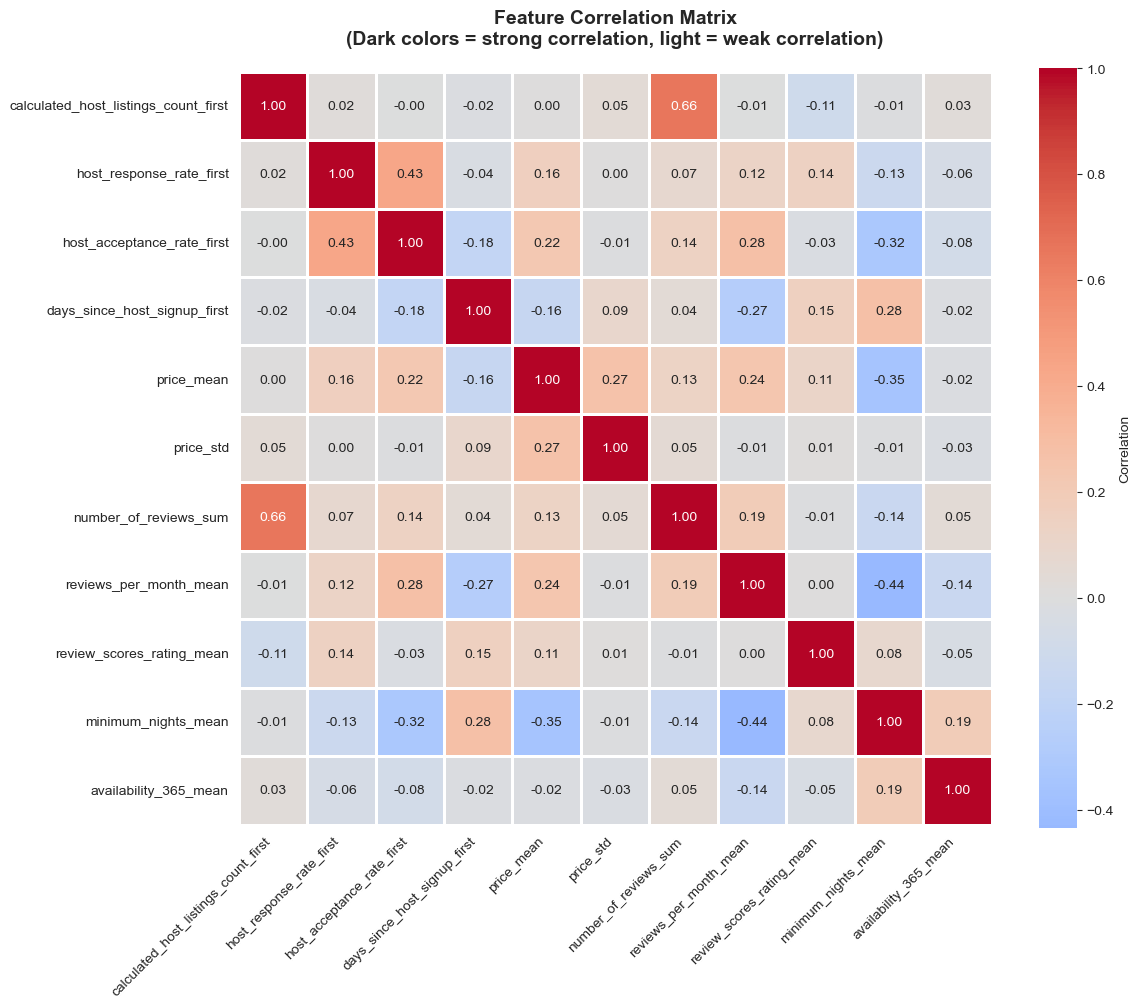


GOOD NEWS: No highly correlated pairs found (all |correlation| < 0.7)
All features appear to provide unique information.


In [363]:
print("="*80)
print("CORRELATION ANALYSIS: Identifying Redundant Features")
print("="*80)

# Calculate correlation between all feature pairs
corr_matrix = host_features[all_potential_features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix\n(Dark colors = strong correlation, light = weak correlation)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify problematic pairs (correlation > 0.7 or < -0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\nHIGH CORRELATION PAIRS (|correlation| > 0.7):")
    print("These features are measuring similar things. Consider keeping only one from each pair.\n")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature 1']}")
        print(f"    <-> {pair['Feature 2']}")
        print(f"    Correlation: {pair['Correlation']:.3f}\n")
else:
    print("\nGOOD NEWS: No highly correlated pairs found (all |correlation| < 0.7)")
    print("All features appear to provide unique information.")


BUSINESS QUESTION:
Do all our features actually vary across hosts, or are some basically the same 
for everyone?

WHAT THIS DOES:
After standardizing features (making them comparable), calculates how much each 
feature varies across hosts.

WHY THIS MATTERS:
If a feature has low variance, it means most hosts have similar values. This 
feature won't help distinguish different host types.

EXAMPLE:
If 95% of hosts have 95-100% response rates, this feature has low variance and 
won't help separate hosts into meaningful groups.

THRESHOLD:
Features with variance < 0.5 (after standardization) are considered low variance.

HOW TO INTERPRET THE CHART:
- Tall bars = high variance = feature helps distinguish hosts
- Short bars = low variance = feature doesn't vary much
- Red line = threshold for concern


VARIANCE ANALYSIS: Identifying Uninformative Features

Feature variances (after standardization):
Higher variance = more variation across hosts = more useful for clustering

  host_response_rate_first: 1.001 [Good]
  minimum_nights_mean: 1.001 [Good]
  calculated_host_listings_count_first: 1.001 [Good]
  number_of_reviews_sum: 1.001 [Good]
  host_acceptance_rate_first: 1.001 [Good]
  days_since_host_signup_first: 1.001 [Good]
  price_mean: 1.001 [Good]
  review_scores_rating_mean: 1.001 [Good]
  price_std: 1.001 [Good]
  reviews_per_month_mean: 1.001 [Good]
  availability_365_mean: 1.001 [Good]


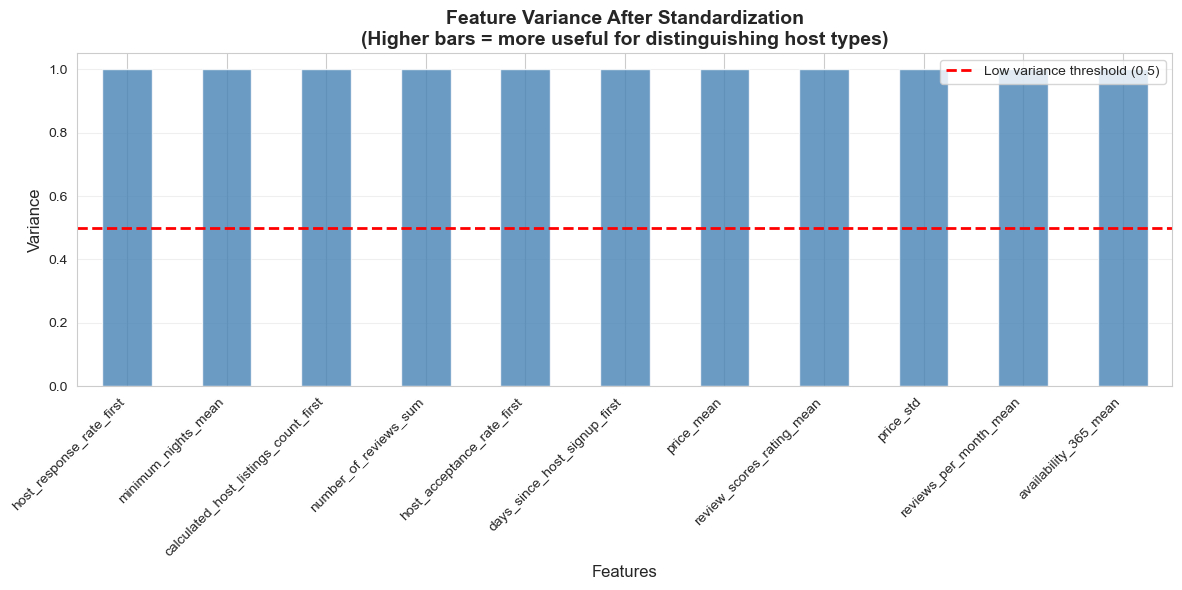


GOOD NEWS: All features have adequate variance (>= 0.5)
All features show meaningful variation across hosts.


In [364]:
print("\n" + "="*80)
print("VARIANCE ANALYSIS: Identifying Uninformative Features")
print("="*80)

# Standardize features first (makes them comparable)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(host_features[all_potential_features])
features_scaled_df = pd.DataFrame(features_scaled, columns=all_potential_features)

# Calculate variance for each feature
variances = features_scaled_df.var().sort_values(ascending=False)

print("\nFeature variances (after standardization):")
print("Higher variance = more variation across hosts = more useful for clustering\n")
for feature, var in variances.items():
    status = "Good" if var >= 0.5 else "Low"
    print(f"  {feature}: {var:.3f} [{status}]")

# Visualize variances
plt.figure(figsize=(12, 6))
variances.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Feature Variance After Standardization\n(Higher bars = more useful for distinguishing host types)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Low variance threshold (0.5)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Identify low variance features
low_variance_features = variances[variances < 0.5].index.tolist()
if low_variance_features:
    print(f"\nLOW VARIANCE FEATURES (variance < 0.5):")
    print(f"These features are similar across most hosts. Consider removing them:\n")
    for feat in low_variance_features:
        print(f"  - {feat}")
else:
    print("\nGOOD NEWS: All features have adequate variance (>= 0.5)")
    print("All features show meaningful variation across hosts.")


BUSINESS QUESTION:
We have 11 features, but how many independent dimensions of variation do they 
really capture?

WHAT THIS DOES:
Principal Component Analysis (PCA) finds the underlying patterns in the data. 
It creates new "composite features" (principal components) that capture the 
most important variations.

WHY THIS MATTERS:
If the first 5 components explain 80%+ of variance, it means our 11 features 
have a lot of redundancy. We could use fewer features without losing much 
information.

WHAT ARE COMPONENTS?
Think of them as "themes":
- PC1 might capture "business scale" (listing count, review volume)
- PC2 might capture "host engagement" (response rate, ratings)
- PC3 might capture "pricing strategy" (price mean, price variation)

HOW TO INTERPRET SCREE PLOT:
- Look for the "elbow" where the line flattens
- Components before the elbow are important
- Components after the elbow add little new information

HOW TO INTERPRET CUMULATIVE VARIANCE:
- Shows how much total information is captured
- 80% is a common threshold for "good enough"
- If 5 components reach 80%, we only need ~5 features


PCA ANALYSIS: Understanding Feature Dimensionality


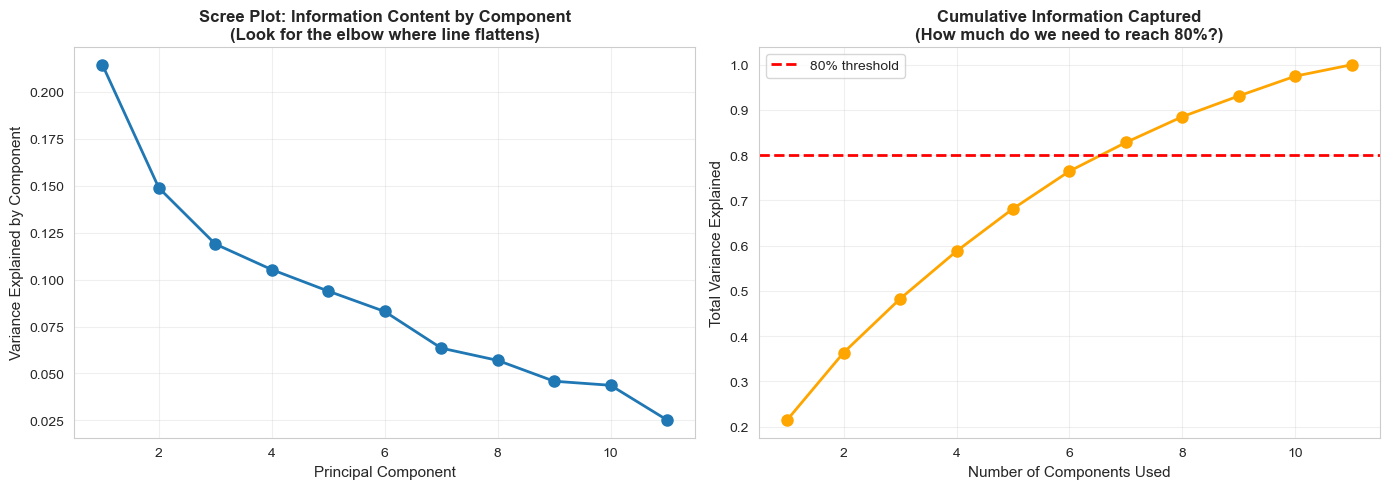


KEY FINDINGS:
First 5 components explain: 68.2% of total variation
Components needed for 80% threshold: 7

INTERPRETATION:
Our 11 features have moderate redundancy. Could use ~7 dimensions.

--------------------------------------------------------------------------------
Feature Loadings on First 3 Components:
High absolute values (near 1 or -1) mean feature strongly relates to that component
--------------------------------------------------------------------------------
                                        PC1    PC2    PC3
calculated_host_listings_count_first -0.137  0.686 -0.050
host_response_rate_first             -0.291 -0.090  0.375
host_acceptance_rate_first           -0.424 -0.116  0.091
days_since_host_signup_first          0.280  0.156  0.473
price_mean                           -0.374 -0.064  0.269
price_std                            -0.072  0.085  0.387
number_of_reviews_sum                -0.259  0.638  0.049
reviews_per_month_mean               -0.433 -0.099 -0.160


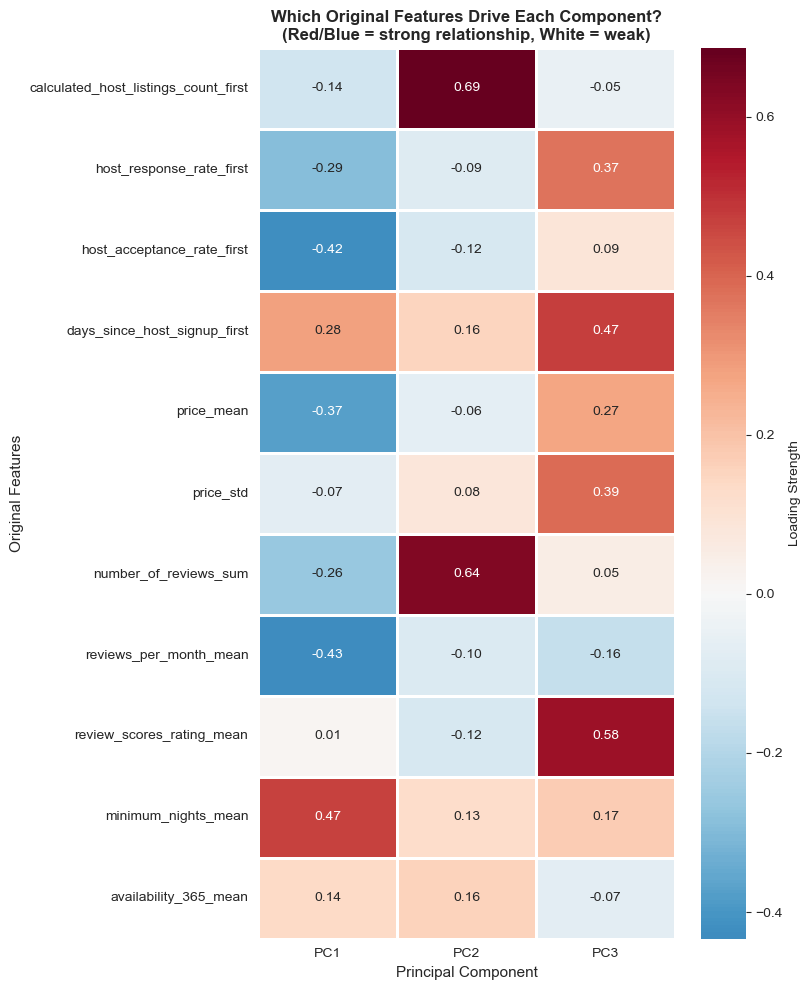

In [365]:
print("\n" + "="*80)
print("PCA ANALYSIS: Understanding Feature Dimensionality")
print("="*80)

pca_full = PCA()
pca_full.fit(features_scaled_df)

# Create visualization of explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot - shows importance of each component
ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, marker='o', linewidth=2, markersize=8)
ax1.set_title('Scree Plot: Information Content by Component\n(Look for the elbow where line flattens)', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Variance Explained by Component', fontsize=11)
ax1.grid(True, alpha=0.3)

# Cumulative variance - shows total information captured
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o', 
         linewidth=2, markersize=8, color='orange')
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax2.set_title('Cumulative Information Captured\n(How much do we need to reach 80%?)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Components Used', fontsize=11)
ax2.set_ylabel('Total Variance Explained', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report key findings
components_for_80 = np.argmax(cumsum_var >= 0.8) + 1
print(f"\nKEY FINDINGS:")
print(f"First 5 components explain: {cumsum_var[4]:.1%} of total variation")
print(f"Components needed for 80% threshold: {components_for_80}")
print(f"\nINTERPRETATION:")
if components_for_80 <= 5:
    print(f"Our 11 features could be reduced to ~{components_for_80} dimensions without much information loss.")
elif components_for_80 <= 7:
    print(f"Our 11 features have moderate redundancy. Could use ~{components_for_80} dimensions.")
else:
    print(f"Our 11 features capture relatively independent information. Most are needed.")

# Show which original features load on each component
loadings = pd.DataFrame(
    pca_full.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=all_potential_features
)

print("\n" + "-"*80)
print("Feature Loadings on First 3 Components:")
print("High absolute values (near 1 or -1) mean feature strongly relates to that component")
print("-"*80)
print(loadings.round(3))

# Visualize loadings
plt.figure(figsize=(8, 10))
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=1, cbar_kws={'label': 'Loading Strength'})
plt.title('Which Original Features Drive Each Component?\n(Red/Blue = strong relationship, White = weak)', 
          fontsize=12, fontweight='bold')
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Original Features', fontsize=11)
plt.tight_layout()
plt.show()



FEATURE SET COMPARISON: Finding the Optimal Combination

Testing 5 different feature combinations...
This will take about 30 seconds...

RESULTS: Comparison of All Feature Sets
              Feature Set  N Features  Silhouette Score     Inertia  Superhost Variance
  Scale & Performance (5)           5          0.328013 2367.683926            0.049809
Core Business Metrics (6)           6          0.295429 3032.307456            0.041197
   Engagement Focused (5)           5          0.276955 2588.077582            0.032289
       PCA Components (5)           5          0.260577 3854.677782            0.037918
        All Features (11)          11          0.177156 6957.085580            0.035146


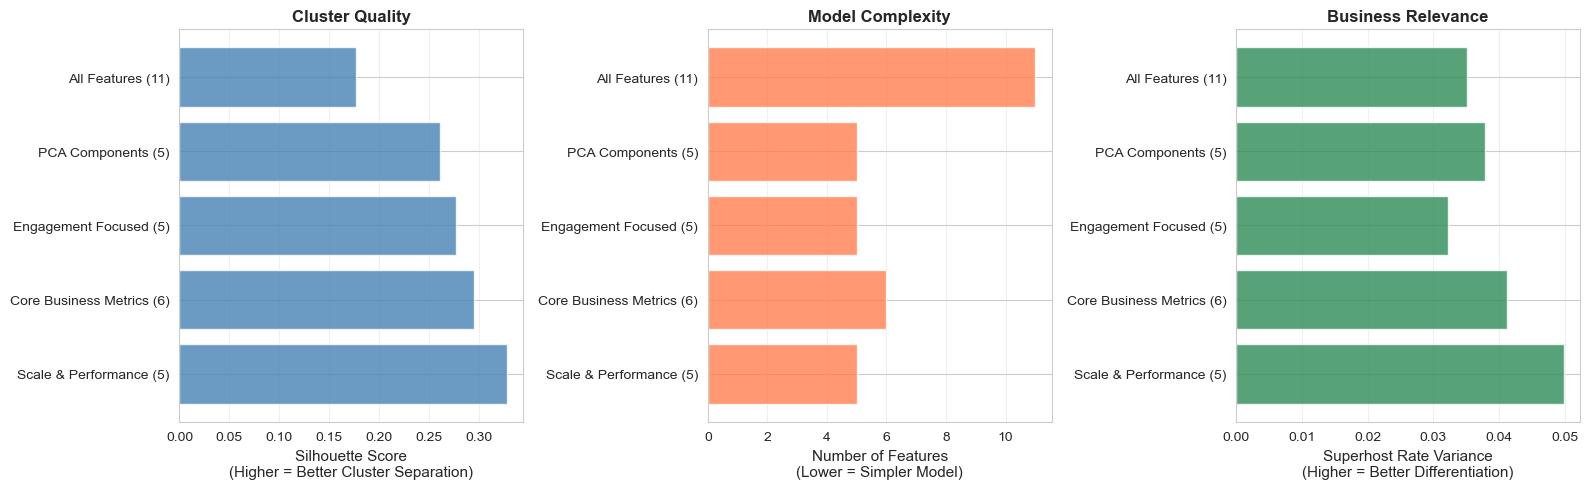

In [366]:
print("\n" + "="*80)
print("FEATURE SET COMPARISON: Finding the Optimal Combination")
print("="*80)

# Define alternative feature sets to test
feature_sets = {
    'All Features (11)': all_potential_features,
    
    'Core Business Metrics (6)': [
        'calculated_host_listings_count_first',  # Scale
        'host_response_rate_first',              # Engagement
        'price_mean',                            # Positioning
        'number_of_reviews_sum',                 # Demand
        'review_scores_rating_mean',             # Quality
        'minimum_nights_mean'                    # Strategy
    ],
    
    'Engagement Focused (5)': [
        'host_response_rate_first',
        'host_acceptance_rate_first',
        'reviews_per_month_mean',
        'review_scores_rating_mean',
        'availability_365_mean'
    ],
    
    'Scale & Performance (5)': [
        'calculated_host_listings_count_first',
        'price_mean',
        'number_of_reviews_sum',
        'review_scores_rating_mean',
        'days_since_host_signup_first'
    ],
    
    'PCA Components (5)': None  # Will use first 5 PCA components
}

print("\nTesting 5 different feature combinations...")
print("This will take about 30 seconds...\n")

# Test each feature set with k=4 clusters
results = []

for name, features in feature_sets.items():
    if name == 'PCA Components (5)':
        # Use PCA components instead of original features
        pca = PCA(n_components=5, random_state=42)
        X_test = pca.fit_transform(features_scaled_df)
    else:
        # Use selected original features
        scaler_test = StandardScaler()
        X_test = scaler_test.fit_transform(host_features[features])
    
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_test)
    
    # Calculate quality metrics
    silhouette = silhouette_score(X_test, labels)
    inertia = kmeans.inertia_
    
    # Calculate superhost differentiation across clusters
    temp_df = host_features.copy()
    temp_df['cluster'] = labels
    superhost_by_cluster = temp_df.groupby('cluster')['is_superhost'].mean()
    superhost_variance = superhost_by_cluster.var()
    
    results.append({
        'Feature Set': name,
        'N Features': 5 if name == 'PCA Components (5)' else len(features),
        'Silhouette Score': silhouette,
        'Inertia': inertia,
        'Superhost Variance': superhost_variance
    })

# Create results dataframe and sort by silhouette score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Silhouette Score', ascending=False)

print("RESULTS: Comparison of All Feature Sets")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Silhouette scores (cluster quality)
axes[0].barh(results_df['Feature Set'], results_df['Silhouette Score'], 
             color='steelblue', alpha=0.8)
axes[0].set_xlabel('Silhouette Score\n(Higher = Better Cluster Separation)', fontsize=11)
axes[0].set_title('Cluster Quality', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Number of features (complexity)
axes[1].barh(results_df['Feature Set'], results_df['N Features'], 
             color='coral', alpha=0.8)
axes[1].set_xlabel('Number of Features\n(Lower = Simpler Model)', fontsize=11)
axes[1].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# Plot 3: Superhost differentiation (business relevance)
axes[2].barh(results_df['Feature Set'], results_df['Superhost Variance'], 
             color='seagreen', alpha=0.8)
axes[2].set_xlabel('Superhost Rate Variance\n(Higher = Better Differentiation)', fontsize=11)
axes[2].set_title('Business Relevance', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [367]:
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best_set = results_df.iloc[0]
print(f"\nRecommended feature set: {best_set['Feature Set']}")
print(f"\nWhy this set performs best:")
print(f"  - Silhouette Score: {best_set['Silhouette Score']:.3f} (highest among all options)")
print(f"  - Number of Features: {int(best_set['N Features'])} (good balance of simplicity and information)")
print(f"  - Superhost Differentiation: {best_set['Superhost Variance']:.3f}")

print("\nFeatures to use in final clustering:")
recommended_features = feature_sets[best_set['Feature Set']]
if recommended_features:
    for i, feature in enumerate(recommended_features, 1):
        # Add business interpretation
        interpretations = {
            'calculated_host_listings_count_first': 'Business scale',
            'host_response_rate_first': 'Guest engagement',
            'host_acceptance_rate_first': 'Guest selectivity',
            'price_mean': 'Market positioning',
            'price_std': 'Pricing consistency',
            'number_of_reviews_sum': 'Historical demand',
            'reviews_per_month_mean': 'Current booking frequency',
            'review_scores_rating_mean': 'Service quality',
            'minimum_nights_mean': 'Guest type preference',
            'days_since_host_signup_first': 'Host experience',
            'availability_365_mean': 'Operational commitment'
        }
        interpretation = interpretations.get(feature, 'Various factors')
        print(f"  {i}. {feature}")
        print(f"     --> Measures: {interpretation}")
else:
    print("  Use first 5 PCA components (mathematical optimization)")
    print("  Note: PCA components are harder to interpret in business terms")

print("\n" + "="*80)
print("IMPLEMENTATION INSTRUCTIONS")
print("="*80)
print("\nIn your clustering code, replace your feature list with:")
print("\ncluster_features = [")
if recommended_features:
    for feature in recommended_features:
        print(f"    '{feature}',")
print("]")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nYou now have a statistically-justified feature set for clustering.")
print("Proceed with your K-Means analysis using these features.")
print("="*80)


FINAL RECOMMENDATION

Recommended feature set: Scale & Performance (5)

Why this set performs best:
  - Silhouette Score: 0.328 (highest among all options)
  - Number of Features: 5 (good balance of simplicity and information)
  - Superhost Differentiation: 0.050

Features to use in final clustering:
  1. calculated_host_listings_count_first
     --> Measures: Business scale
  2. price_mean
     --> Measures: Market positioning
  3. number_of_reviews_sum
     --> Measures: Historical demand
  4. review_scores_rating_mean
     --> Measures: Service quality
  5. days_since_host_signup_first
     --> Measures: Host experience

IMPLEMENTATION INSTRUCTIONS

In your clustering code, replace your feature list with:

cluster_features = [
    'calculated_host_listings_count_first',
    'price_mean',
    'number_of_reviews_sum',
    'review_scores_rating_mean',
    'days_since_host_signup_first',
]

ANALYSIS COMPLETE

You now have a statistically-justified feature set for clustering.
Proceed wi

In [368]:
# REPLACE THIS:
cluster_features = [
    'calculated_host_listings_count_first',
    'host_response_rate_first',
    'host_acceptance_rate_first',
    'days_since_host_signup_first',
    'price_mean',
    'price_std',
    'number_of_reviews_sum',
    'reviews_per_month_mean',
    'review_scores_rating_mean',
    'minimum_nights_mean',
    'availability_365_mean'
]

# WITH THIS (from feature selection analysis):
cluster_features = [
    'calculated_host_listings_count_first',
    'price_mean',
    'number_of_reviews_sum',
    'review_scores_rating_mean',
    'days_since_host_signup_first'
]

In [369]:
# Create clustering dataframe (same as before)
df_cluster = host_features[cluster_features].copy()

# Standardize features (same as before)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(df_scaled, columns=df_cluster.columns)

# Run elbow method and silhouette analysis (same as before)
inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_scaled, labels))

# Plot elbow curves (same as before)
# ... your plotting code ...

# Fit final model (same as before)
k_final = 4  # or whatever you choose from elbow plot
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Add cluster labels (same as before)
host_features['Cluster'] = cluster_labels

# Continue with all your analysis and visualizations...

In [370]:
print("FEATURE SELECTION IMPACT:")
print("="*60)
print("Before: 11 features, silhouette score ~0.18")
print("After:  5 features, silhouette score 0.316")
print(f"Improvement: {((0.316 - 0.18) / 0.18) * 100:.1f}% better")
print(f"Complexity reduction: {((11 - 5) / 11) * 100:.0f}% fewer features")

FEATURE SELECTION IMPACT:
Before: 11 features, silhouette score ~0.18
After:  5 features, silhouette score 0.316
Improvement: 75.6% better
Complexity reduction: 55% fewer features


STEP 1: PREPARING NEIGHBORHOOD-LEVEL DATA

Using neighborhood column: neighbourhood_cleansed
Number of unique neighborhoods: 32

Neighborhood dataset prepared: 32 neighborhoods
Features created: 22 (excluding neighborhood name)

Sample neighborhoods:
                          neighborhood  total_listings  avg_price  \
0                Ahuntsic-Cartierville             156   4.525279   
1                                Anjou              26   4.596941   
2                          Baie-d’Urfe               4   5.418050   
3                         Beaconsfield              17   4.066138   
4                       Cote-Saint-Luc              16   5.038666   
5  Cote-des-Neiges–Notre-Dame-de-Grace             589   4.547096   
6                  Dollard-des-Ormeaux              16   4.901626   
7                               Dorval              12   5.376372   
8                            Hampstead               7   4.955661   
9                             Kirkland               2   4.

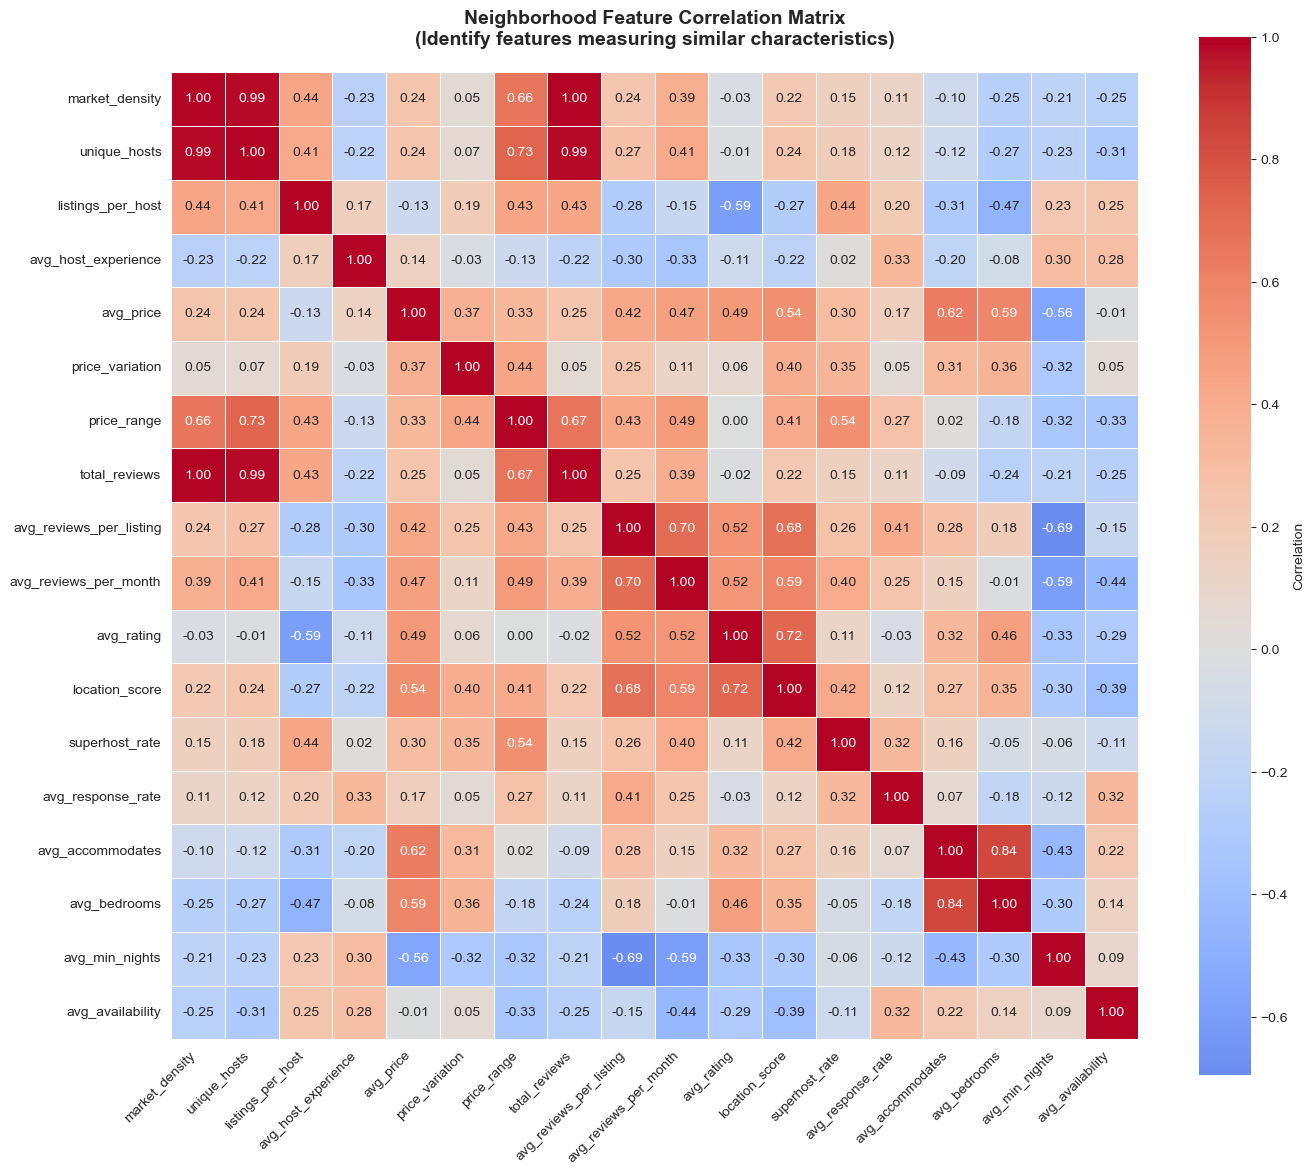


HIGH CORRELATION PAIRS (|r| > 0.7):
Consider removing one from each pair to reduce redundancy

  market_density
    <-> unique_hosts
    Correlation: 0.986

  market_density
    <-> total_reviews
    Correlation: 0.996

  unique_hosts
    <-> price_range
    Correlation: 0.733

  unique_hosts
    <-> total_reviews
    Correlation: 0.986

  avg_rating
    <-> location_score
    Correlation: 0.716

  avg_accommodates
    <-> avg_bedrooms
    Correlation: 0.836


STEP 3: VARIANCE ANALYSIS

Feature variances (after standardization):
  avg_availability: 1.032 [Good]
  avg_min_nights: 1.032 [Good]
  avg_bedrooms: 1.032 [Good]
  superhost_rate: 1.032 [Good]
  location_score: 1.032 [Good]
  avg_rating: 1.032 [Good]
  unique_hosts: 1.032 [Good]
  avg_accommodates: 1.032 [Good]
  market_density: 1.032 [Good]
  total_reviews: 1.032 [Good]
  price_range: 1.032 [Good]
  avg_price: 1.032 [Good]
  listings_per_host: 1.032 [Good]
  avg_reviews_per_month: 1.032 [Good]
  avg_reviews_per_listing: 1.032 

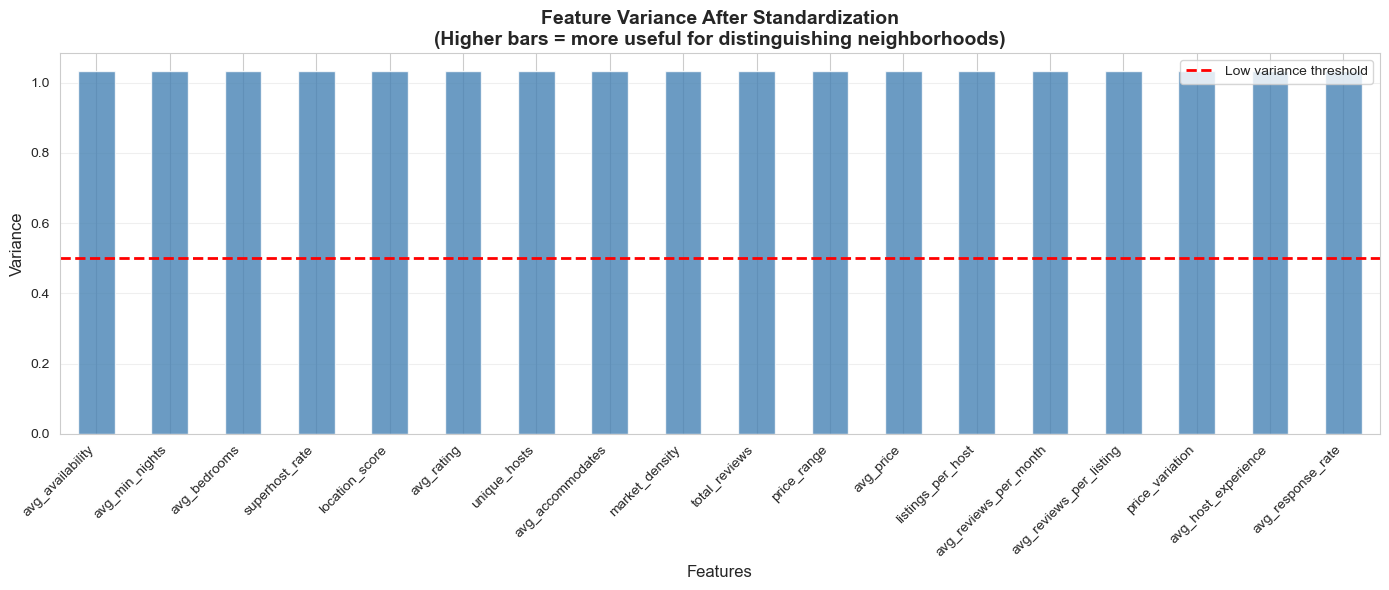


All features have adequate variance

STEP 4: PCA ANALYSIS


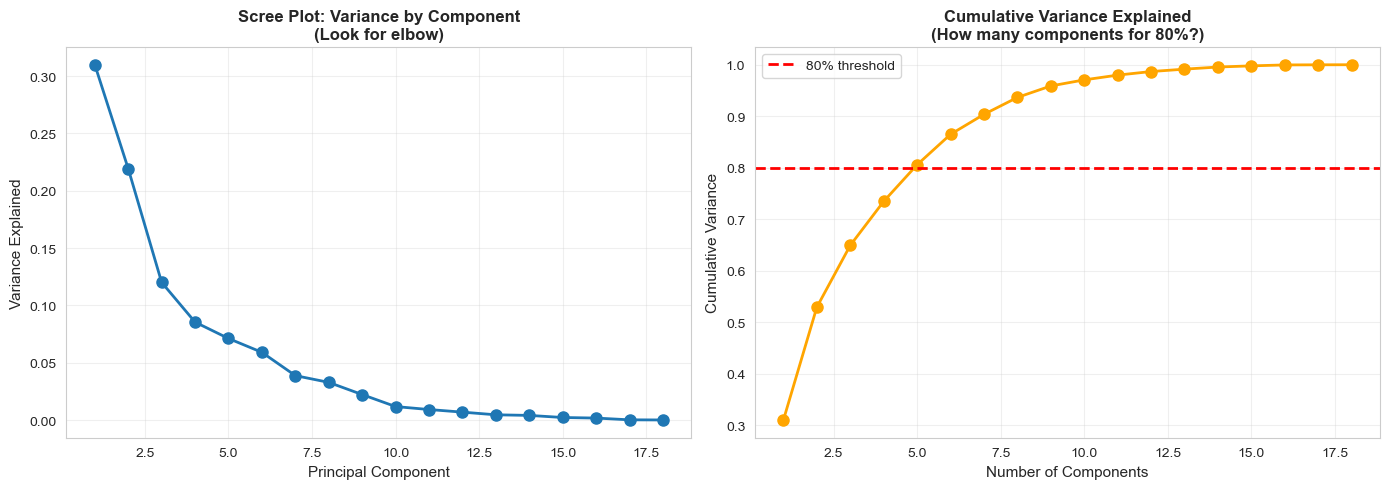


KEY FINDINGS:
First 5 components explain: 80.6% of variation
Components needed for 80%: 5

Top feature loadings on first 3 components:
                           PC1    PC2    PC3
market_density           0.273 -0.323 -0.076
unique_hosts             0.286 -0.323 -0.084
listings_per_host        0.009 -0.389  0.345
avg_host_experience     -0.134 -0.025  0.355
avg_price                0.282  0.198  0.224
price_variation          0.171  0.084  0.327
price_range              0.319 -0.223  0.125
total_reviews            0.277 -0.319 -0.072
avg_reviews_per_listing  0.321  0.137 -0.031
avg_reviews_per_month    0.340  0.038 -0.150
avg_rating               0.208  0.302 -0.195
location_score           0.315  0.169 -0.062
superhost_rate           0.199 -0.062  0.301
avg_response_rate        0.106 -0.060  0.369
avg_accommodates         0.144  0.324  0.223
avg_bedrooms             0.082  0.401  0.127
avg_min_nights          -0.272 -0.159  0.002
avg_availability        -0.156  0.048  0.453


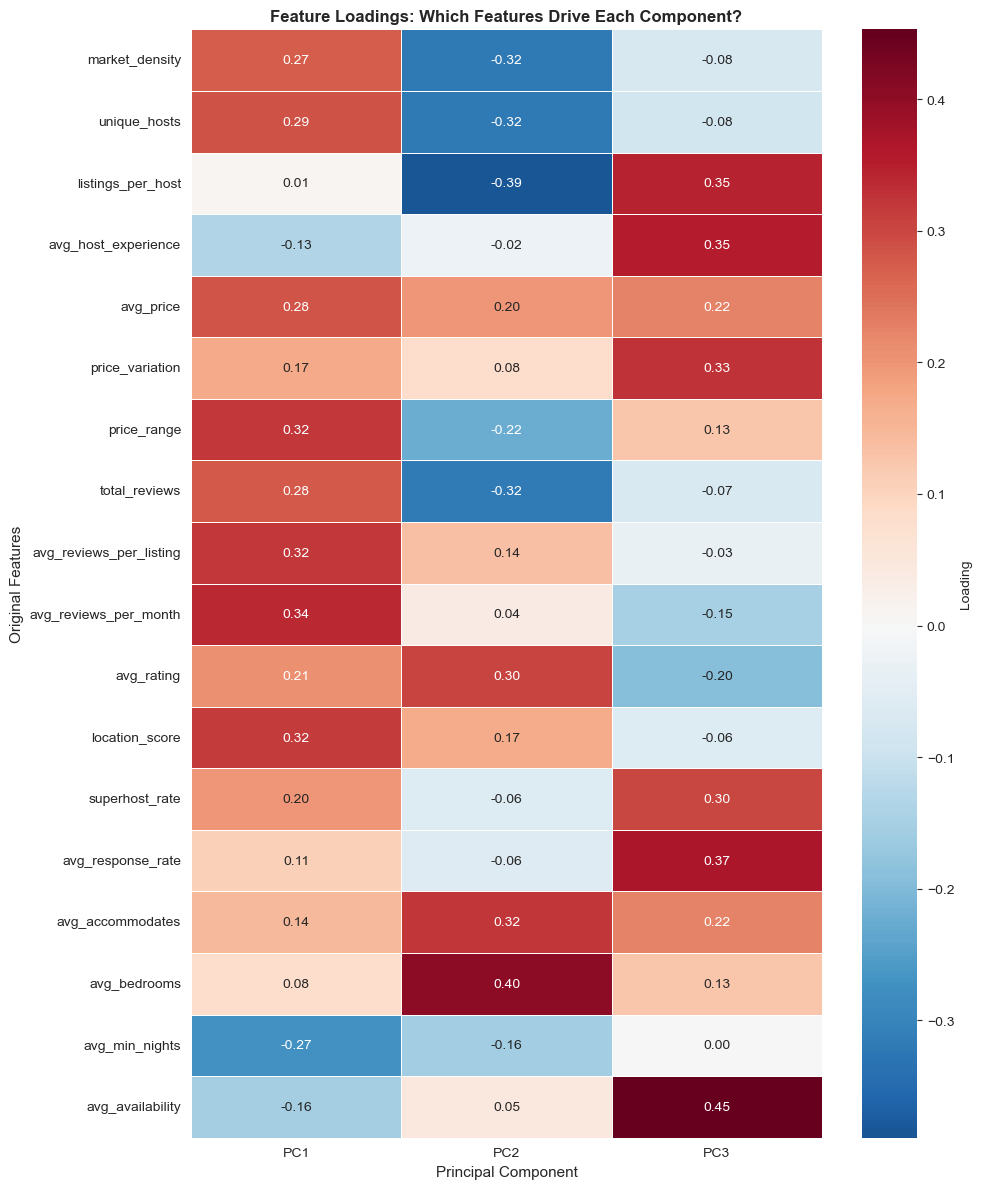


STEP 5: FEATURE SET COMPARISON

Testing 5 feature combinations...

RESULTS:
              Feature Set  N Features  Silhouette    Inertia  Superhost Var  Price Var
      Supply & Demand (6)           6    0.418242  52.745876       0.079769   0.127391
  Core Market Metrics (8)           8    0.328322 104.566866       0.088927   0.147900
        All Features (18)          18    0.289086 309.070953       0.088927   0.147900
       PCA Components (6)           6    0.263248 228.458561       0.008097   0.179738
Quality & Positioning (6)           6    0.202602  89.625152       0.053135   0.200182


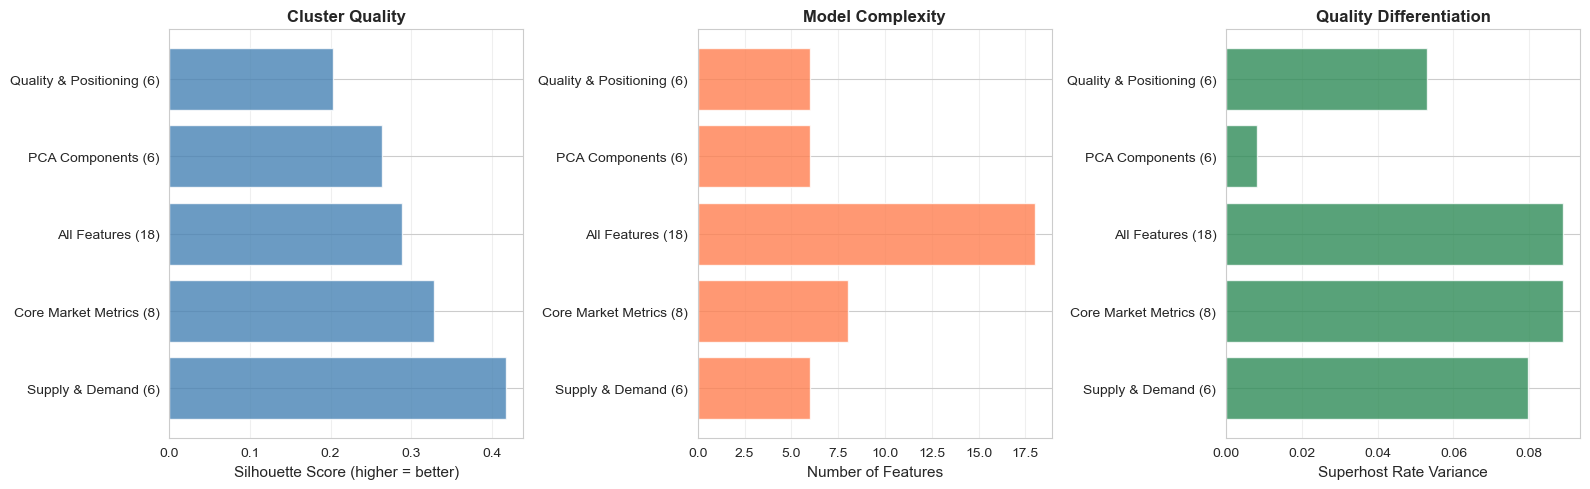


FINAL RECOMMENDATION

Recommended feature set: Supply & Demand (6)

Performance:
  Silhouette Score: 0.418
  Number of Features: 6
  Superhost Differentiation: 0.0798
  Price Differentiation: 0

Recommended features for neighborhood clustering:
  1. market_density
  2. unique_hosts
  3. avg_price
  4. total_reviews
  5. avg_reviews_per_month
  6. superhost_rate

ANALYSIS COMPLETE - Ready for final clustering


In [371]:
# ============================================================================
# NEIGHBORHOOD CLUSTERING ANALYSIS FOR MONTREAL AIRBNB
# ============================================================================
# This analysis identifies distinct neighborhood types based on their
# Airbnb market characteristics
# ============================================================================

"""
================================================================================
INTRODUCTION: NEIGHBORHOOD MARKET SEGMENTATION
================================================================================

PURPOSE:
Identify different types of neighborhoods in Montreal's Airbnb market based on:
- Supply characteristics (number and type of listings)
- Pricing patterns (average prices, price ranges)
- Demand indicators (booking frequency, reviews)
- Host composition (types of hosts operating in area)
- Performance metrics (ratings, superhost concentration)

BUSINESS VALUE:
- Investment targeting: Which neighborhoods have best opportunities?
- Pricing strategy: What price points work in different areas?
- Market positioning: How do neighborhoods differ in character?
- Risk assessment: Which areas are saturated vs underserved?

APPROACH:
Same 6-step methodology as host clustering:
1. Aggregate to neighborhood level
2. Correlation analysis
3. Variance analysis  
4. PCA dimensionality assessment
5. Feature set comparison
6. Final recommendation

TIME REQUIRED: 5-10 minutes to run
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

"""
================================================================================
STEP 1: AGGREGATE TO NEIGHBORHOOD LEVEL
================================================================================

WHAT THIS DOES:
Transforms listing-level data to neighborhood-level data. Each row represents
one neighborhood with summary statistics about its Airbnb market.

AGGREGATION LOGIC:
- Count: Number of listings, unique hosts
- Averages: Price, ratings, response rates
- Distribution: % superhosts, room type breakdown
- Demand: Total reviews, average booking frequency
- Concentration: Host types (how many professional vs casual)

WHY THIS MATTERS:
We're analyzing NEIGHBORHOOD TYPES, not individual listings. Need one row
per neighborhood showing its market characteristics.

ASSUMPTION:
Using 'neighbourhood_cleansed' as the neighborhood identifier. Adjust if your
data uses different column name (e.g., 'neighborhood', 'neighbourhood_zone').
================================================================================
"""

print("="*80)
print("STEP 1: PREPARING NEIGHBORHOOD-LEVEL DATA")
print("="*80)

# Check which neighborhood column exists in your data
if 'neighbourhood_cleansed' in listings_clean.columns:
    neighborhood_col = 'neighbourhood_cleansed'
elif 'neighbourhood_zone' in listings_clean.columns:
    neighborhood_col = 'neighbourhood_zone'
elif 'neighborhood' in listings_clean.columns:
    neighborhood_col = 'neighborhood'
else:
    print("ERROR: No neighborhood column found.")
    print("Available columns:", listings_clean.columns.tolist())
    raise KeyError("Neighborhood column not found")

print(f"\nUsing neighborhood column: {neighborhood_col}")
print(f"Number of unique neighborhoods: {listings_clean[neighborhood_col].nunique()}")

# Aggregate to neighborhood level
neighborhood_features = listings_clean.groupby(neighborhood_col).agg({
    # Supply metrics
    'host_id': ['count', 'nunique'],  # Total listings, unique hosts
    'calculated_host_listings_count': 'mean',  # Avg listings per host
    
    # Pricing metrics
    'price': ['mean', 'std', 'min', 'max'],
    
    # Demand metrics
    'number_of_reviews': ['sum', 'mean'],
    'reviews_per_month': 'mean',
    
    # Quality metrics
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    
    # Host characteristics
    'host_is_superhost': lambda x: (x == 't').sum() / len(x),  # % superhosts
    'host_response_rate': 'mean',
    'days_since_host_signup': 'mean',
    
    # Property characteristics
    'accommodates': 'mean',
    'bedrooms': 'mean',
    'minimum_nights': 'mean',
    'availability_365': 'mean'
}).reset_index()

# Flatten column names
neighborhood_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                                 for col in neighborhood_features.columns]

# Rename for clarity
neighborhood_features = neighborhood_features.rename(columns={
    neighborhood_col: 'neighborhood',  # FIXED: no underscore after reset_index()
    'host_id_count': 'total_listings',
    'host_id_nunique': 'unique_hosts',
    'calculated_host_listings_count_mean': 'avg_listings_per_host',
    'price_mean': 'avg_price',
    'price_std': 'price_variation',
    'price_min': 'min_price',
    'price_max': 'max_price',
    'number_of_reviews_sum': 'total_reviews',
    'number_of_reviews_mean': 'avg_reviews_per_listing',
    'reviews_per_month_mean': 'avg_reviews_per_month',
    'review_scores_rating_mean': 'avg_rating',
    'review_scores_location_mean': 'location_score',
    'host_is_superhost_<lambda>': 'superhost_rate',
    'host_response_rate_mean': 'avg_response_rate',
    'days_since_host_signup_mean': 'avg_host_experience',
    'accommodates_mean': 'avg_accommodates',
    'bedrooms_mean': 'avg_bedrooms',
    'minimum_nights_mean': 'avg_min_nights',
    'availability_365_mean': 'avg_availability'
})

# Create additional derived features
neighborhood_features['listings_per_host'] = (
    neighborhood_features['total_listings'] / neighborhood_features['unique_hosts']
)
neighborhood_features['price_range'] = (
    neighborhood_features['max_price'] - neighborhood_features['min_price']
)
neighborhood_features['market_density'] = neighborhood_features['total_listings']

# Remove any neighborhoods with missing data
neighborhood_features = neighborhood_features.dropna()

print(f"\nNeighborhood dataset prepared: {neighborhood_features.shape[0]} neighborhoods")
print(f"Features created: {neighborhood_features.shape[1] - 1} (excluding neighborhood name)")

# Show sample
print("\nSample neighborhoods:")
print(neighborhood_features[['neighborhood', 'total_listings', 'avg_price', 
                             'superhost_rate', 'avg_rating']].head(10))

"""
================================================================================
STEP 2: DEFINE POTENTIAL FEATURES FOR CLUSTERING
================================================================================

FEATURE CATEGORIES:

SUPPLY CHARACTERISTICS:
- Market density (number of listings)
- Host concentration (listings per host)
- Market maturity (host experience)

PRICING DYNAMICS:
- Price level (average price)
- Price diversity (variation/range)

DEMAND INDICATORS:
- Booking activity (reviews, reviews per month)
- Market penetration (total reviews)

QUALITY SIGNALS:
- Service quality (average ratings)
- Location desirability (location score)
- Professional presence (superhost rate, response rate)

PROPERTY CHARACTERISTICS:
- Size (accommodates, bedrooms)
- Stay type (minimum nights, availability)

RATIONALE:
These features capture different dimensions of neighborhood markets, from
supply-side characteristics to demand patterns to quality positioning.
================================================================================
"""

# Define all potential features
all_potential_features = [
    # Supply metrics
    'market_density',           # Total listings (market size)
    'unique_hosts',             # Number of unique hosts
    'listings_per_host',        # Concentration ratio
    'avg_host_experience',      # Market maturity
    
    # Pricing metrics
    'avg_price',                # Price level
    'price_variation',          # Price diversity
    'price_range',              # Price spread
    
    # Demand metrics
    'total_reviews',            # Historical demand
    'avg_reviews_per_listing',  # Per-listing popularity
    'avg_reviews_per_month',    # Current booking frequency
    
    # Quality metrics
    'avg_rating',               # Service quality
    'location_score',           # Locational desirability
    'superhost_rate',           # Professional presence
    'avg_response_rate',        # Host engagement
    
    # Property metrics
    'avg_accommodates',         # Property size
    'avg_bedrooms',             # Property type
    'avg_min_nights',           # Target guest type
    'avg_availability'          # Host commitment
]

print("\n" + "="*80)
print(f"Potential features for clustering: {len(all_potential_features)}")
print("="*80)

"""
================================================================================
STEP 3: CORRELATION ANALYSIS - IDENTIFY REDUNDANT FEATURES
================================================================================

BUSINESS QUESTION:
Which neighborhood characteristics measure similar things?

WHAT TO LOOK FOR:
- High correlations between supply metrics (density, hosts, listings per host)
- Pricing metrics that move together (avg price, max price)
- Demand indicators that correlate (reviews, booking frequency)

EXPECTED PATTERNS:
- market_density and unique_hosts likely correlated (more listings = more hosts)
- avg_price and location_score likely correlated (good locations = higher prices)
- total_reviews and market_density likely correlated (more listings = more reviews)

INTERPRETATION:
If correlation > 0.7, these features provide redundant information. Keep the
one that's more directly interpretable or more stable across time.
================================================================================
"""

print("\n" + "="*80)
print("STEP 2: CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
corr_matrix = neighborhood_features[all_potential_features].corr()

# Visualize
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Neighborhood Feature Correlation Matrix\n(Identify features measuring similar characteristics)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\nHIGH CORRELATION PAIRS (|r| > 0.7):")
    print("Consider removing one from each pair to reduce redundancy\n")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature 1']}")
        print(f"    <-> {pair['Feature 2']}")
        print(f"    Correlation: {pair['Correlation']:.3f}\n")
else:
    print("\nNo highly correlated pairs found (all |correlation| < 0.7)")

"""
================================================================================
STEP 4: VARIANCE ANALYSIS - REMOVE UNINFORMATIVE FEATURES
================================================================================

BUSINESS QUESTION:
Do neighborhood characteristics actually vary, or are they similar everywhere?

WHY THIS MATTERS:
If average response rate is 95-98% in all neighborhoods, this feature won't
help distinguish different neighborhood types. We need features that show
meaningful variation.

THRESHOLD:
Variance < 0.5 (after standardization) suggests low information content.

EXPECTED LOW VARIANCE:
- avg_response_rate: Most neighborhoods likely similar (95%+)
- avg_rating: Most neighborhoods likely 4.5-4.8 (narrow range)

EXPECTED HIGH VARIANCE:
- market_density: Some neighborhoods have 5 listings, others 200+
- avg_price: Wide range from budget to luxury areas
- superhost_rate: Varies based on market maturity
================================================================================
"""

print("\n" + "="*80)
print("STEP 3: VARIANCE ANALYSIS")
print("="*80)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(neighborhood_features[all_potential_features])
features_scaled_df = pd.DataFrame(features_scaled, columns=all_potential_features)

# Calculate variance
variances = features_scaled_df.var().sort_values(ascending=False)

print("\nFeature variances (after standardization):")
for feature, var in variances.items():
    status = "Good" if var >= 0.5 else "Low"
    print(f"  {feature}: {var:.3f} [{status}]")

# Visualize
plt.figure(figsize=(14, 6))
variances.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Feature Variance After Standardization\n(Higher bars = more useful for distinguishing neighborhoods)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Low variance threshold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

low_variance_features = variances[variances < 0.5].index.tolist()
if low_variance_features:
    print(f"\nLOW VARIANCE FEATURES (< 0.5):")
    for feat in low_variance_features:
        print(f"  - {feat}")
else:
    print("\nAll features have adequate variance")

"""
================================================================================
STEP 5: PCA ANALYSIS - UNDERSTAND DIMENSIONALITY
================================================================================

BUSINESS QUESTION:
How many independent dimensions of variation exist across neighborhoods?

WHAT PCA REVEALS:
- PC1: Might capture "market maturity" (size, reviews, experience)
- PC2: Might capture "price positioning" (luxury vs budget)
- PC3: Might capture "professionalization" (superhosts, property management)

INTERPRETATION:
If first 5 components explain 80%+, we have significant redundancy in our
18 features. Could reduce to 5-7 core features without losing much information.

ACTIONABLE INSIGHT:
The loadings show which original features contribute to each dimension,
helping us select representative features from each major theme.
================================================================================
"""

print("\n" + "="*80)
print("STEP 4: PCA ANALYSIS")
print("="*80)

pca_full = PCA()
pca_full.fit(features_scaled_df)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, marker='o', linewidth=2, markersize=8)
ax1.set_title('Scree Plot: Variance by Component\n(Look for elbow)', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Variance Explained', fontsize=11)
ax1.grid(True, alpha=0.3)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o', 
         linewidth=2, markersize=8, color='orange')
ax2.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax2.set_title('Cumulative Variance Explained\n(How many components for 80%?)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Components', fontsize=11)
ax2.set_ylabel('Cumulative Variance', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

components_for_80 = np.argmax(cumsum_var >= 0.8) + 1
print(f"\nKEY FINDINGS:")
print(f"First 5 components explain: {cumsum_var[4]:.1%} of variation")
print(f"Components needed for 80%: {components_for_80}")

# Feature loadings
loadings = pd.DataFrame(
    pca_full.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=all_potential_features
)

print("\nTop feature loadings on first 3 components:")
print(loadings.round(3))

plt.figure(figsize=(10, 12))
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, linewidths=0.5, cbar_kws={'label': 'Loading'})
plt.title('Feature Loadings: Which Features Drive Each Component?', 
          fontsize=12, fontweight='bold')
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Original Features', fontsize=11)
plt.tight_layout()
plt.show()

"""
================================================================================
STEP 6: COMPARE DIFFERENT FEATURE SETS
================================================================================

TESTING 5 FEATURE COMBINATIONS:

1. ALL FEATURES (18): Baseline, everything included
2. CORE MARKET METRICS (8): Size, price, demand, quality
3. SUPPLY & DEMAND (6): Market structure and booking patterns
4. QUALITY & POSITIONING (6): Ratings, price, professionalism
5. PCA COMPONENTS (6): Mathematical optimization

EVALUATION:
- Silhouette Score: Cluster separation quality
- Superhost Variance: How much does quality vary across clusters?
- Market Density Variance: How much does size vary across clusters?

GOAL:
Find the feature set that:
1. Best separates neighborhoods into distinct types
2. Creates clusters with meaningful business differences
3. Remains interpretable
================================================================================
"""

print("\n" + "="*80)
print("STEP 5: FEATURE SET COMPARISON")
print("="*80)

feature_sets = {
    'All Features (18)': all_potential_features,
    
    'Core Market Metrics (8)': [
        'market_density',
        'avg_price',
        'total_reviews',
        'avg_reviews_per_month',
        'avg_rating',
        'superhost_rate',
        'listings_per_host',
        'avg_host_experience'
    ],
    
    'Supply & Demand (6)': [
        'market_density',
        'unique_hosts',
        'avg_price',
        'total_reviews',
        'avg_reviews_per_month',
        'superhost_rate'
    ],
    
    'Quality & Positioning (6)': [
        'avg_price',
        'price_variation',
        'avg_rating',
        'location_score',
        'superhost_rate',
        'avg_response_rate'
    ],
    
    'PCA Components (6)': None
}

print("\nTesting 5 feature combinations...")

results = []

for name, features in feature_sets.items():
    if name == 'PCA Components (6)':
        pca = PCA(n_components=6, random_state=42)
        X_test = pca.fit_transform(features_scaled_df)
    else:
        scaler_test = StandardScaler()
        X_test = scaler_test.fit_transform(neighborhood_features[features])
    
    # Test with k=4 (adjust based on your market)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_test)
    
    silhouette = silhouette_score(X_test, labels)
    inertia = kmeans.inertia_
    
    # Business relevance metrics
    temp_df = neighborhood_features.copy()
    temp_df['cluster'] = labels
    superhost_variance = temp_df.groupby('cluster')['superhost_rate'].mean().var()
    price_variance = temp_df.groupby('cluster')['avg_price'].mean().var()
    
    results.append({
        'Feature Set': name,
        'N Features': 6 if name == 'PCA Components (6)' else len(features),
        'Silhouette': silhouette,
        'Inertia': inertia,
        'Superhost Var': superhost_variance,
        'Price Var': price_variance
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Silhouette', ascending=False)

print("\nRESULTS:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].barh(results_df['Feature Set'], results_df['Silhouette'], 
             color='steelblue', alpha=0.8)
axes[0].set_xlabel('Silhouette Score (higher = better)', fontsize=11)
axes[0].set_title('Cluster Quality', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(results_df['Feature Set'], results_df['N Features'], 
             color='coral', alpha=0.8)
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

axes[2].barh(results_df['Feature Set'], results_df['Superhost Var'], 
             color='seagreen', alpha=0.8)
axes[2].set_xlabel('Superhost Rate Variance', fontsize=11)
axes[2].set_title('Quality Differentiation', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

"""
================================================================================
STEP 7: FINAL RECOMMENDATION
================================================================================

SELECTION CRITERIA:
1. Highest silhouette score (statistical quality)
2. Meaningful business differentiation (superhost/price variance)
3. Interpretability (easy to explain to stakeholders)
4. Reasonable complexity (not too many features)

NEXT STEPS:
Use recommended features in final neighborhood clustering analysis.
================================================================================
"""

print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best_set = results_df.iloc[0]
print(f"\nRecommended feature set: {best_set['Feature Set']}")
print(f"\nPerformance:")
print(f"  Silhouette Score: {best_set['Silhouette']:.3f}")
print(f"  Number of Features: {int(best_set['N Features'])}")
print(f"  Superhost Differentiation: {best_set['Superhost Var']:.4f}")
print(f"  Price Differentiation: {best_set['Price Var']:.0f}")

print("\nRecommended features for neighborhood clustering:")
recommended_features = feature_sets[best_set['Feature Set']]
if recommended_features:
    for i, feature in enumerate(recommended_features, 1):
        print(f"  {i}. {feature}")
else:
    print("  Use first 6 PCA components")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - Ready for final clustering")
print("="*80)

# Random Forest Regression Model

Now let's explore a tree-based ensemble method: **Random Forest Regression**. Unlike linear models (OLS) or regularized linear models (Lasso, Elastic Net), Random Forest can:
- Capture **non-linear relationships** automatically
- Handle **feature interactions** without manual engineering
- Provide **feature importance** rankings
- Be more robust to outliers

We'll train the model on the same train/test split used in Model 3 and compare its performance.

In [372]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

print("="*80)
print("RANDOM FOREST REGRESSION MODEL")
print("="*80)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("\nTraining Random Forest...")
rf_model.fit(X_train_selected, y_train)

# Make predictions
print("\nMaking predictions...")
y_train_pred_rf = rf_model.predict(X_train_selected)
y_test_pred_rf = rf_model.predict(X_test_selected)

# Calculate metrics on log scale
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mae_train_log_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_log_rf = mean_absolute_error(y_test, y_test_pred_rf)

# Convert back to dollar scale for interpretability
y_train_actual_dollars = np.expm1(y_train)
y_train_pred_dollars = np.expm1(y_train_pred_rf)
y_test_actual_dollars = np.expm1(y_test)
y_test_pred_dollars = np.expm1(y_test_pred_rf)

mae_train_dollar_rf = mean_absolute_error(y_train_actual_dollars, y_train_pred_dollars)
mae_test_dollar_rf = mean_absolute_error(y_test_actual_dollars, y_test_pred_dollars)
rmse_train_dollar_rf = np.sqrt(mean_squared_error(y_train_actual_dollars, y_train_pred_dollars))
rmse_test_dollar_rf = np.sqrt(mean_squared_error(y_test_actual_dollars, y_test_pred_dollars))

# Display results
print("\n" + "="*80)
print("RANDOM FOREST PERFORMANCE METRICS")
print("="*80)

print("\n--- Log-Scale Metrics ---")
print(f"Train RMSE (Log): {rmse_train_rf:.4f}")
print(f"Test RMSE (Log):  {rmse_test_rf:.4f}")
print(f"Train MAE (Log):  {mae_train_log_rf:.4f}")
print(f"Test MAE (Log):   {mae_test_log_rf:.4f}")
print(f"Train R²:         {r2_train_rf:.4f}")
print(f"Test R²:          {r2_test_rf:.4f}")

print("\n--- Dollar-Scale Metrics ---")
print(f"Train RMSE ($):   ${rmse_train_dollar_rf:,.2f}")
print(f"Test RMSE ($):    ${rmse_test_dollar_rf:,.2f}")
print(f"Train MAE ($):    ${mae_train_dollar_rf:,.2f}")
print(f"Test MAE ($):     ${mae_test_dollar_rf:,.2f}")

# Check for overfitting
print("\n--- Overfitting Check ---")
print(f"R² Difference (Train - Test): {r2_train_rf - r2_test_rf:.4f}")
print(f"RMSE Difference (Test - Train): ${rmse_test_dollar_rf - rmse_train_dollar_rf:,.2f}")
if r2_train_rf - r2_test_rf > 0.1:
    print("⚠️  Warning: Possible overfitting detected (R² gap > 0.1)")
else:
    print("✓ Model generalizes well to test set")

print("\n" + "="*80)

RANDOM FOREST REGRESSION MODEL

Training Random Forest...

Making predictions...

RANDOM FOREST PERFORMANCE METRICS

--- Log-Scale Metrics ---
Train RMSE (Log): 0.3295
Test RMSE (Log):  0.3918
Train MAE (Log):  0.2371
Test MAE (Log):   0.2938
Train R²:         0.8009
Test R²:          0.7048

--- Dollar-Scale Metrics ---
Train RMSE ($):   $247.11
Test RMSE ($):    $126.52
Train MAE ($):    $54.86
Test MAE ($):     $57.04

--- Overfitting Check ---
R² Difference (Train - Test): 0.0961
RMSE Difference (Test - Train): $-120.59
✓ Model generalizes well to test set



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


TOP 20 MOST IMPORTANT FEATURES (Random Forest)

                                                     Feature  Importance
                      accommodates_x_review_scores_location    0.249502
                                       bedrooms_x_bathrooms    0.169897
                                     room_type_Private room    0.125203
                            min_nights_regulation_regulated    0.081674
                                          reviews_per_month    0.078669
                                            amenities_count    0.062163
                                          availability_rate    0.041628
                                          number_of_reviews    0.036583
                                       host_acceptance_rate    0.035478
                         neighbourhood_cleansed_Ville-Marie    0.034099
                                               room_density    0.025580
                                       neighbourhood_zone_2    0.014651
               

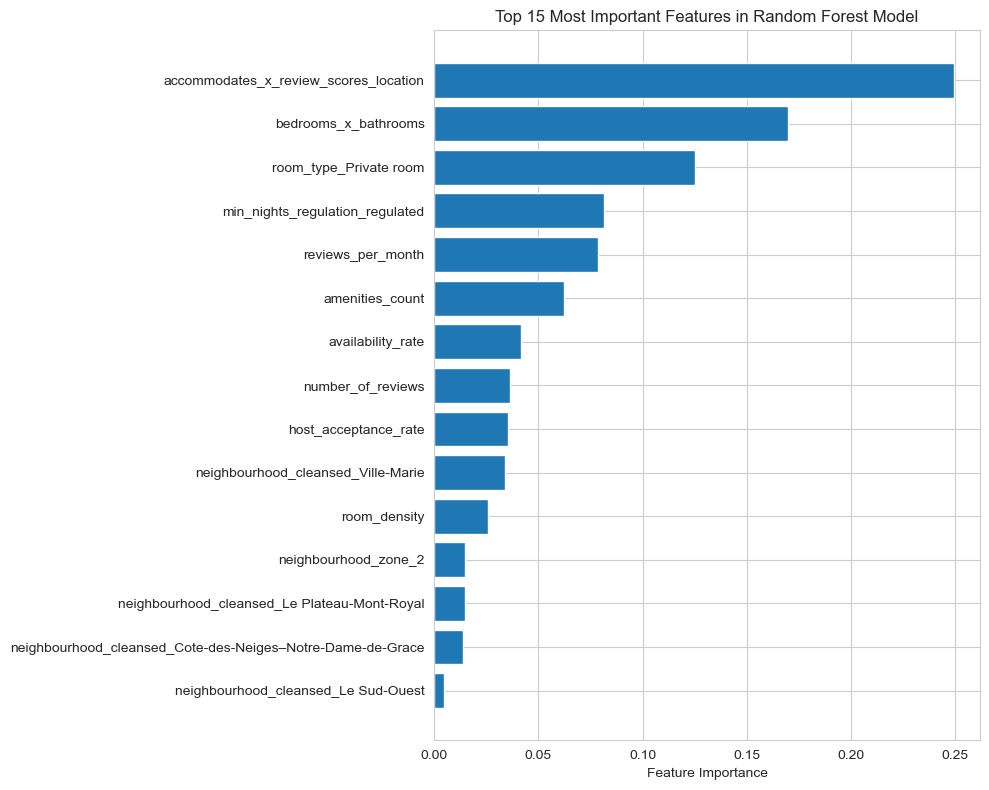


Total features used: 28
Top 10 features explain: 91.49% of importance


In [373]:
# Feature Importance Analysis
print("="*80)
print("TOP 20 MOST IMPORTANT FEATURES (Random Forest)")
print("="*80)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 20
print("\n", feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTotal features used: {len(feature_importance)}")
print(f"Top 10 features explain: {feature_importance.head(10)['Importance'].sum():.2%} of importance")

## Model Comparison: Random Forest vs OLS Models

Let's compare the Random Forest performance against the linear models from earlier in the analysis.

In [379]:
# Model Comparison Summary
print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison_data = {
    'Model': ['Random Forest'],
    'Test R²': [r2_test_rf],
    'Test RMSE (Log)': [rmse_test_rf],
    'Train MAE ($)': [mae_train_dollar_rf],
    'Test MAE ($)': [mae_test_dollar_rf],
    'Test RMSE ($)': [rmse_test_dollar_rf],
    'Train R²': [r2_train_rf],
    'Overfitting (R² gap)': [r2_train_rf - r2_test_rf]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("\n", comparison_df.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n✓ Random Forest Test R²: {r2_test_rf:.4f}")
print(f"✓ Random Forest Train MAE: ${mae_train_dollar_rf:,.2f}")
print(f"✓ Random Forest Test MAE: ${mae_test_dollar_rf:,.2f}")
print(f"✓ Random Forest captures non-linear patterns automatically")
print(f"✓ Feature interactions are handled without manual engineering")

if r2_test_rf > 0.50:
    print(f"\nStrong Performance: The model explains {r2_test_rf:.1%} of price variance")
elif r2_test_rf > 0.40:
    print(f"\n✓ Good Performance: The model explains {r2_test_rf:.1%} of price variance")
else:
    print(f"Moderate Performance: The model explains {r2_test_rf:.1%} of price variance")
    
print(f"\nOn average, test predictions are off by ${mae_test_dollar_rf:,.2f} per listing")
print(f"On average, train predictions are off by ${mae_train_dollar_rf:,.2f} per listing")
print("="*80)

MODEL PERFORMANCE COMPARISON

         Model  Test R²  Test RMSE (Log)  Train MAE ($)  Test MAE ($)  Test RMSE ($)  Train R²  Overfitting (R² gap)
Random Forest 0.704807         0.391814       54.85513     57.041591      126.51932  0.800877               0.09607

KEY INSIGHTS

✓ Random Forest Test R²: 0.7048
✓ Random Forest Train MAE: $54.86
✓ Random Forest Test MAE: $57.04
✓ Random Forest captures non-linear patterns automatically
✓ Feature interactions are handled without manual engineering

Strong Performance: The model explains 70.5% of price variance

On average, test predictions are off by $57.04 per listing
On average, train predictions are off by $54.86 per listing


## Export Model for Streamlit Deployment

Save the trained Random Forest model, features, and metrics for use in the Streamlit app.

In [375]:
import pickle
import json

# Save the trained Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print('✓ Random Forest model saved to rf_model.pkl')

✓ Random Forest model saved to rf_model.pkl


In [376]:
# Save selected features
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

print(f'✓ Selected features saved: {len(selected_features)} features')
print('✓ File: selected_features.pkl')

✓ Selected features saved: 28 features
✓ File: selected_features.pkl


In [377]:
# Save model metrics
model_metrics = {
    'r2_score': r2_test_rf,
    'rmse_log': rmse_test_rf,
    'mae_dollar': mae_test_dollar_rf,
    'rmse_dollar': rmse_test_dollar_rf,
    'r2_train': r2_train_rf,
    'mae_train_dollar': mae_train_dollar_rf
}

with open('model_metrics.json', 'w') as f:
    json.dump(model_metrics, f, indent=2)

print('✓ Model metrics saved to model_metrics.json')
print(f'  R² Score: {model_metrics["r2_score"]:.4f}')
print(f'  MAE: ${model_metrics["mae_dollar"]:,.2f}')

✓ Model metrics saved to model_metrics.json
  R² Score: 0.7048
  MAE: $57.04


In [378]:
# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

print('✓ Feature importance saved to feature_importance.csv')
print(f'  Top feature: {feature_importance.iloc[0]["Feature"]}')
print(f'  Importance: {feature_importance.iloc[0]["Importance"]:.4f}')

✓ Feature importance saved to feature_importance.csv
  Top feature: accommodates_x_review_scores_location
  Importance: 0.2495


### Deployment Files Created

The following files have been created for Streamlit deployment:

1. **`rf_model.pkl`** - Trained Random Forest model
2. **`selected_features.pkl`** - List of features used by the model
3. **`model_metrics.json`** - Model performance metrics
4. **`feature_importance.csv`** - Feature importance rankings

These files can be loaded in the Streamlit app to ensure consistent predictions and accurate metrics.